# Problem Statement :

#### The lending company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
# Read loan dataset from csv file
loan_df  = pd.read_csv('loan.csv', low_memory=False) 

In [141]:
loan_df.shape

(39717, 111)

## Filter Loan Status

<p> As the Current loans are not going to help in identifying the driving factors of loan default filtering those records from the dataset

In [142]:
loan_df.shape

(39717, 111)

In [143]:
# Remove the data with Current loan status
loan_df = loan_df[loan_df.loan_status != 'Current']  

In [144]:
loan_df.shape

(38577, 111)

# Data Cleaning

## Removing NA / Unnecessary columns

#### Removing all NA columns

In [145]:
# Dropping columns with all NA values
loan_df.dropna(axis=1, how='all', inplace=True) 

In [146]:
loan_df.shape

(38577, 56)

#### Removing columns with more than 80% NA values as these columns do not have enough datapoints

In [147]:
# Dropping columns with NA values more than 80%
loan_df.drop(list(loan_df.columns[loan_df.isna().mean() > 0.8]), axis=1, inplace=True)

In [148]:
loan_df.shape

(38577, 55)

#### Removing all the columns with single values as any column with all the single values in it cannot contribute to any decision making for loan default

In [149]:
# List the columns which have single values
singleValuedCols = [c for c in loan_df.columns if len(loan_df[c].value_counts()) == 1]
singleValuedCols

['pymnt_plan',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

In [150]:
loan_df.drop(singleValuedCols, axis=1, inplace=True)

In [151]:
loan_df.shape

(38577, 44)

#### Now, removing the columns which do not have significant impact on the loan default behaviour

In [152]:
# Drop columns 'id','member_id','url','collection_recovery_fee','last_pymnt_d','installment','recoveries', 'desc', 'title'
loan_df.drop(['id','member_id','url','collection_recovery_fee','last_pymnt_d','installment','recoveries', 'desc', 'title'], axis=1, inplace=True)

In [153]:
loan_df.shape

(38577, 35)

## Fixing Missing Values ( Rows )

#### Below is the list of columns where the sum of NA values greater than zero

In [154]:
loan_df.columns[loan_df.isna().sum() > 0]

Index(['emp_title', 'emp_length', 'mths_since_last_delinq', 'revol_util',
       'last_credit_pull_d', 'pub_rec_bankruptcies'],
      dtype='object')

In [155]:
len(loan_df[loan_df.emp_length.isna()])

1033

In [156]:
len(loan_df[loan_df.emp_title.isna()])

2386

#### Removing all the rows where emp_length and emp_title is NA as these two are an important factors that can drive the loan default bhaviour of the customer and cannot be derived from any other column

In [157]:
# Dropping rows where 'emp_length', 'emp_title' values are NA
loan_df.dropna(subset=['emp_length', 'emp_title'],inplace=True)

#### Using mode imputation on 'mths_since_last_delinq', 'revol_util', 'pub_rec_bankruptcies' continuous values as these columns can be filled with other values that are frequently appearing in the dataset

In [158]:
print("Mode : ", loan_df.mths_since_last_delinq.mode())
loan_df.mths_since_last_delinq.fillna(0, inplace=True)

Mode :  0    0.0
Name: mths_since_last_delinq, dtype: float64


In [159]:
print("Mode : ", loan_df.pub_rec_bankruptcies.mode())
loan_df.pub_rec_bankruptcies.fillna(0, inplace=True)

Mode :  0    0.0
Name: pub_rec_bankruptcies, dtype: float64


In [160]:
loan_df = loan_df.reset_index(drop=True)

In [161]:
# Fixing revol_util column data type to numeric

loan_df.revol_util = loan_df.revol_util.apply(lambda x : float(str(x).rstrip('%')))

In [162]:
print("Median : ", loan_df.revol_util.median())

Median :  49.5


In [163]:
loan_df.revol_util.head()

0     9.4
1    21.0
2    28.3
3    85.6
4    87.5
Name: revol_util, dtype: float64

#### Impute revol_util
Since this is a continuous numerical variable, we can impute using either the mean or the median. Replace all null values with the median value 49.5.

In [164]:
loan_df.revol_util.fillna(loan_df.revol_util.median(), inplace=True)

## Correcting data types

<p> int_rate column can be used for range calculations but is derived as object
<p> emp_length column can be used for range calculations but is derived as object


In [165]:
loan_df.dtypes

loan_amnt                   int64
funded_amnt                 int64
funded_amnt_inv           float64
term                       object
int_rate                   object
grade                      object
sub_grade                  object
emp_title                  object
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
issue_d                    object
loan_status                object
purpose                    object
zip_code                   object
addr_state                 object
dti                       float64
delinq_2yrs                 int64
earliest_cr_line           object
inq_last_6mths              int64
mths_since_last_delinq    float64
open_acc                    int64
pub_rec                     int64
revol_bal                   int64
revol_util                float64
total_acc                   int64
total_pymnt               float64
total_pymnt_inv           float64
total_rec_prnc

#### Fixing int_rate column data type

In [166]:
loan_df.int_rate.value_counts()

10.99%    862
11.49%    739
7.51%     732
13.49%    711
7.88%     674
         ... 
18.36%      1
16.96%      1
16.15%      1
16.01%      1
15.01%      1
Name: int_rate, Length: 368, dtype: int64

In [167]:
loan_df.int_rate = loan_df.int_rate.apply(lambda x : float(str(x).rstrip('%')))

#### Fixing emp_length column

In [168]:
loan_df.emp_length.value_counts()

10+ years    8156
2 years      4178
< 1 year     4127
3 years      3901
4 years      3266
5 years      3091
1 year       3067
6 years      2099
7 years      1663
8 years      1391
9 years      1197
Name: emp_length, dtype: int64

In [169]:
loan_df.emp_length.replace('10+ years',10, inplace=True)

In [170]:
loan_df.emp_length.replace('< 1 year',0, inplace=True)

In [171]:
loan_df.emp_length = loan_df.emp_length.apply(lambda x : int(str(x).split(' year')[0]))

# Analysis

## Types Of variables

In [172]:
# Grouping columns by data types
loan_df.columns.groupby(loan_df.dtypes)

{int64: ['loan_amnt', 'funded_amnt', 'emp_length', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc'], float64: ['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'mths_since_last_delinq', 'revol_util', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies'], object: ['term', 'grade', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_credit_pull_d']}

#### Continuous Variables

<p> ['loan_amnt', 'funded_amnt', 'emp_length', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc']
    
<p> ['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'mths_since_last_delinq', 'revol_util', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies']
    
    
#### Non Continuous Variable
    
<p> ['term', 'grade', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_credit_pull_d']
    

In [173]:
continuous = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'dti', 'emp_length', 'annual_inc', 'delinq_2yrs', 'mths_since_last_delinq', 'inq_last_6mths', 'pub_rec', 'pub_rec_bankruptcies', 'open_acc', 'total_acc', 'revol_bal','revol_util', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_amnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee']
continuous

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'dti',
 'emp_length',
 'annual_inc',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'inq_last_6mths',
 'pub_rec',
 'pub_rec_bankruptcies',
 'open_acc',
 'total_acc',
 'revol_bal',
 'revol_util',
 'total_pymnt',
 'total_pymnt_inv',
 'last_pymnt_amnt',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee']

In [174]:
categorical = ['term', 'emp_title', 'zip_code', 'addr_state',  'verification_status','issue_d','last_credit_pull_d', 'loan_status', 'purpose', 'grade', 'sub_grade', 'home_ownership', 'earliest_cr_line']
categorical

['term',
 'emp_title',
 'zip_code',
 'addr_state',
 'verification_status',
 'issue_d',
 'last_credit_pull_d',
 'loan_status',
 'purpose',
 'grade',
 'sub_grade',
 'home_ownership',
 'earliest_cr_line']

## Univariate Analaysis for continuous data

In [175]:
def annotate_boxplot(bpdict):
    
    minV = bpdict['caps'][0].get_ydata()[0]   
    maxV = bpdict['caps'][1].get_ydata()[0]
    q1 = bpdict['boxes'][0].get_ydata()[0]
    q2 = bpdict['boxes'][0].get_ydata()[2]
    median = bpdict['medians'][0].get_ydata()[0]   
    
    
    plt.annotate(median, (1.10, median))
    plt.annotate(q1, (1.10, q1))
    plt.annotate(q2, (1.10, q2))
    plt.annotate(minV, (1.10, minV))
    plt.annotate(maxV, (1.10, maxV))

In [230]:
def univariate_plot_continuous(columnName):
    figure, axis=plt.subplots(nrows =1,ncols=2,figsize=(20,10))
        
    axis[0].set_title("Distribution Plot for "+columnName)    
    sns.histplot(loan_df[columnName],ax=axis[0], kde=True)
    
    axis[1].set_title("Box Plot for " + columnName)
    bplt = plt.boxplot(loan_df[columnName])
    annotate_boxplot(bplt)
    
    plt.show()

#### Plotting continous variables to see the data trend

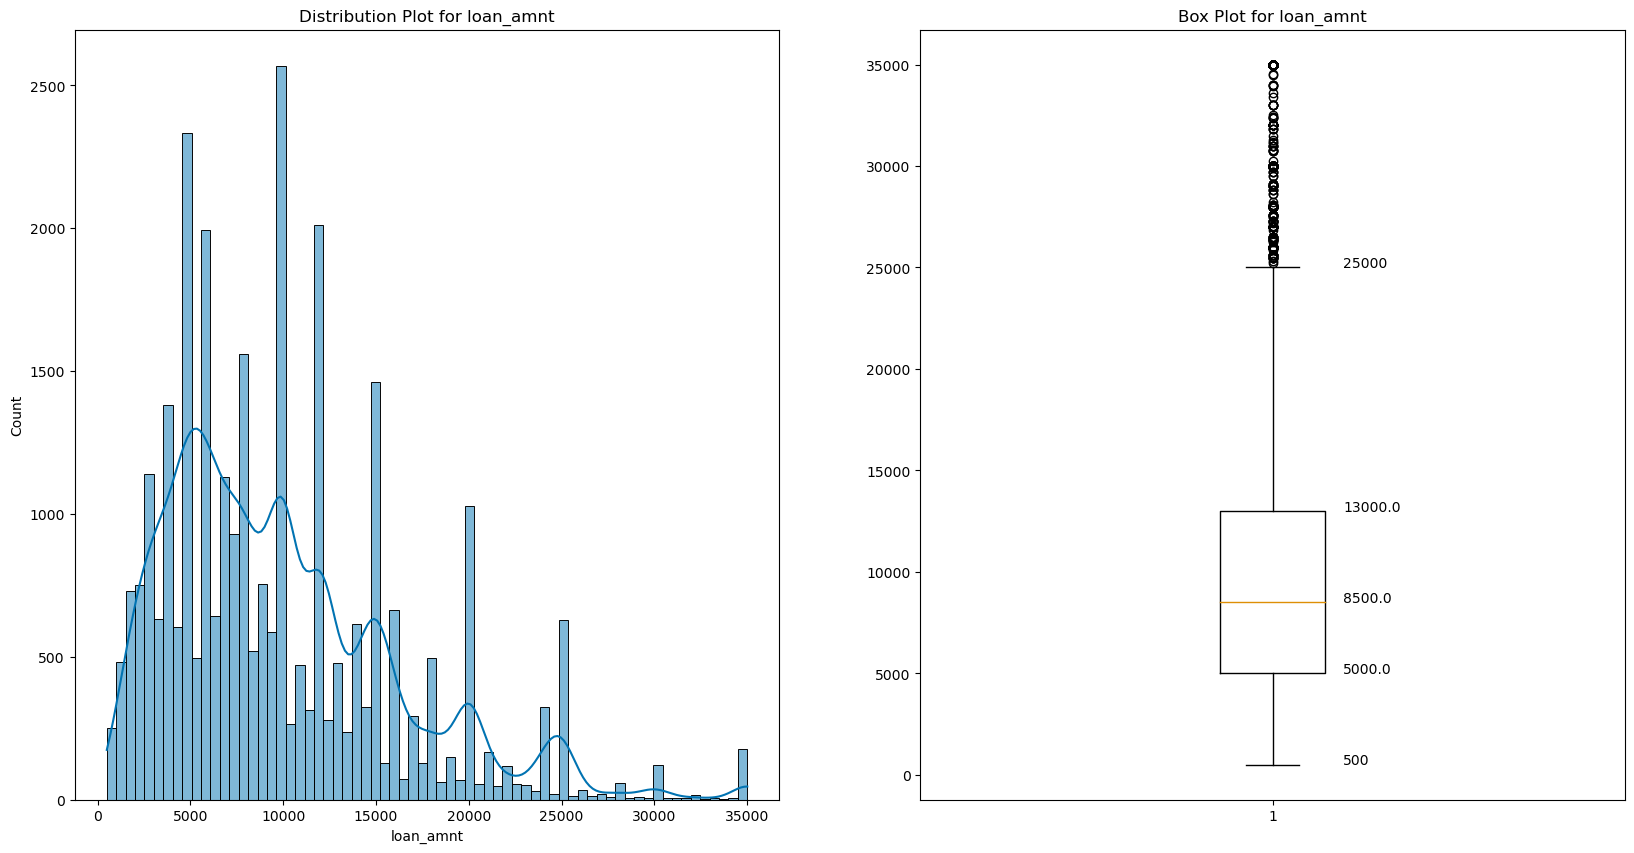

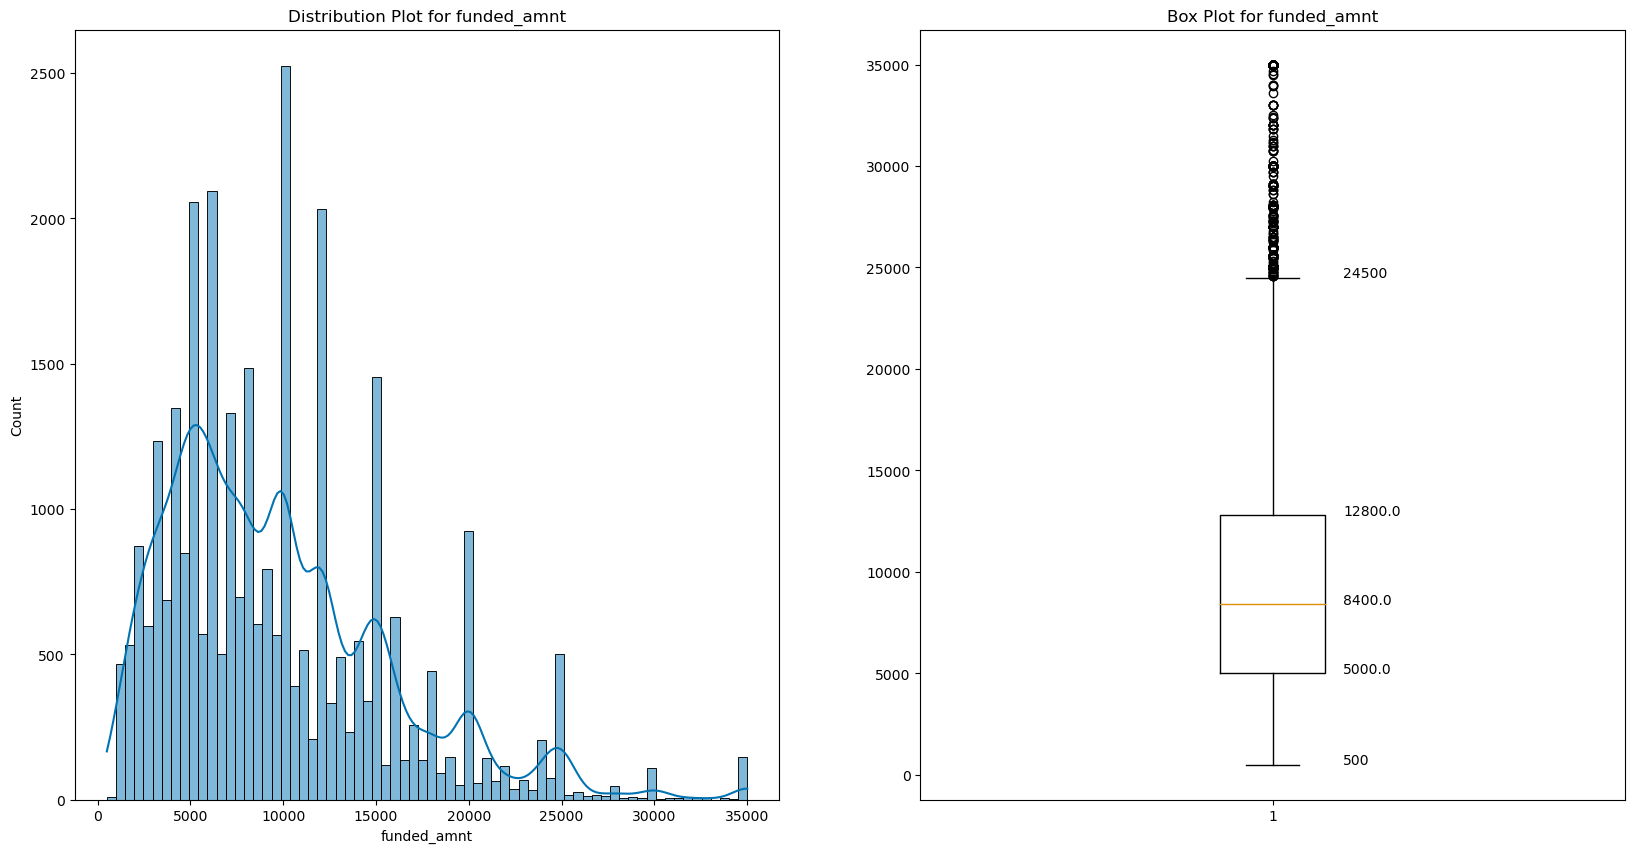

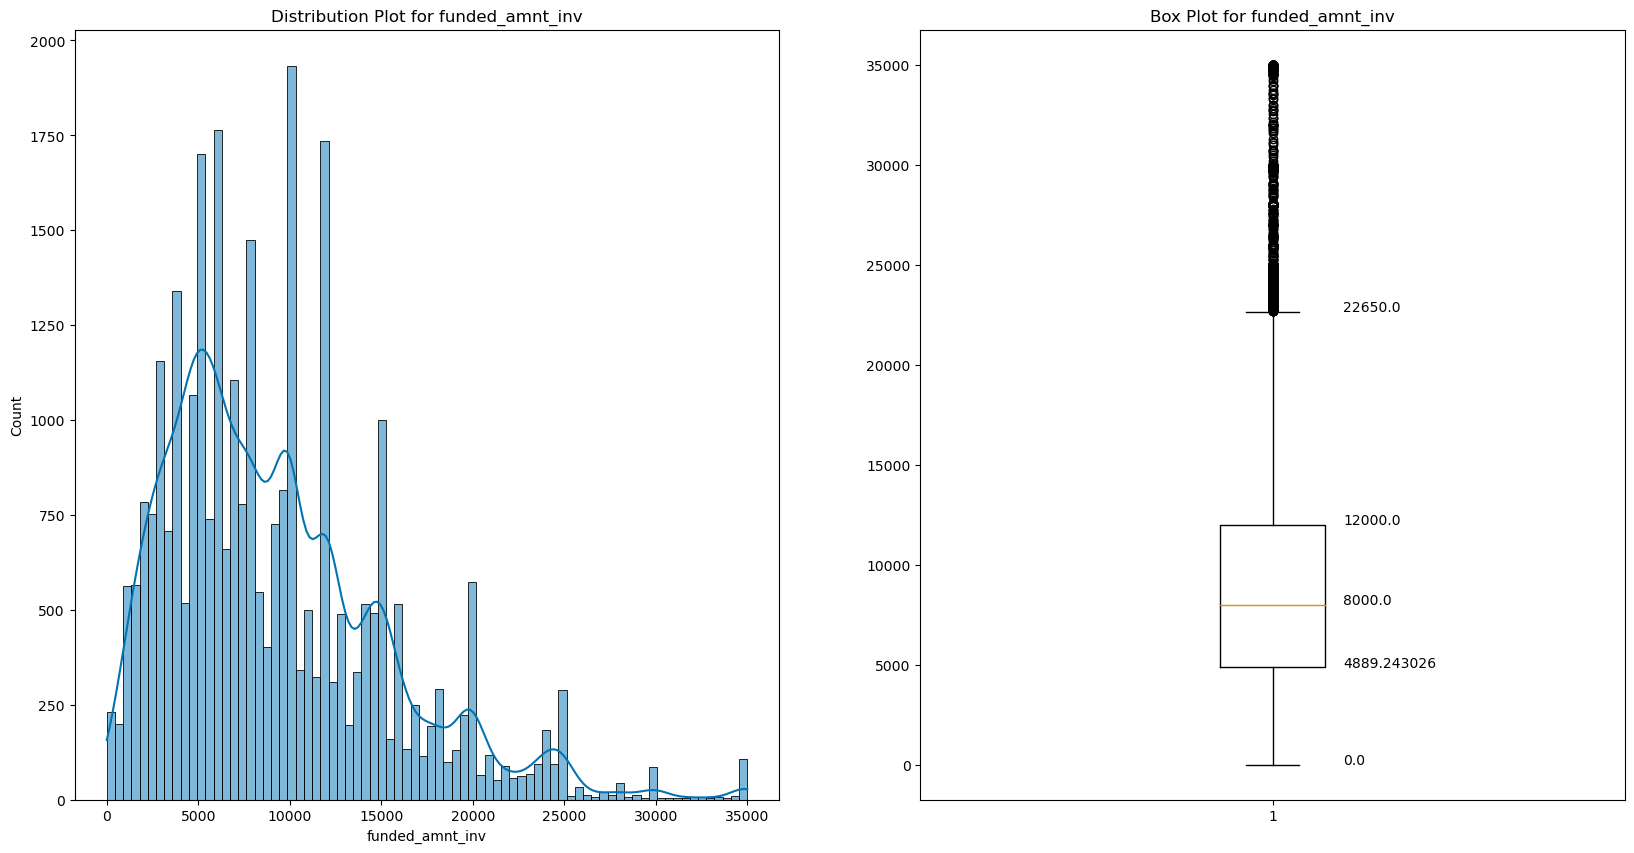

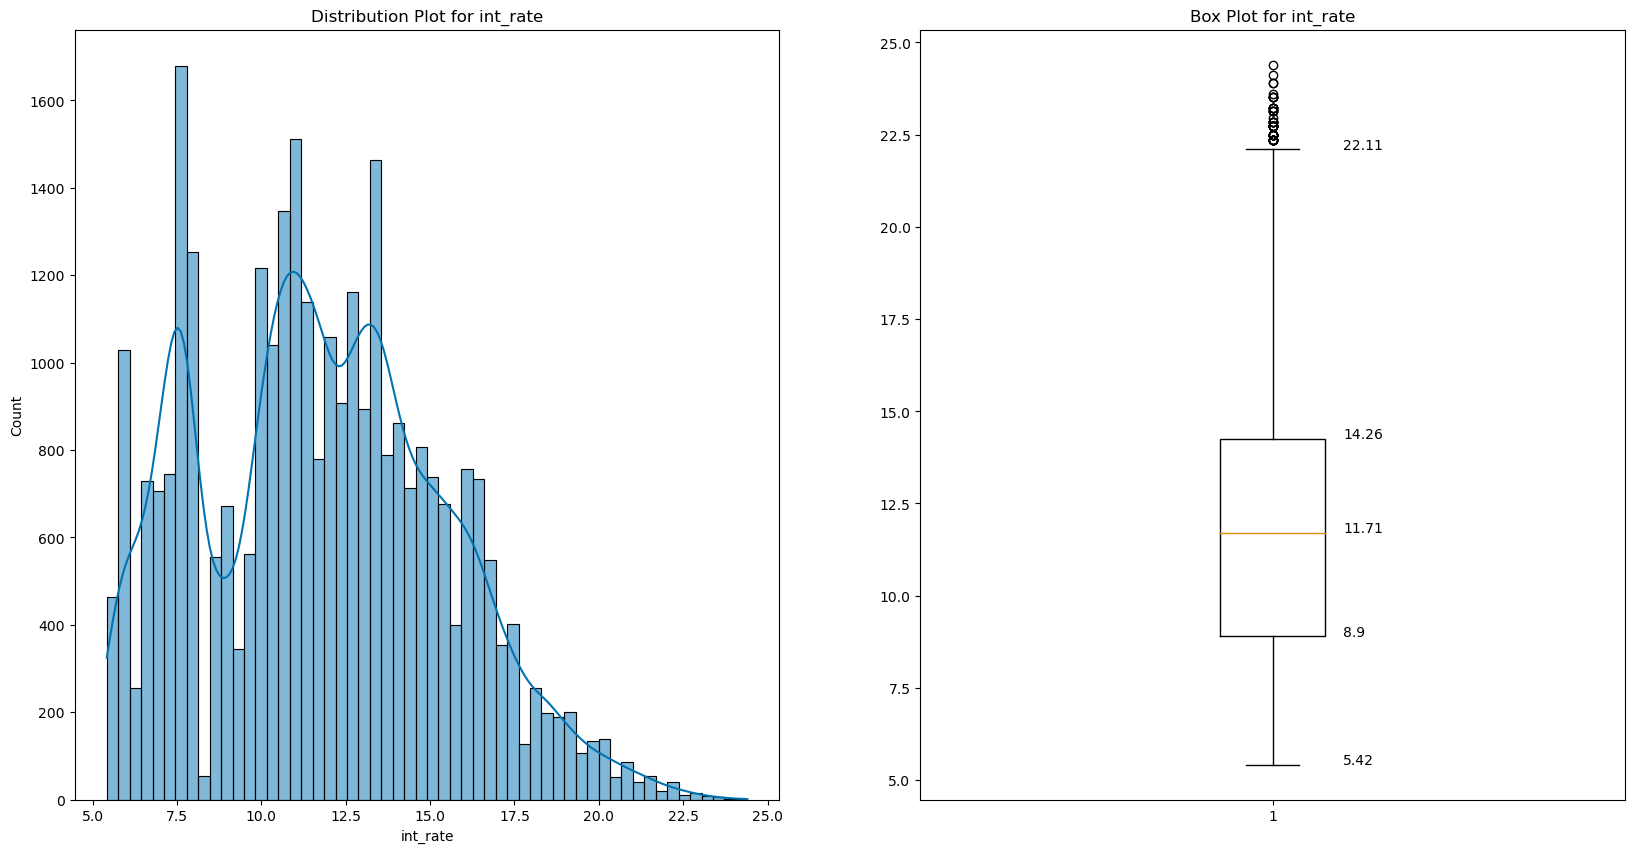

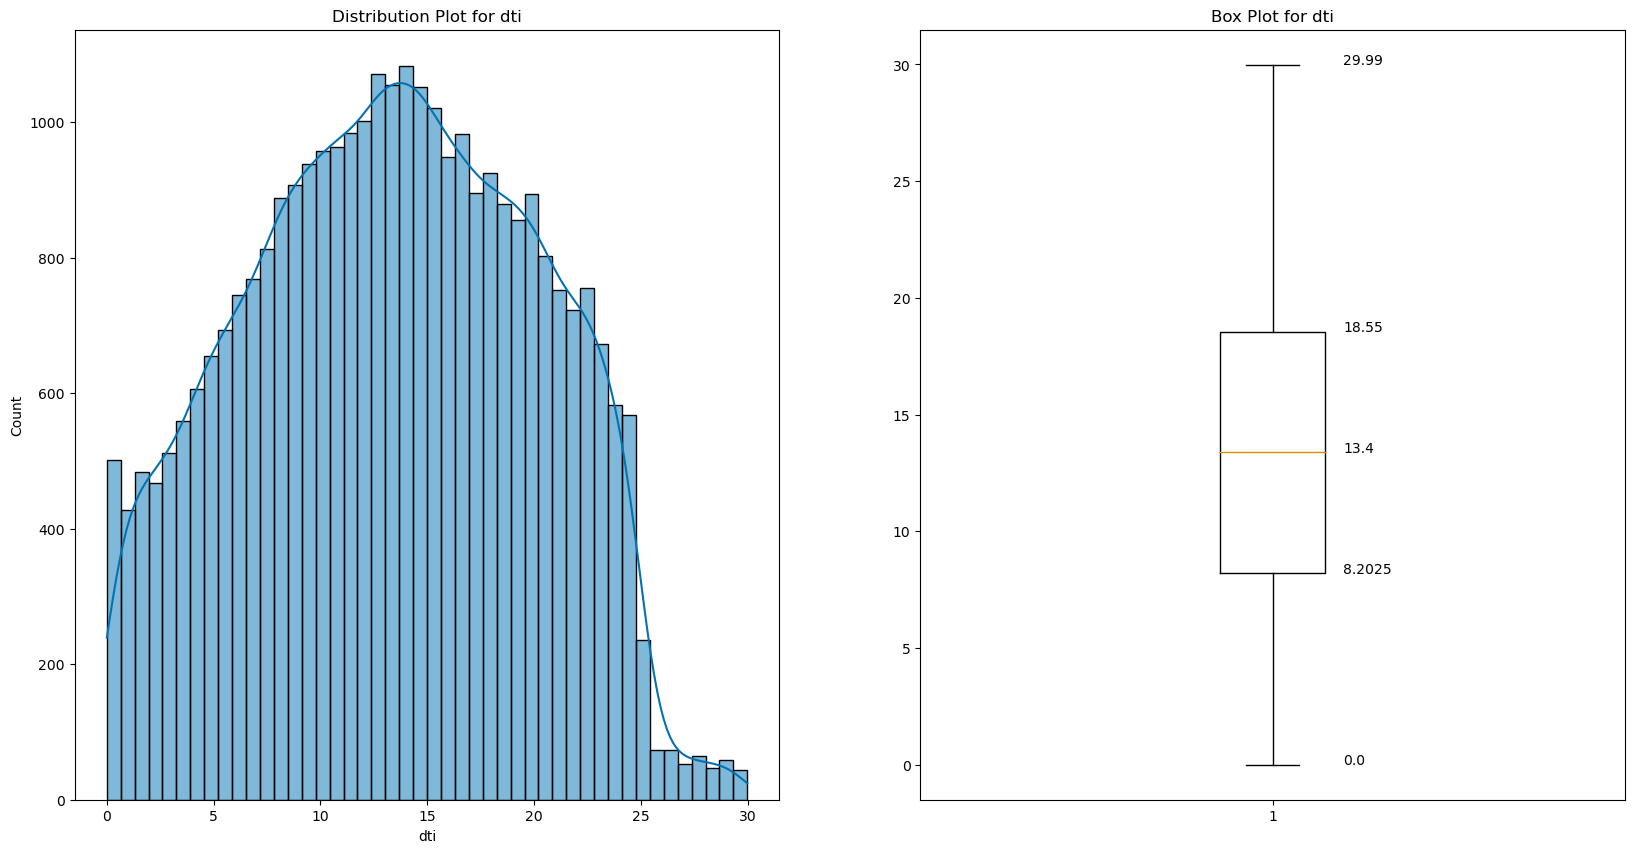

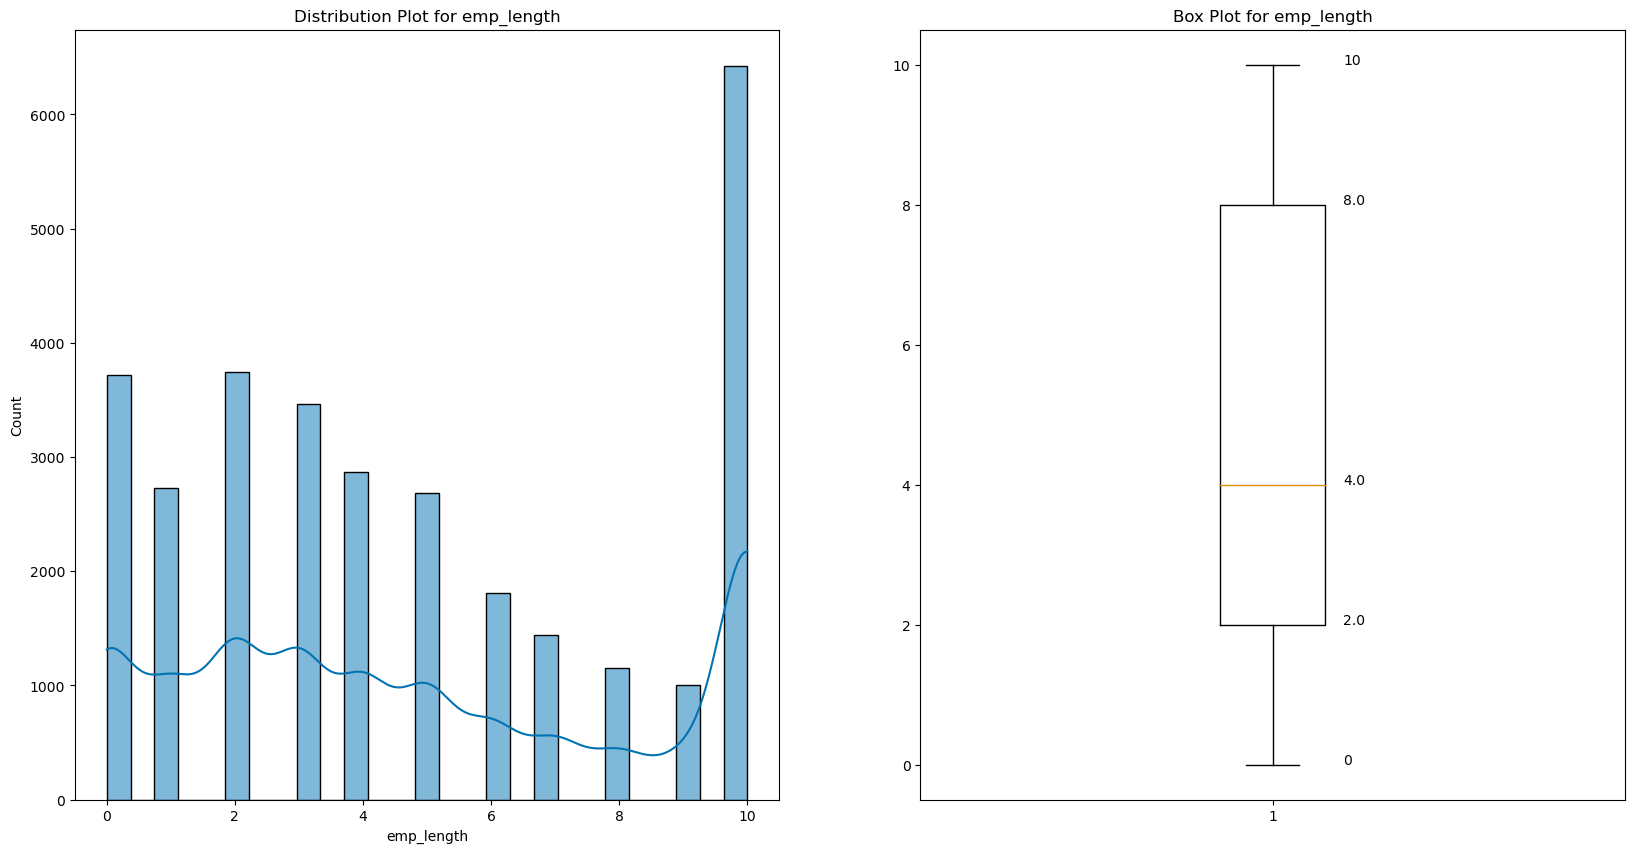

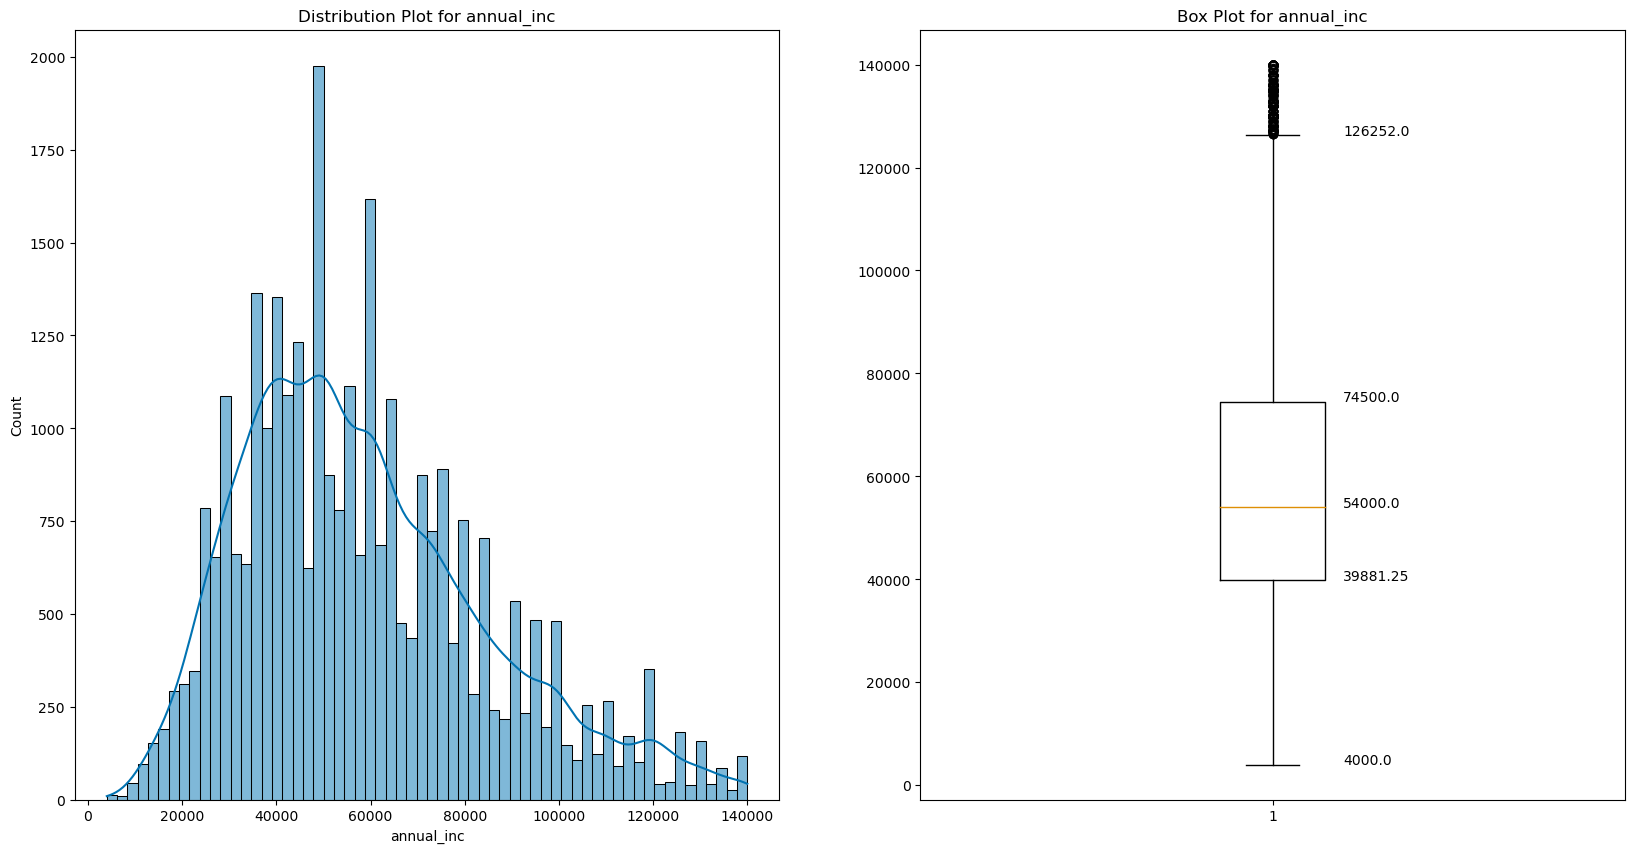

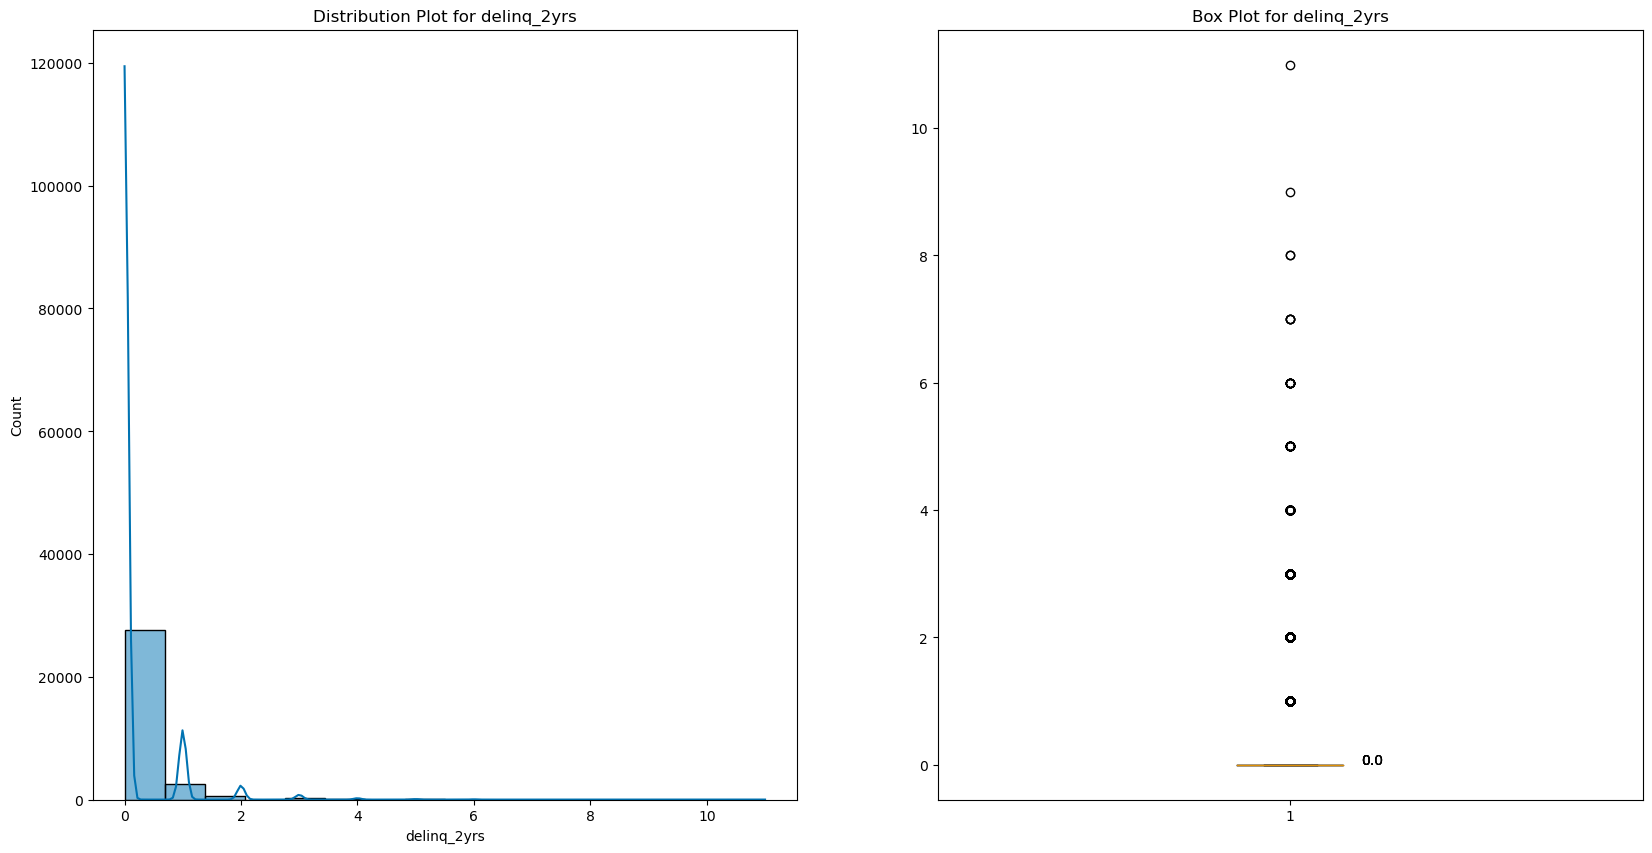

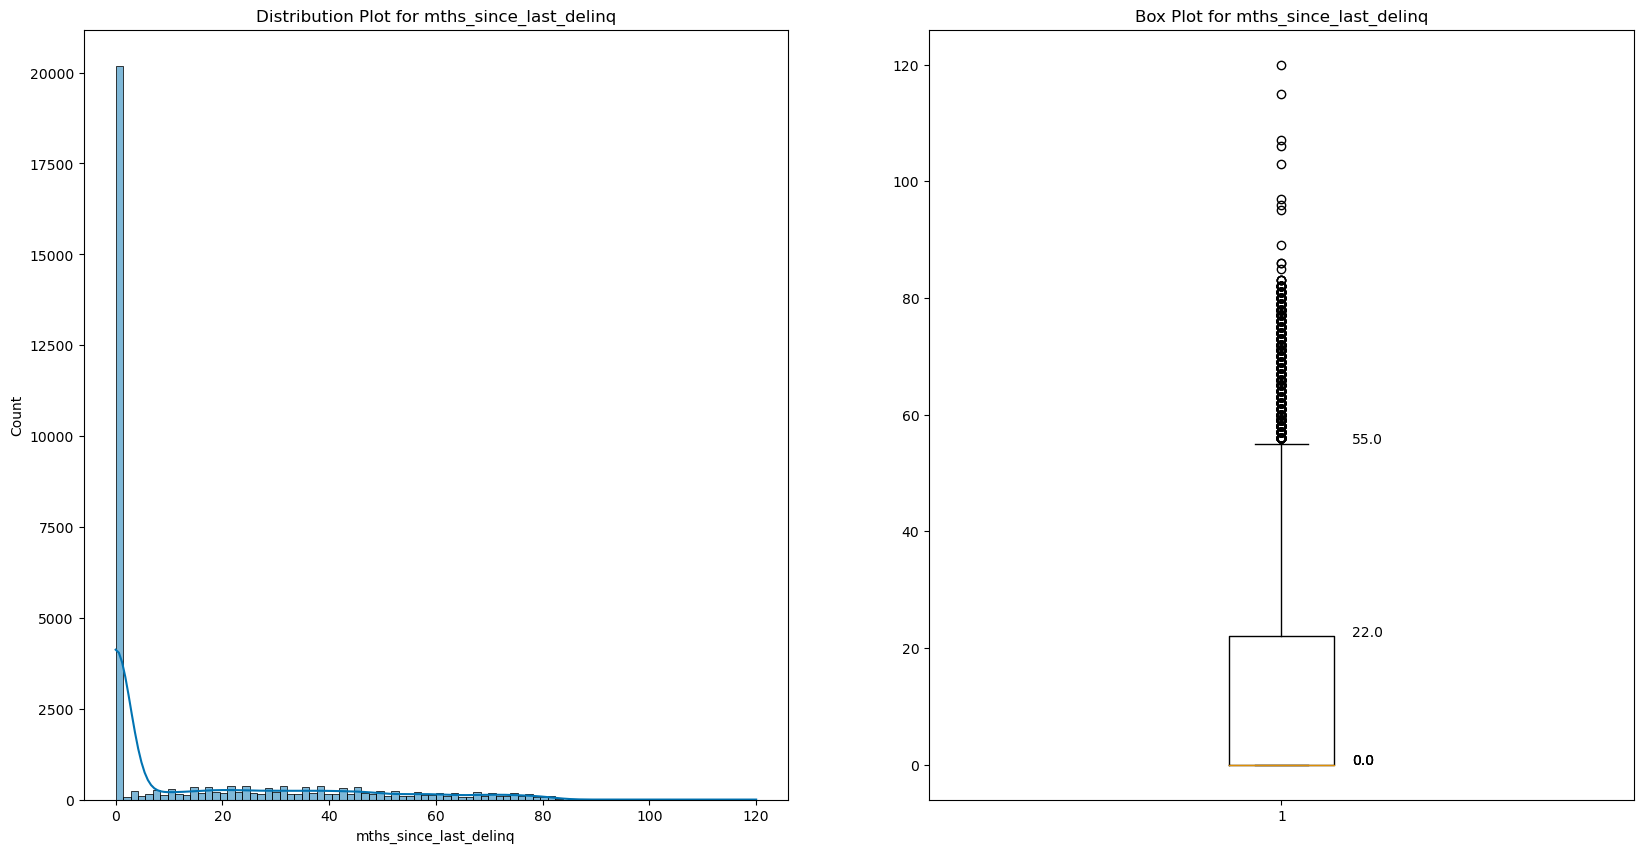

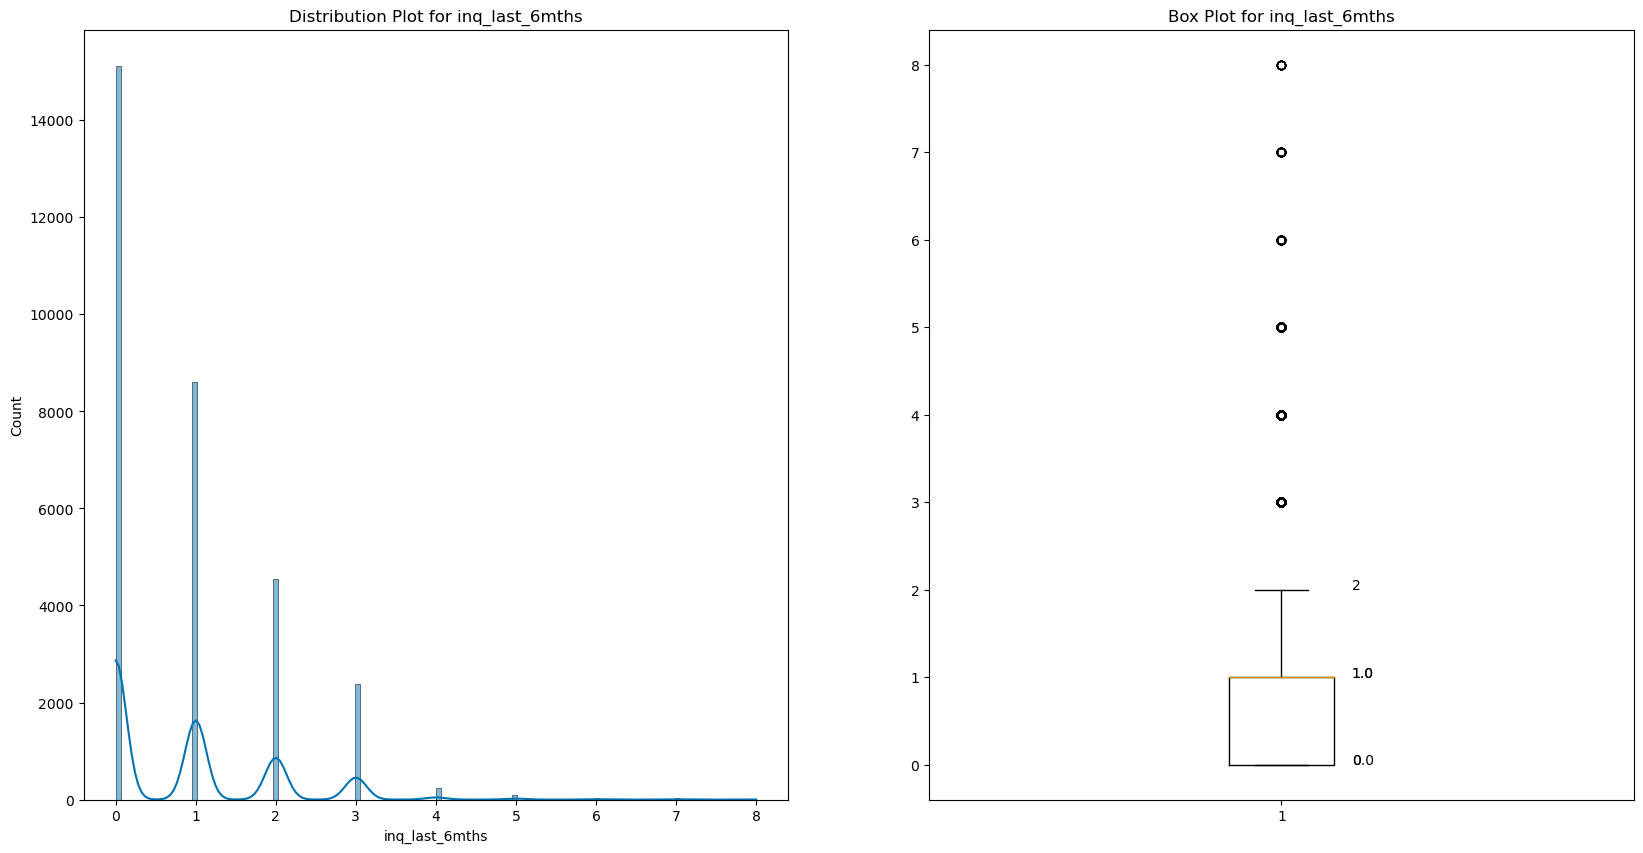

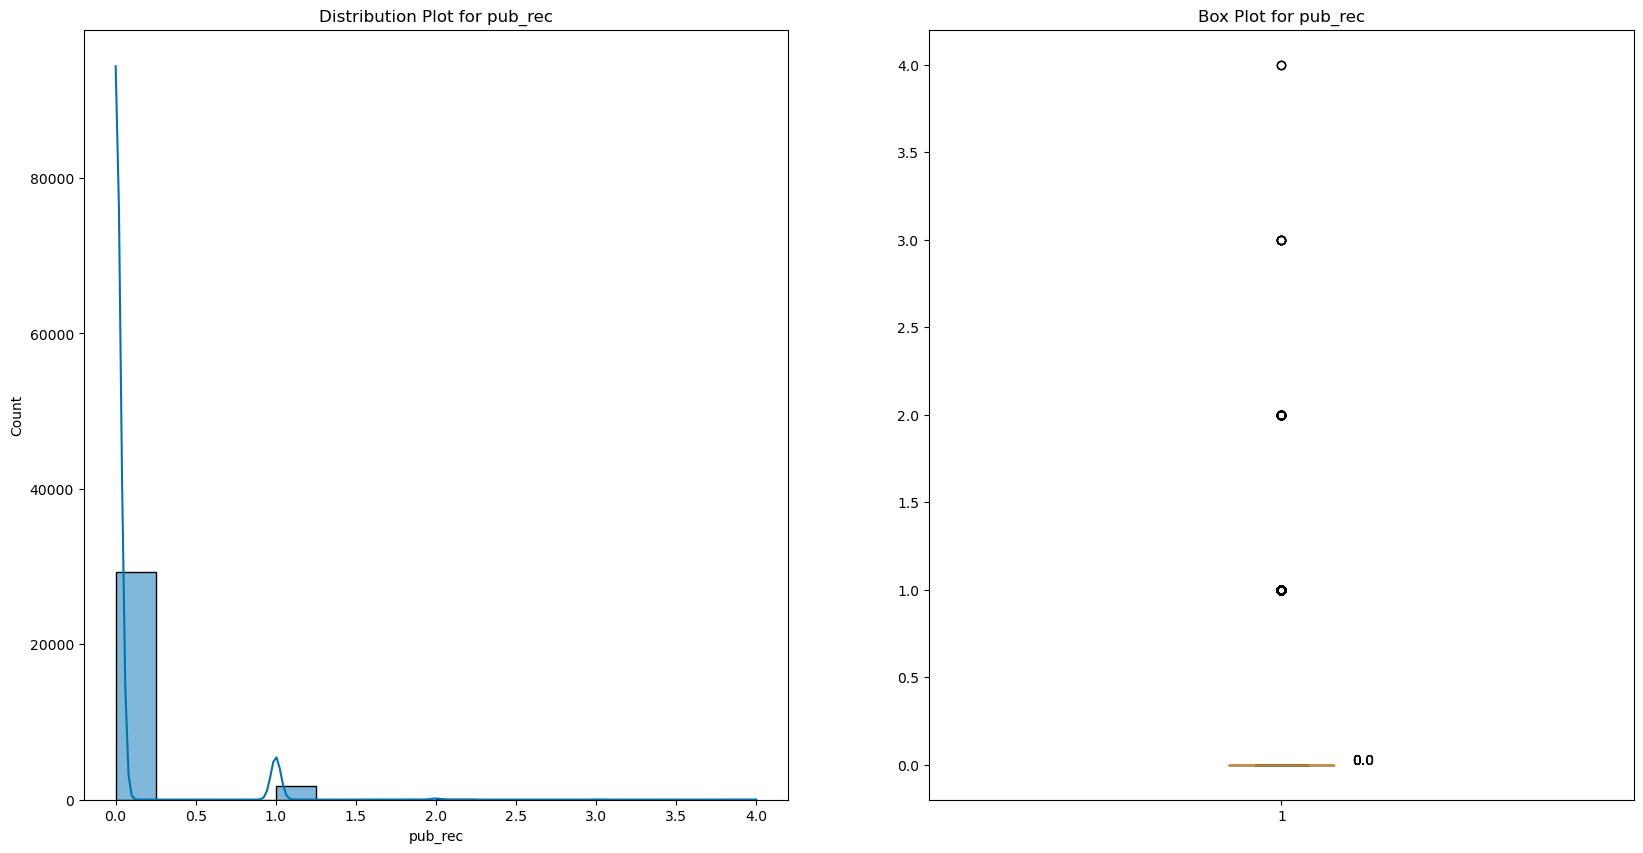

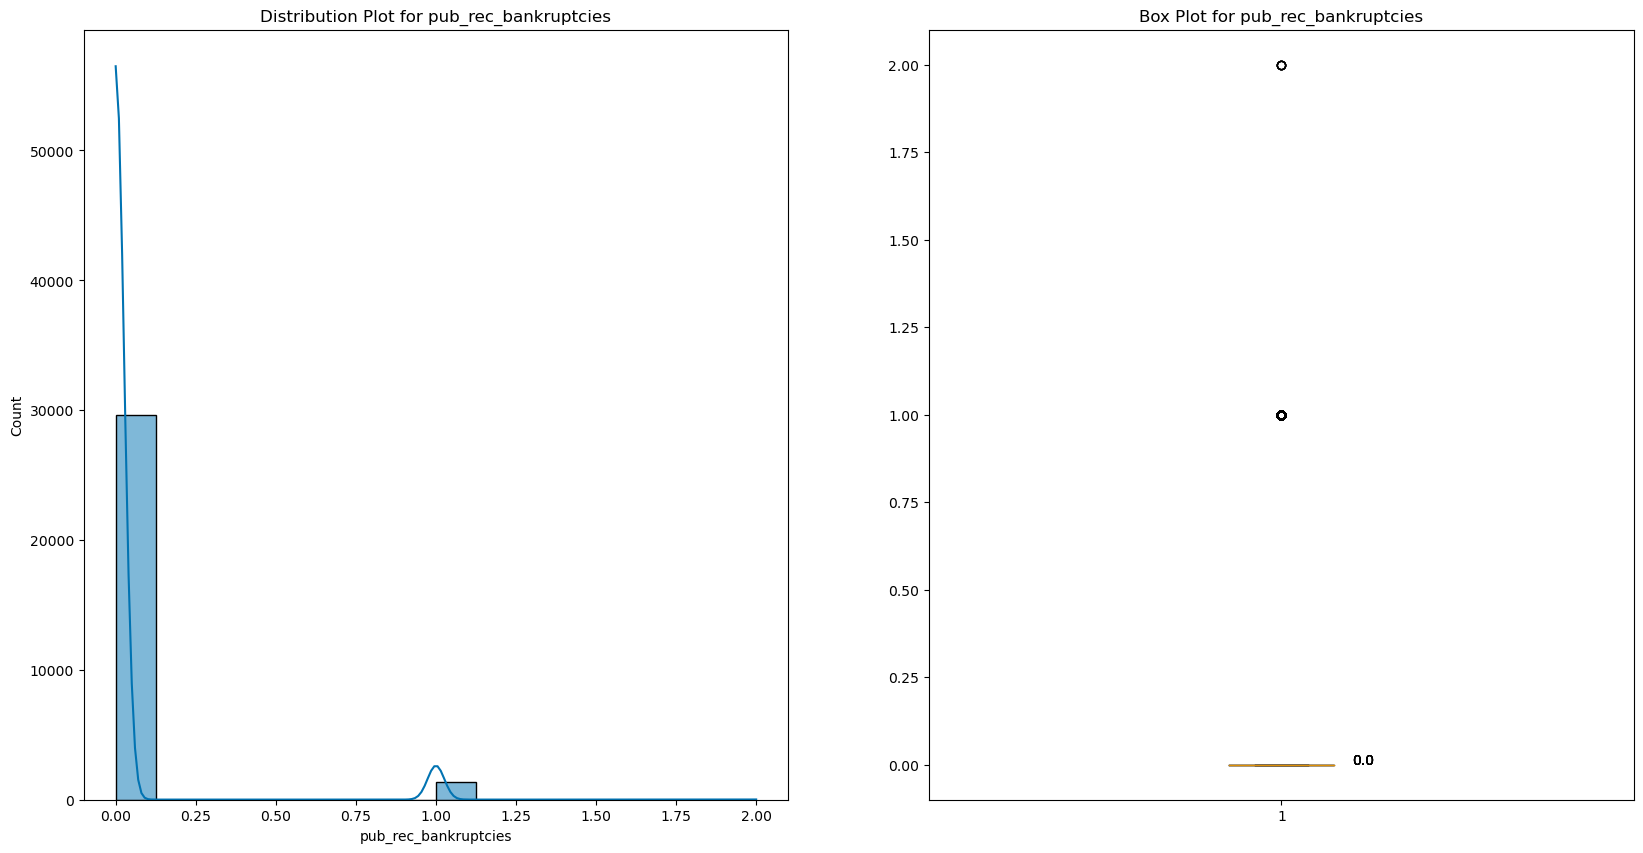

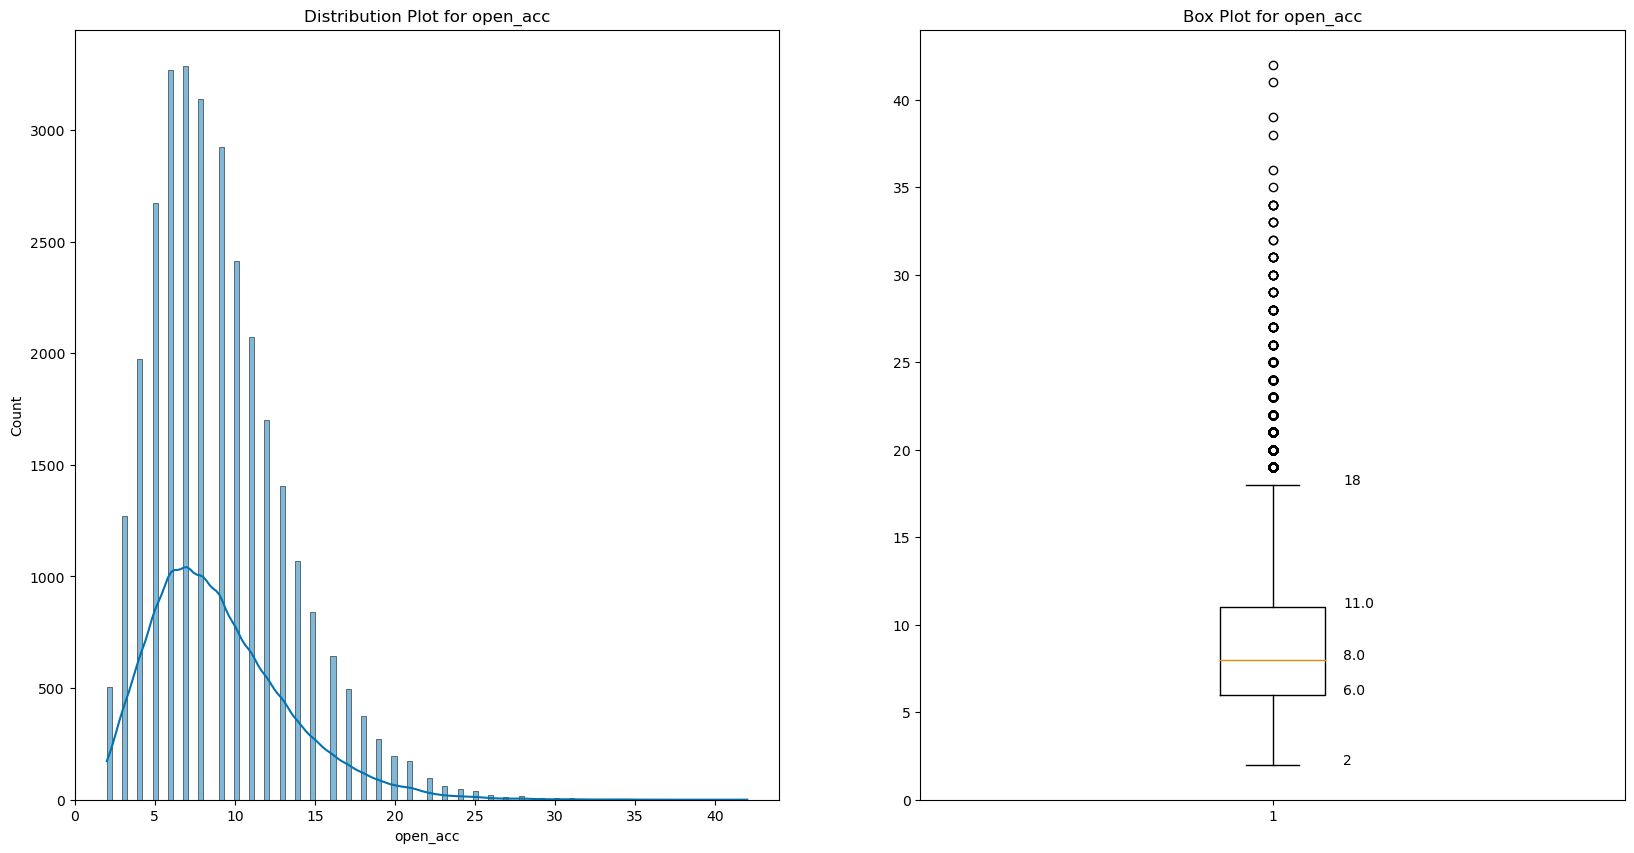

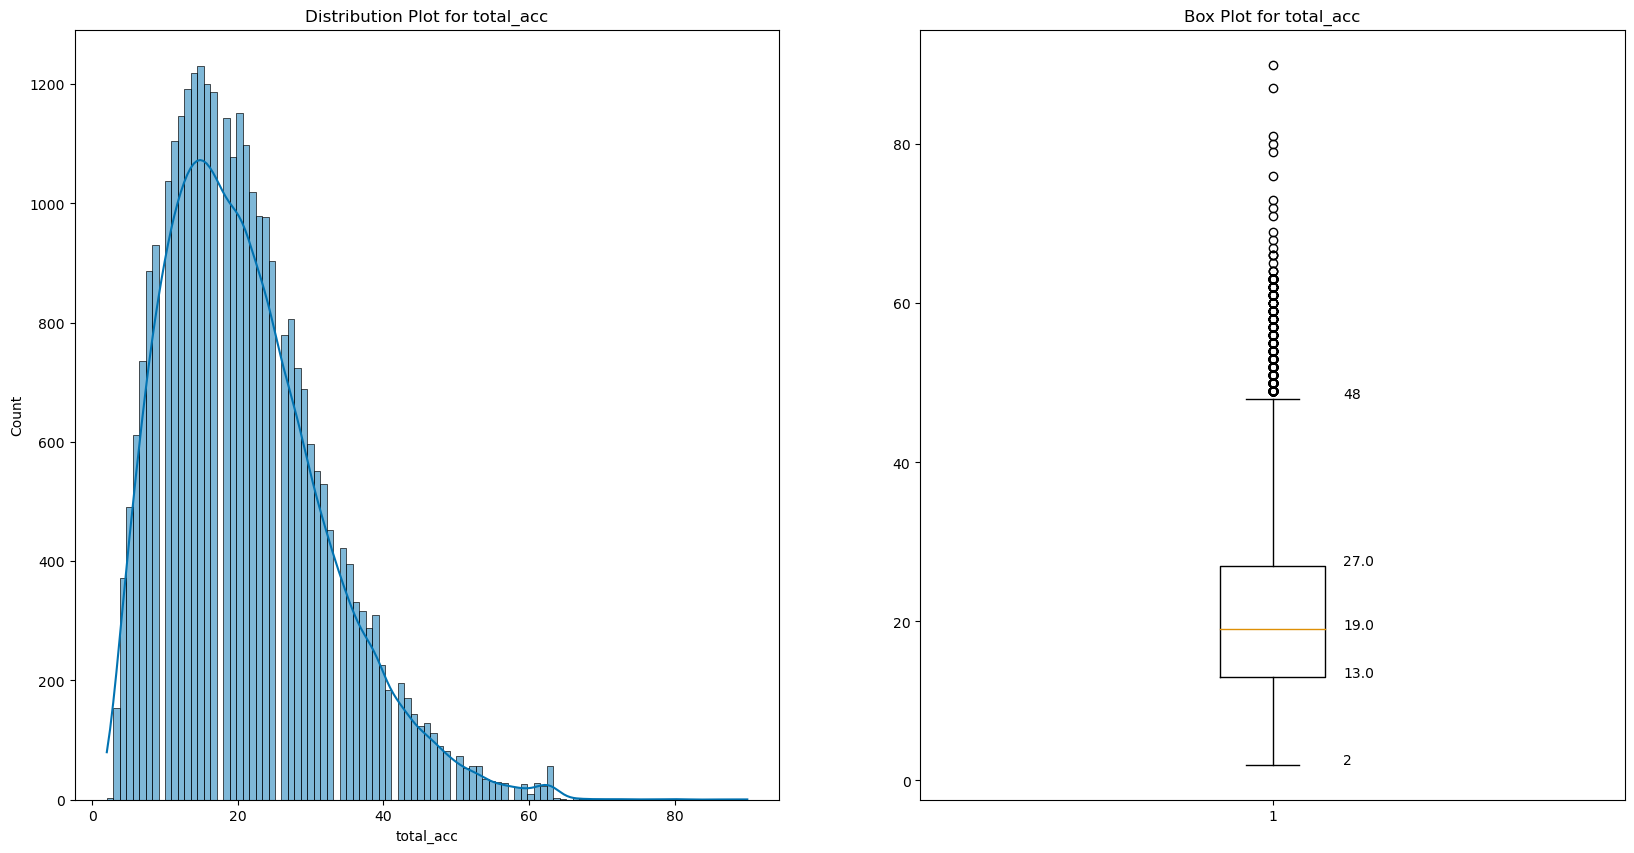

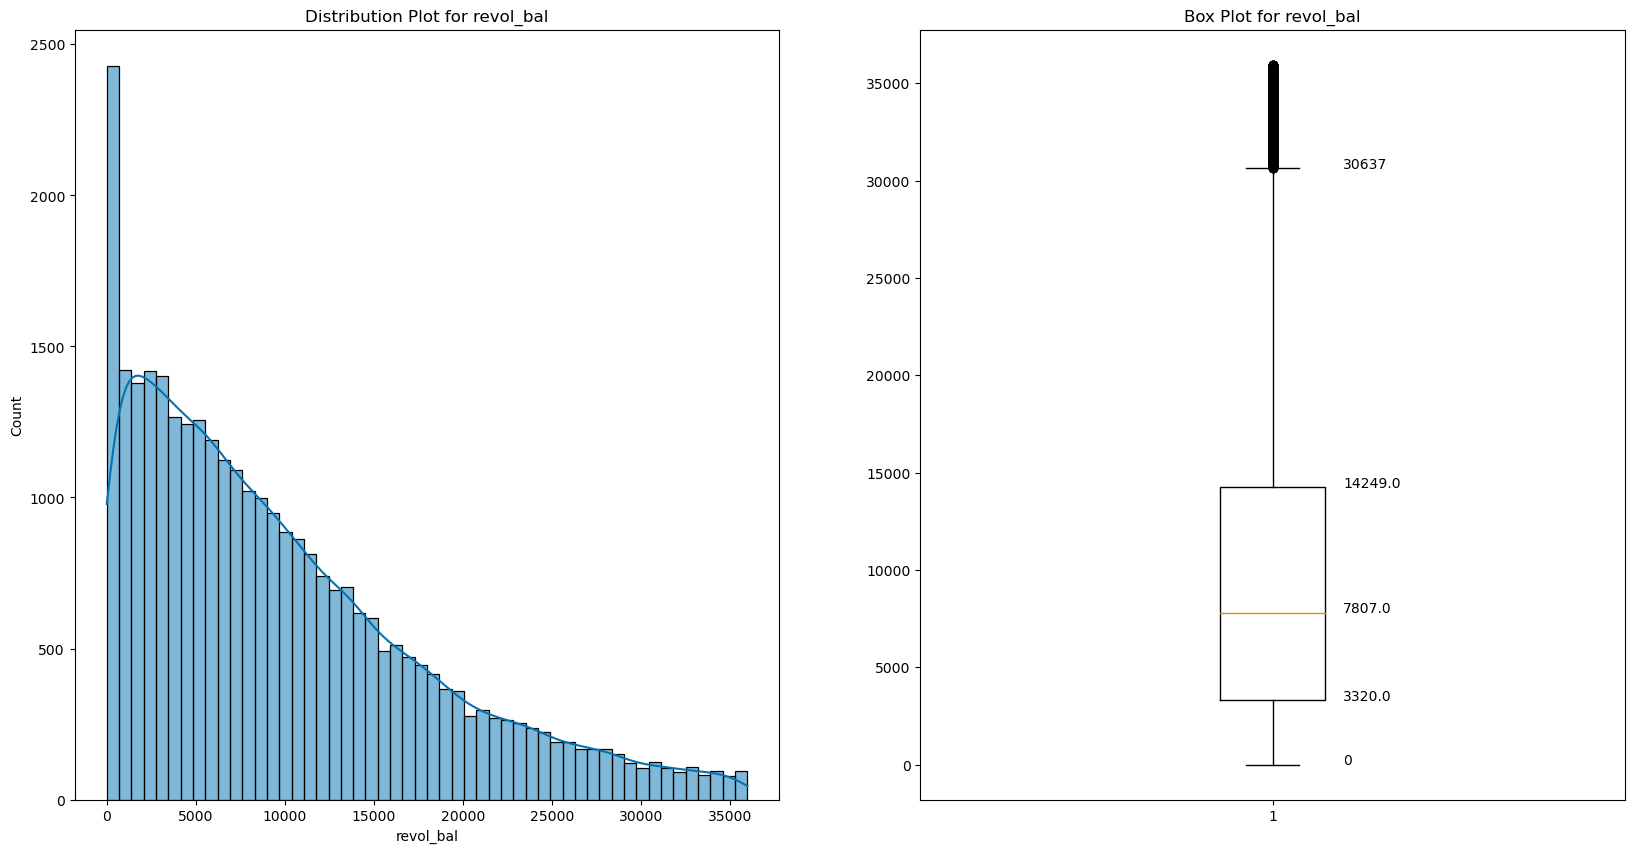

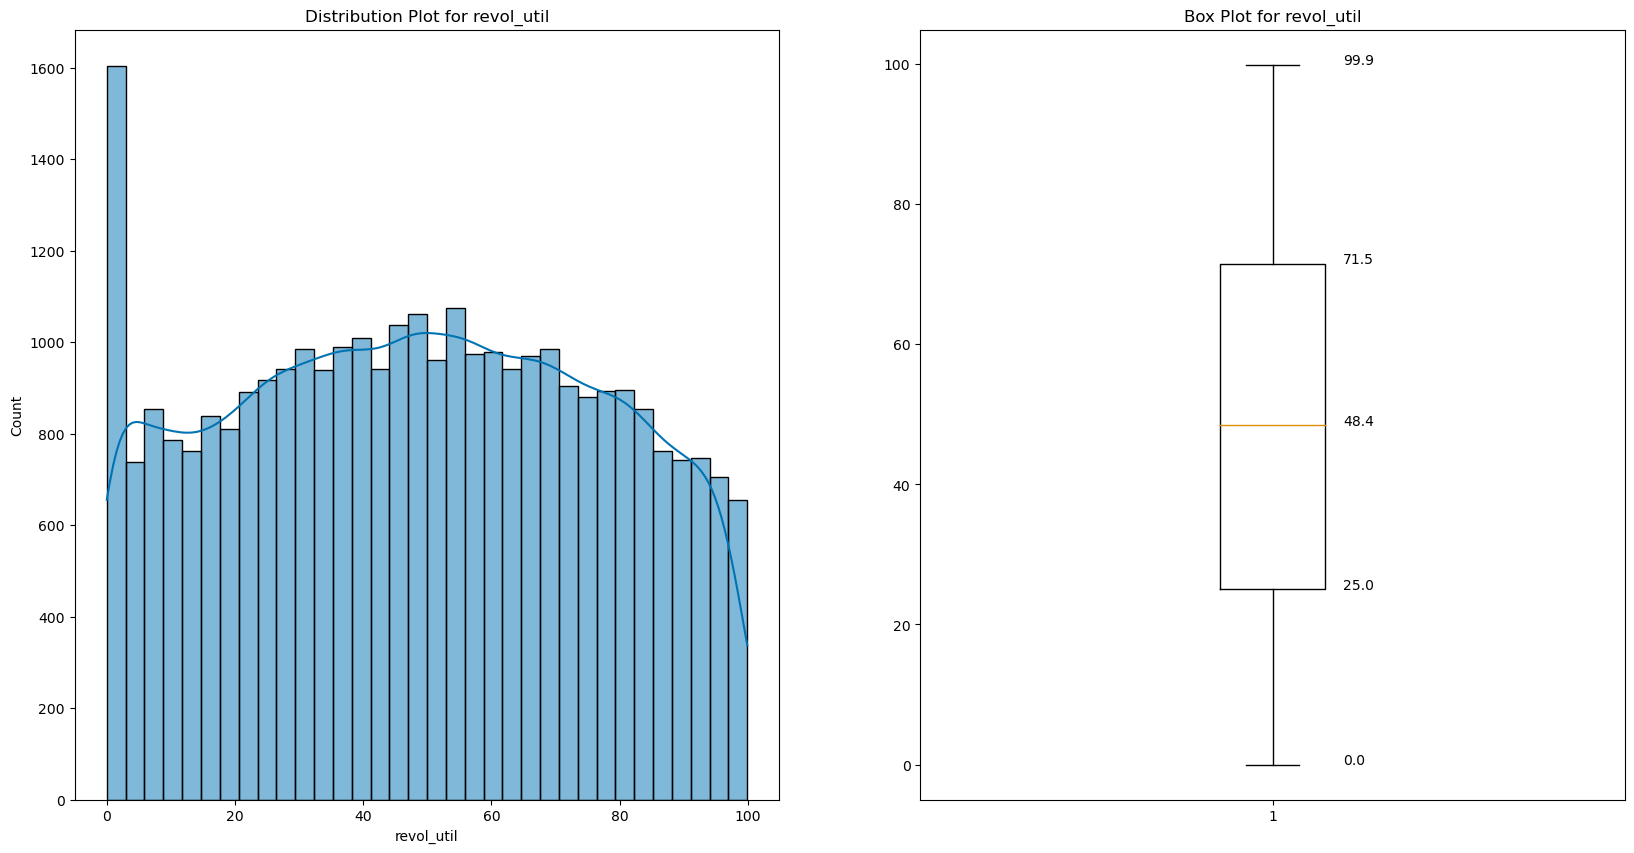

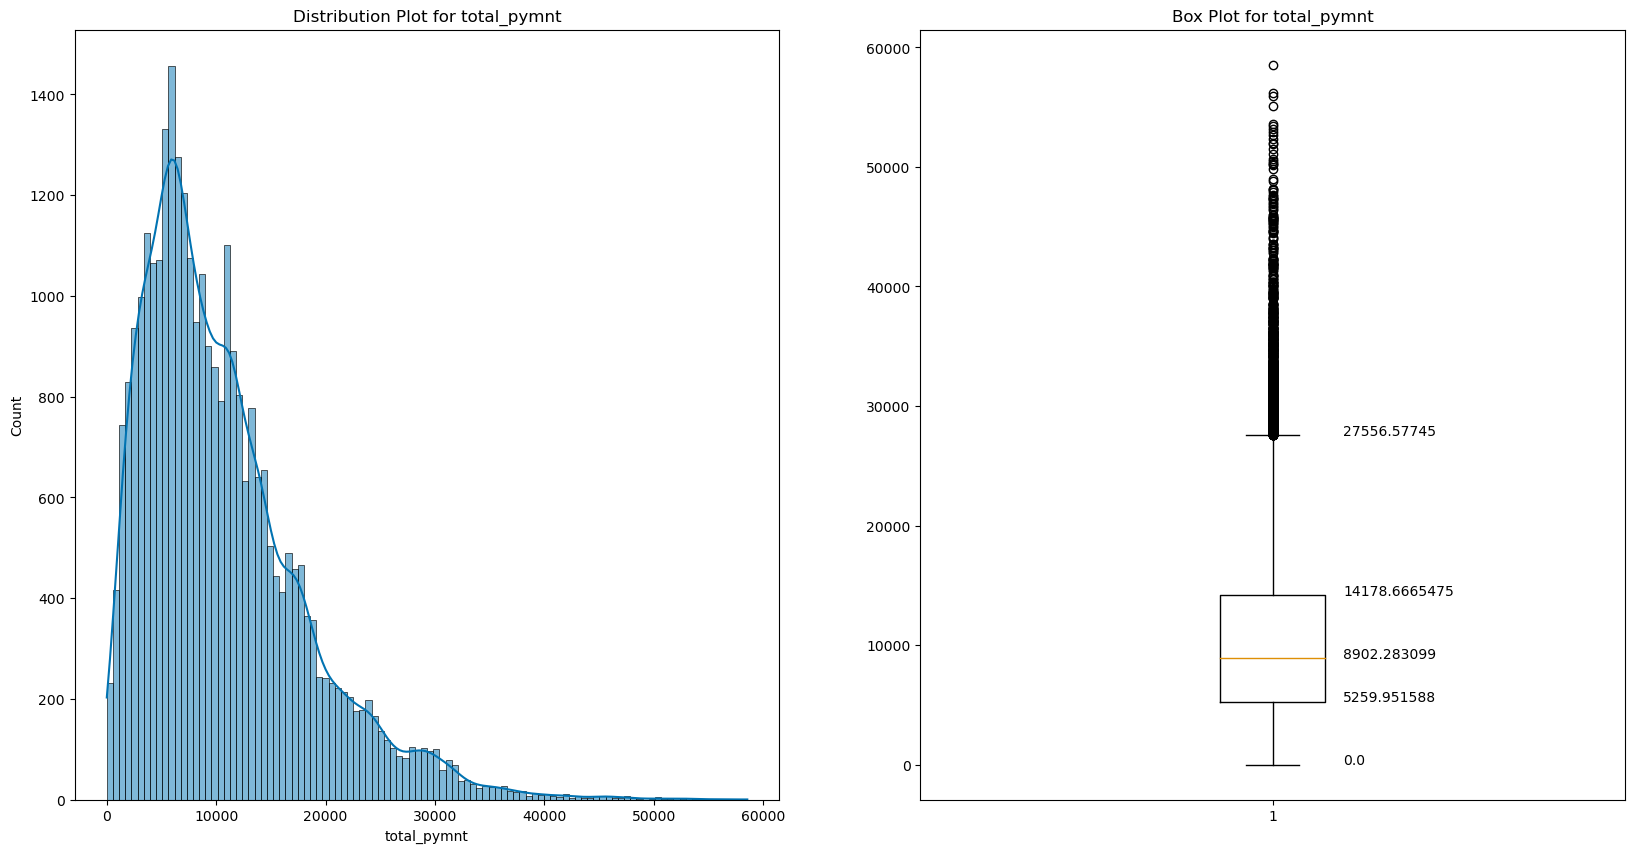

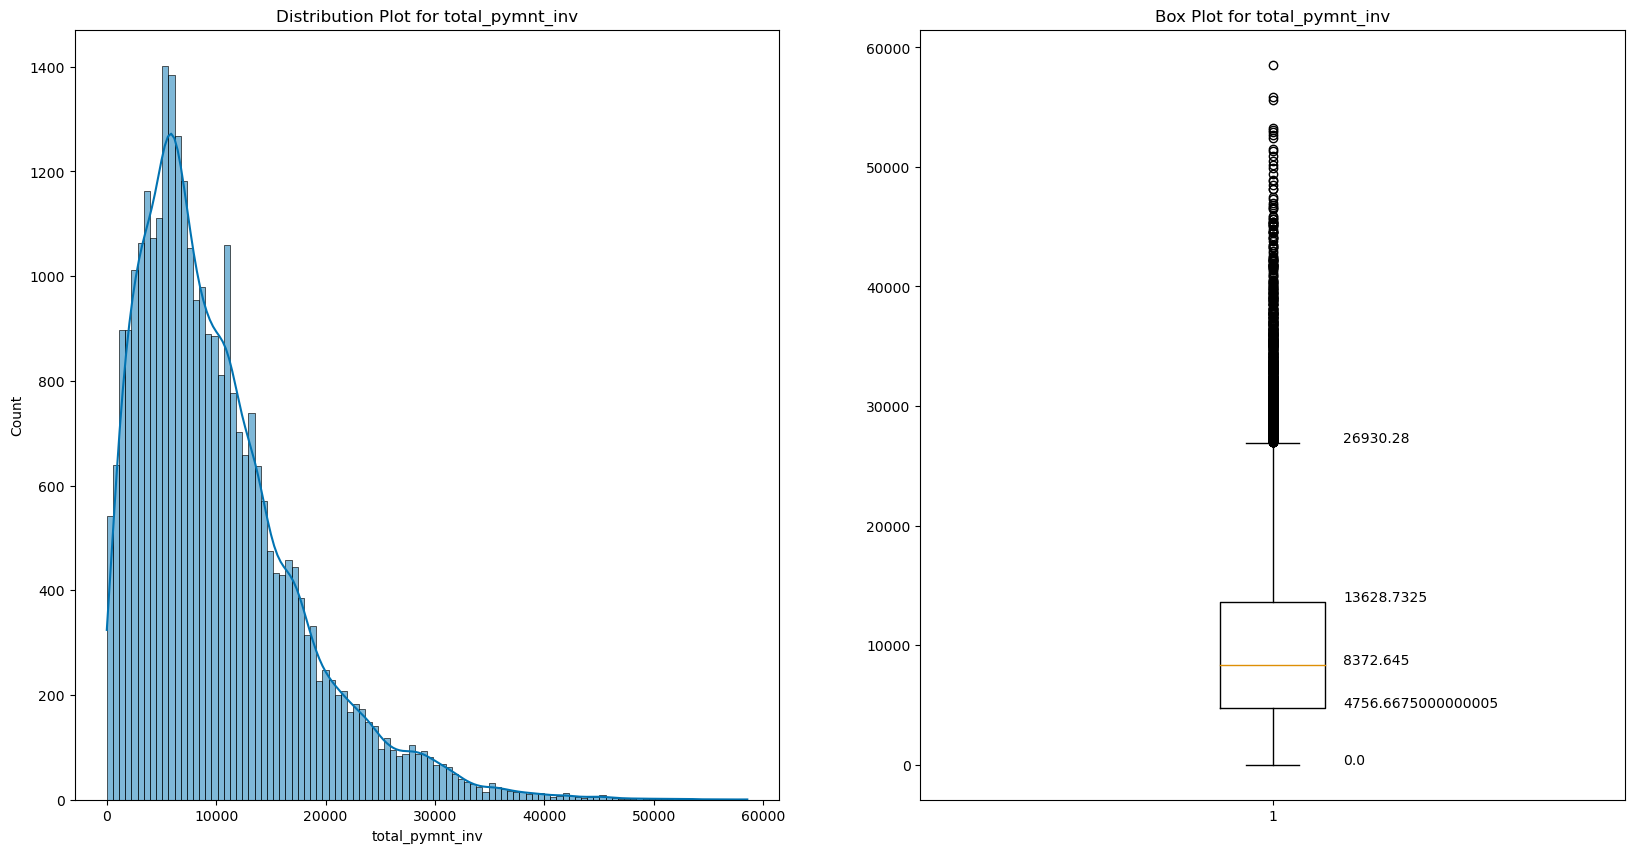

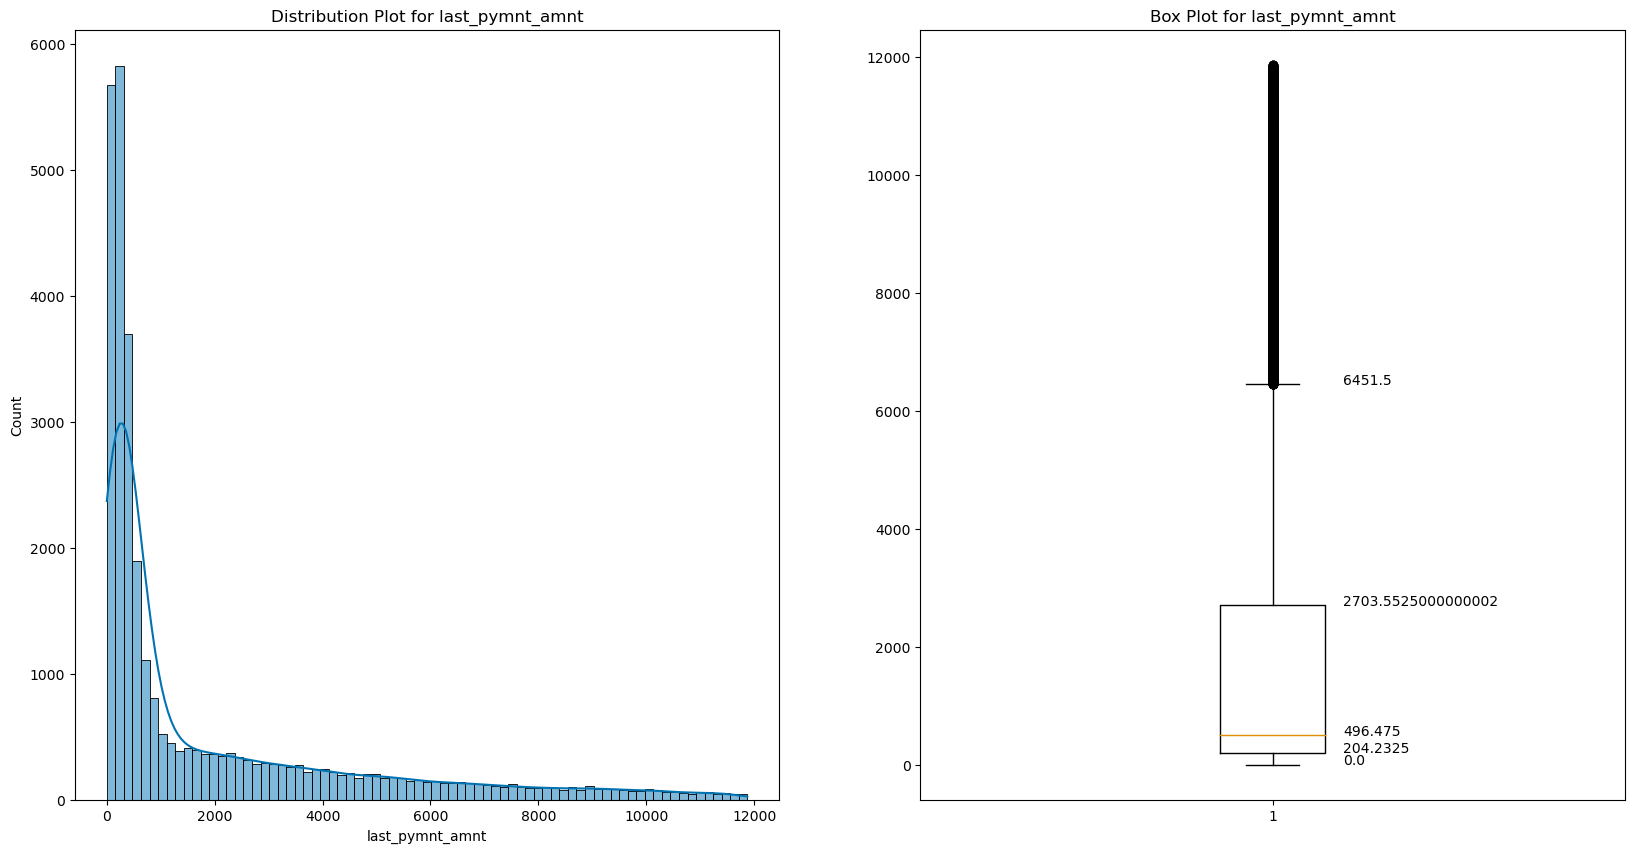

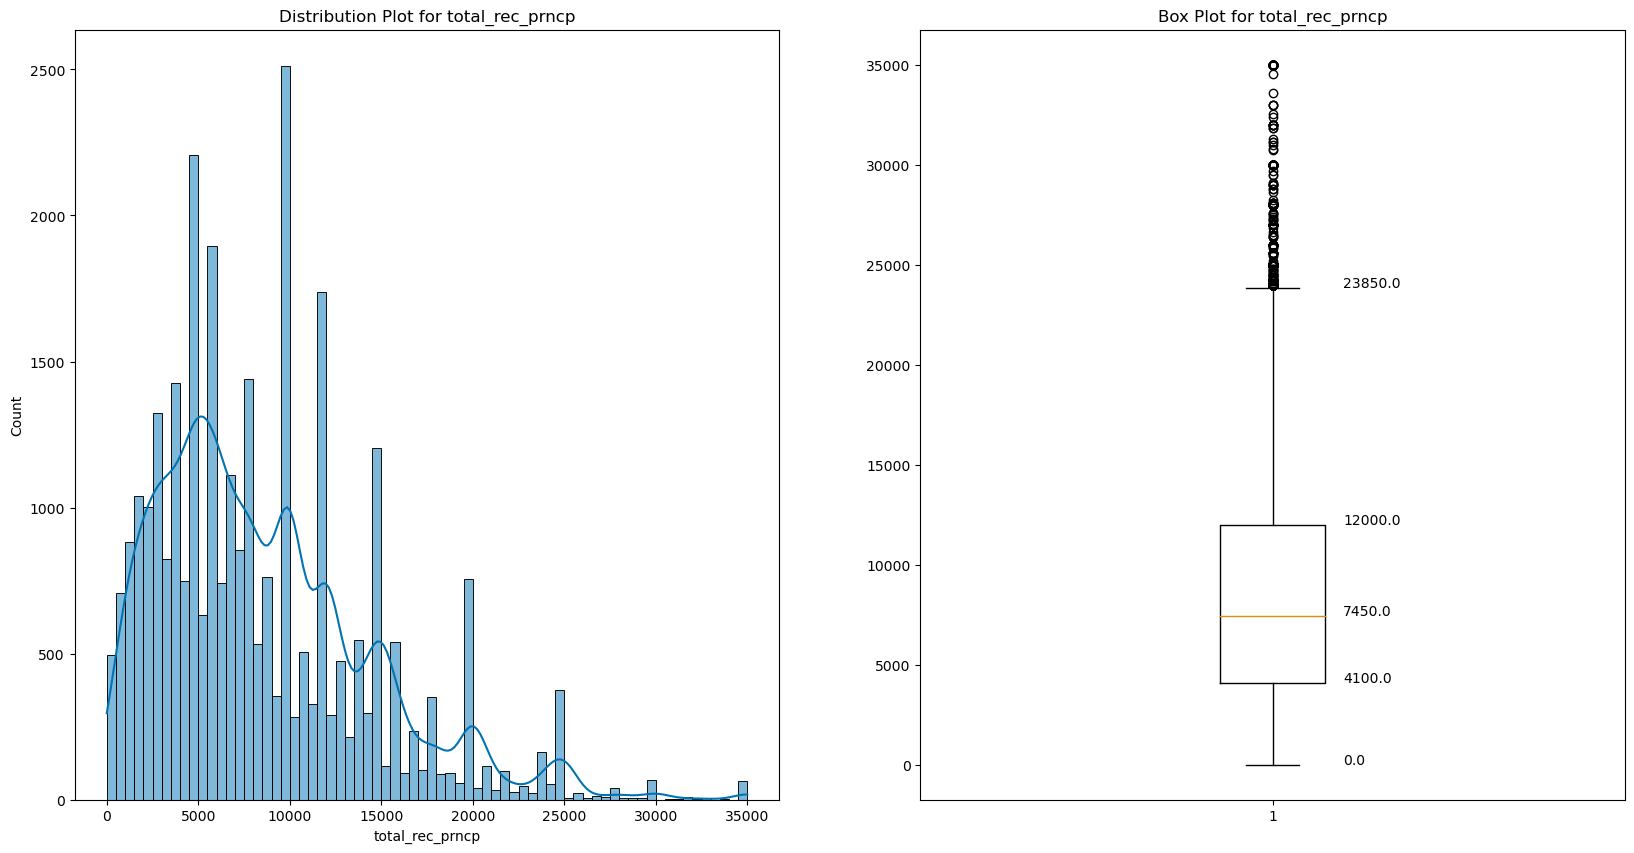

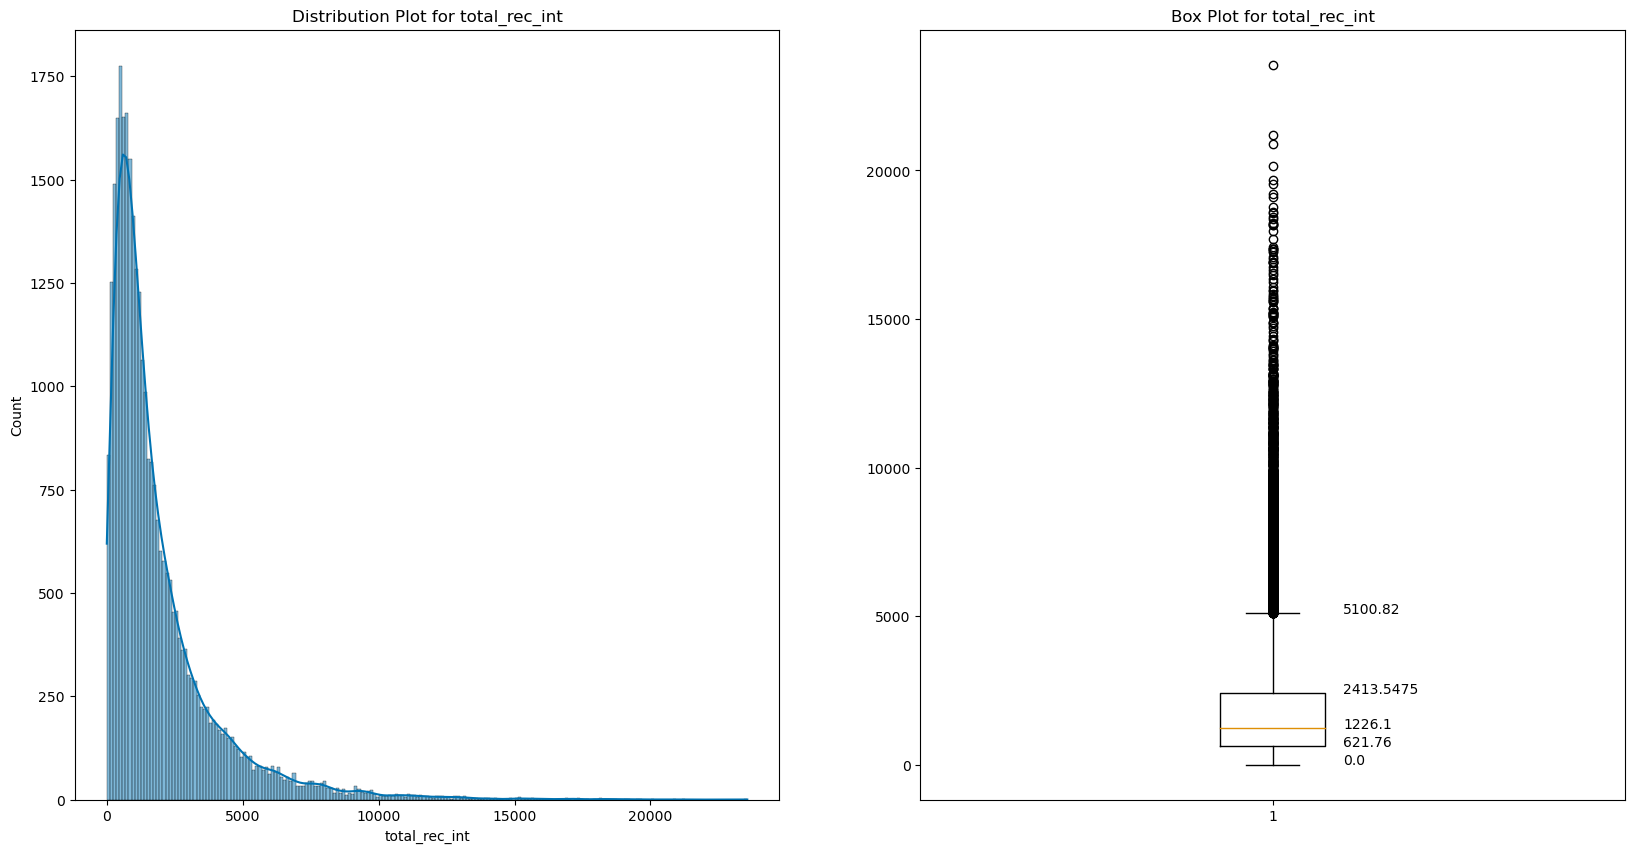

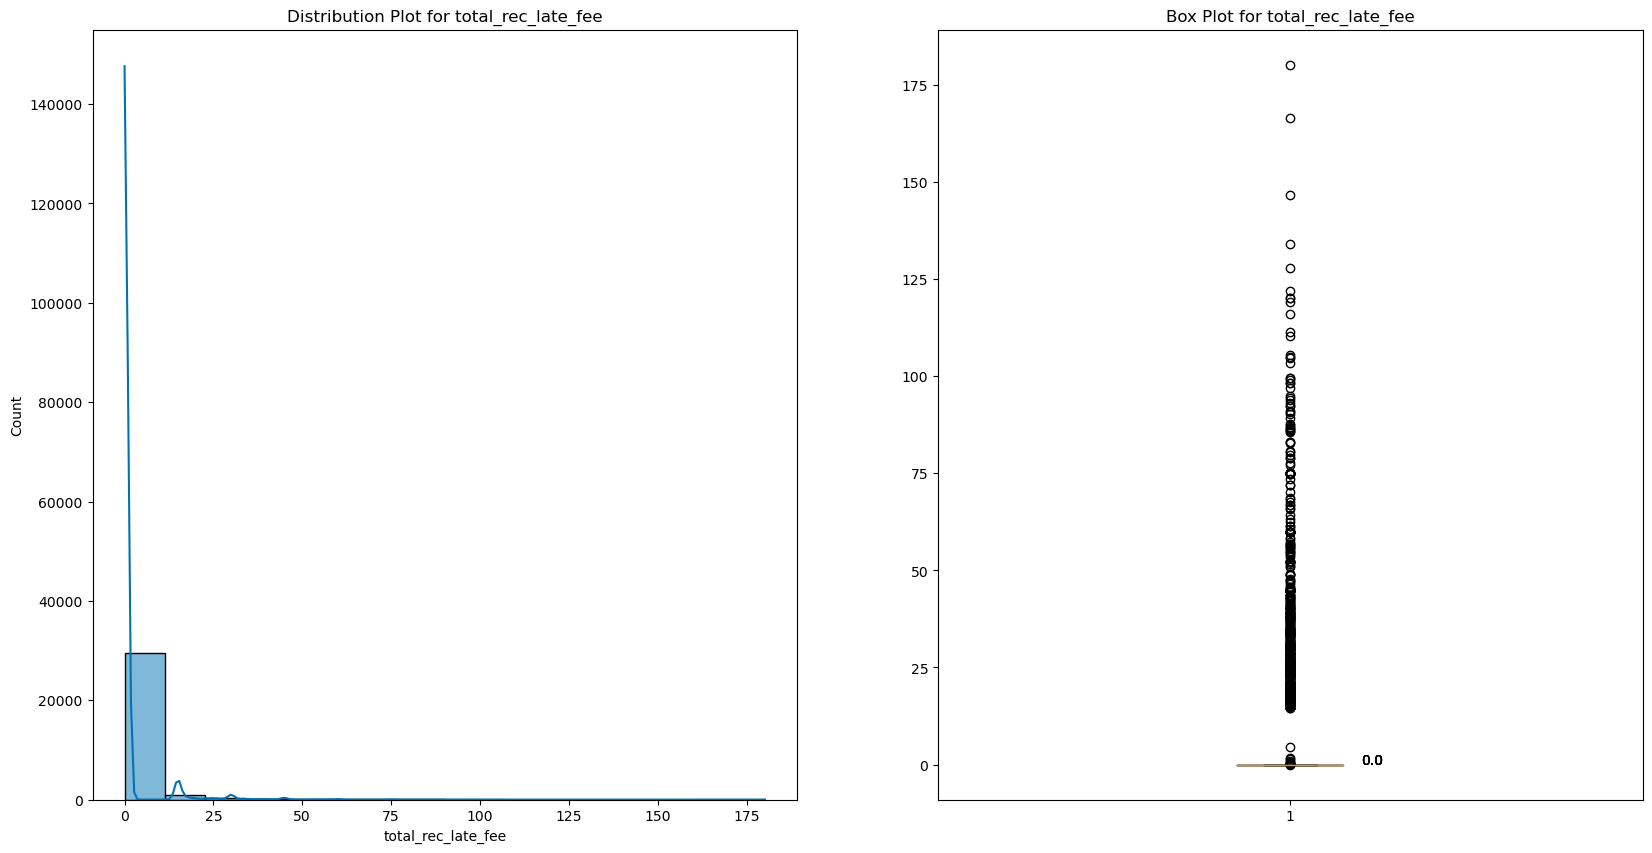

In [231]:
for i in continuous:
    univariate_plot_continuous(i)

## Outlier Treatment

<p>From the above plots there are some attributes with outliers which are worth checking
    
<p> loan_amnt
,funded_amnt
,funded_amnt_inv
,int_rate
,annual_inc
,mnths_since_last_delinq
,revol_bal
,total_pymnt
,total_pymnt_inv
,last_pymnt_amnt
,total_rec_prncp
,total_rec_int

#### Where there are clear outliers in the column, we will remove the values greater than 95% quantile to standardize the data

#### annual_inc

<Axes: >

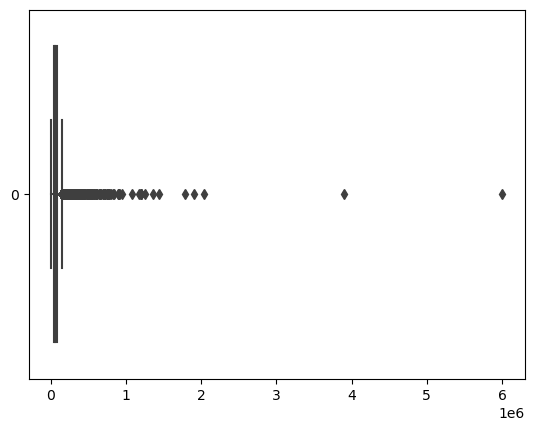

In [178]:
sns.boxplot(loan_df['annual_inc'], orient='h')

In [179]:
quantile_info = loan_df.annual_inc.quantile([0.5, 0.25, 0.50, 0.75, 0.80, 0.95, 0.97, 0.99])
quantile_info

0.50     60000.0
0.25     41000.0
0.50     60000.0
0.75     82000.0
0.80     90000.0
0.95    140000.0
0.97    162000.0
0.99    230000.0
Name: annual_inc, dtype: float64

In [180]:
len(loan_df[loan_df.annual_inc > quantile_info[0.95]])

1752

In [181]:
loan_df = loan_df[loan_df.annual_inc <= quantile_info[0.95]]

<Axes: >

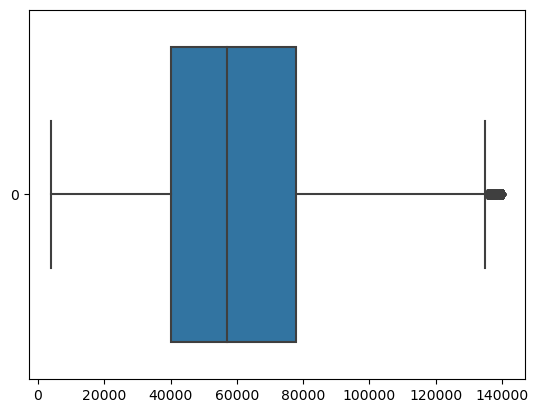

In [182]:
sns.boxplot(loan_df['annual_inc'], orient='h')

<p> The box plot for annual_inc looks good after outlier treatment

#### last_pymnt_amnt

<Axes: >

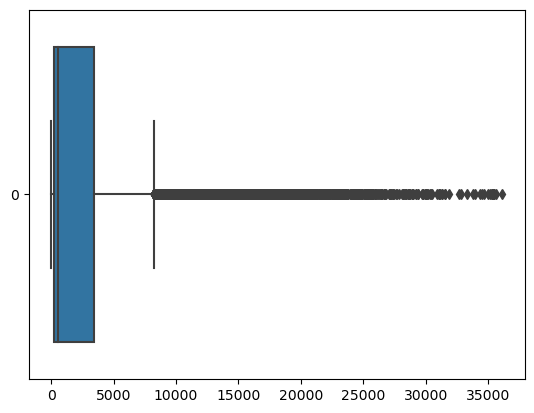

In [183]:
sns.boxplot(loan_df['last_pymnt_amnt'], orient='h')

In [184]:
quantile_info = loan_df.last_pymnt_amnt.quantile([0.5, 0.25, 0.50, 0.75, 0.80, 0.95, 0.97, 0.99])
quantile_info

0.50      563.4500
0.25      216.8775
0.50      563.4500
0.75     3414.9700
0.80     4531.8080
0.95    11874.8235
0.97    14630.1316
0.99    20262.5312
Name: last_pymnt_amnt, dtype: float64

In [185]:
len(loan_df[loan_df.last_pymnt_amnt > quantile_info[0.95]])

1720

In [186]:
loan_df = loan_df[loan_df.last_pymnt_amnt <= quantile_info[0.95]]

<Axes: >

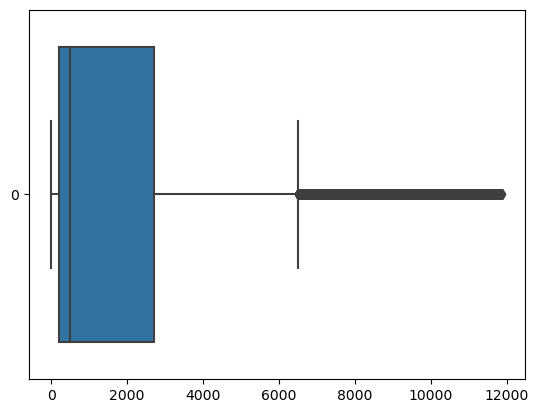

In [187]:
sns.boxplot(loan_df['last_pymnt_amnt'], orient='h')

<Axes: xlabel='last_pymnt_amnt', ylabel='Count'>

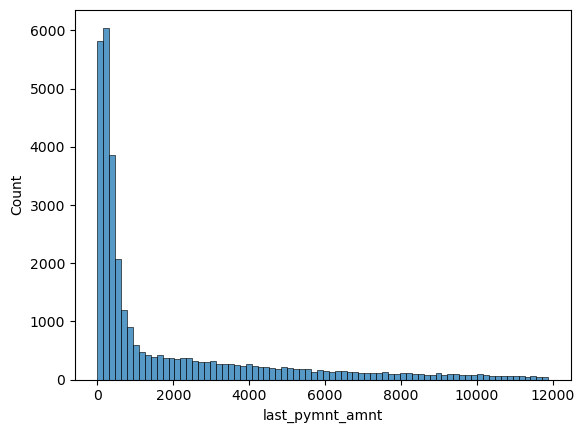

In [188]:
sns.histplot(loan_df['last_pymnt_amnt'])

#### revol_bal

<Axes: >

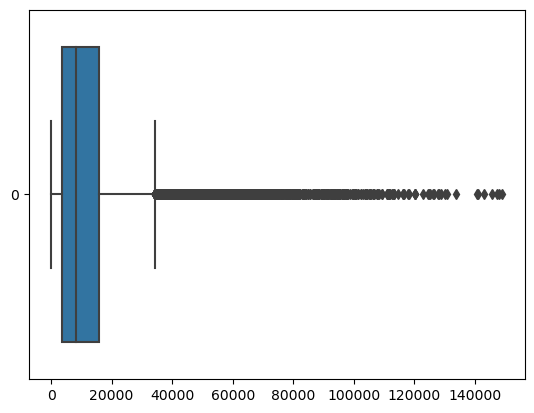

In [189]:
sns.boxplot(loan_df.revol_bal, orient='h')

In [190]:
quantile_info = loan_df.revol_bal.quantile([0.5, 0.25, 0.50, 0.75, 0.80, 0.95, 0.97, 0.99])
quantile_info

0.50     8359.00
0.25     3520.00
0.50     8359.00
0.75    15780.00
0.80    18160.60
0.95    35961.65
0.97    45011.98
0.99    68063.21
Name: revol_bal, dtype: float64

In [191]:
len(loan_df[loan_df.revol_bal > quantile_info[0.95]])

1634

In [192]:
loan_df = loan_df[loan_df.revol_bal <= quantile_info[0.95]]

<Axes: >

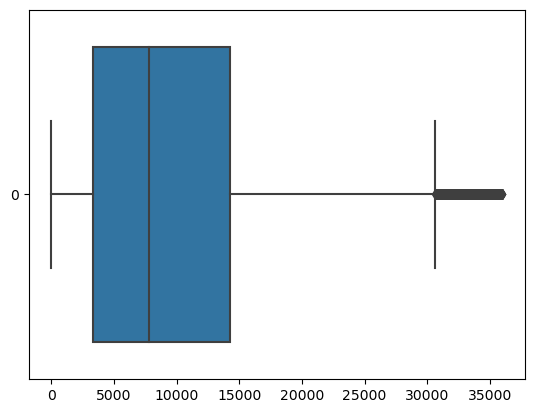

In [193]:
sns.boxplot(loan_df.revol_bal, orient='h')

#### We fixed outliers in annual_inc, last_pymnt_amnt and revol_bal


<br>As shown below, though there are outliers in rest of the columns the difference from the normal distribution is not that large

#### Not fixing loan_amnt, funded_amnt, funded_amnt_inv, int_rate, mths_since_last_delinq, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int


0.50     8500.0
0.25     5000.0
0.50     8500.0
0.75    13000.0
0.80    15000.0
0.95    23000.0
0.97    25000.0
0.99    30000.0
Name: loan_amnt, dtype: float64
1521


<Axes: >

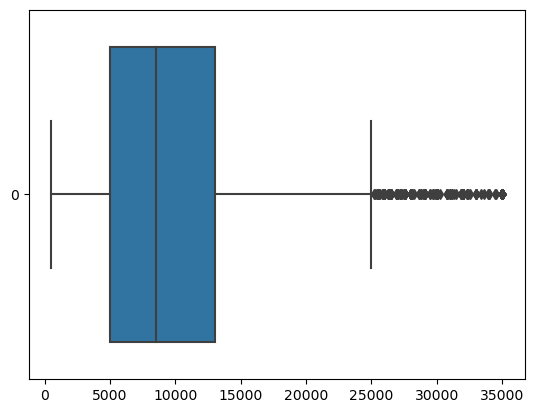

In [194]:
quantile_info = loan_df.loan_amnt.quantile([0.5, 0.25, 0.50, 0.75, 0.80, 0.95, 0.97, 0.99])
print(quantile_info)
print(len(loan_df[loan_df.loan_amnt > quantile_info[0.95]]))
sns.boxplot(loan_df.loan_amnt, orient='h')

0.50     8400.0
0.25     5000.0
0.50     8400.0
0.75    12800.0
0.80    14500.0
0.95    21000.0
0.97    25000.0
0.99    28000.0
Name: funded_amnt, dtype: float64
1541


<Axes: >

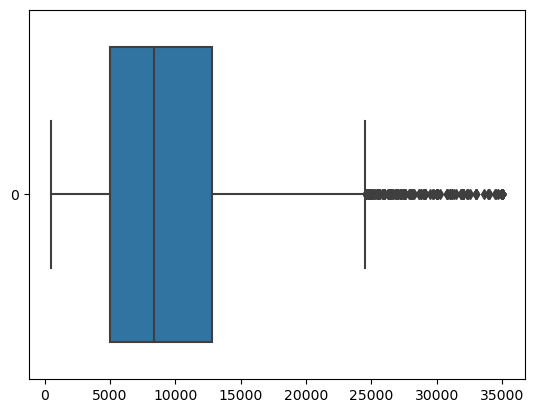

In [195]:
quantile_info = loan_df.funded_amnt.quantile([0.5, 0.25, 0.50, 0.75, 0.80, 0.95, 0.97, 0.99])
print(quantile_info)
print(len(loan_df[loan_df.funded_amnt > quantile_info[0.95]]))
sns.boxplot(loan_df.funded_amnt, orient='h')

0.50     8000.000000
0.25     4889.243026
0.50     8000.000000
0.75    12000.000000
0.80    13950.646148
0.95    20375.000000
0.97    23950.000000
0.99    27952.593502
Name: funded_amnt_inv, dtype: float64
1550


<Axes: >

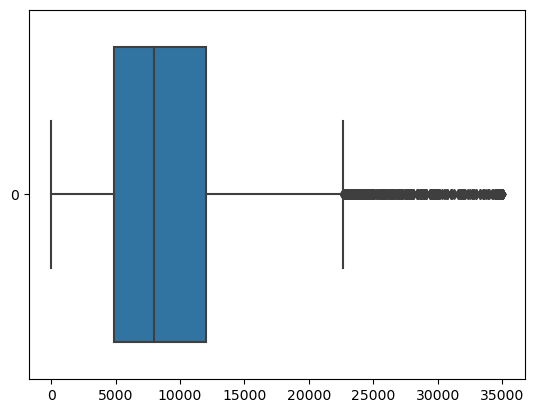

In [196]:
quantile_info = loan_df.funded_amnt_inv.quantile([0.5, 0.25, 0.50, 0.75, 0.80, 0.95, 0.97, 0.99])
print(quantile_info)
print(len(loan_df[loan_df.funded_amnt_inv > quantile_info[0.95]]))
sns.boxplot(loan_df.funded_amnt_inv, orient='h')

0.50    11.71
0.25     8.90
0.50    11.71
0.75    14.26
0.80    14.91
0.95    17.99
0.97    18.79
0.99    20.62
Name: int_rate, dtype: float64
1479


<Axes: >

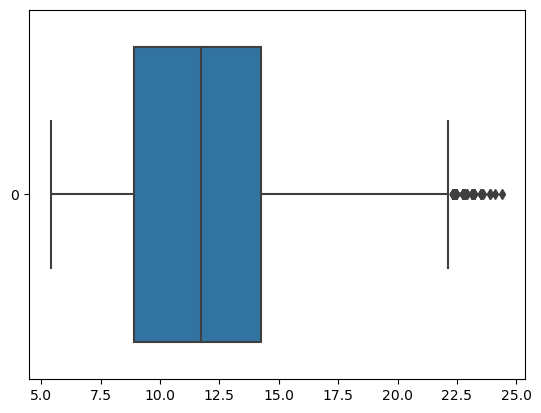

In [197]:
quantile_info = loan_df.int_rate.quantile([0.5, 0.25, 0.50, 0.75, 0.80, 0.95, 0.97, 0.99])
print(quantile_info)
print(len(loan_df[loan_df.int_rate > quantile_info[0.95]]))
sns.boxplot(loan_df.int_rate, orient='h')

0.50     0.0
0.25     0.0
0.50     0.0
0.75    22.0
0.80    31.0
0.95    64.0
0.97    71.0
0.99    78.0
Name: mths_since_last_delinq, dtype: float64
1523


<Axes: >

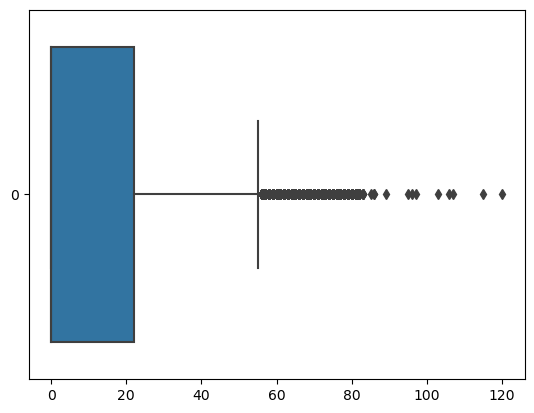

In [198]:
quantile_info = loan_df.mths_since_last_delinq.quantile([0.5, 0.25, 0.50, 0.75, 0.80, 0.95, 0.97, 0.99])
print(quantile_info)
print(len(loan_df[loan_df.mths_since_last_delinq > quantile_info[0.95]]))
sns.boxplot(loan_df.mths_since_last_delinq, orient='h')

0.50     7450.0
0.25     4100.0
0.50     7450.0
0.75    12000.0
0.80    12950.0
0.95    20000.0
0.97    22400.0
0.99    25000.0
Name: total_rec_prncp, dtype: float64
1240


<Axes: >

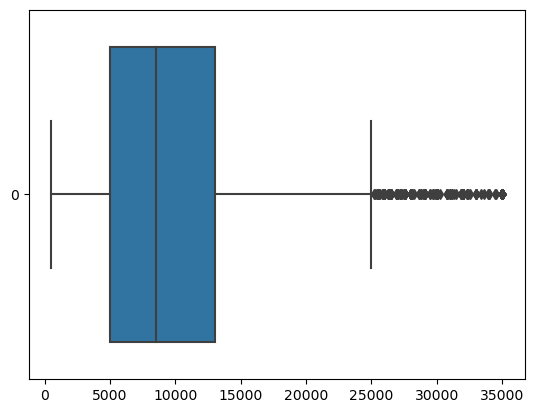

In [199]:
quantile_info = loan_df.total_rec_prncp.quantile([0.5, 0.25, 0.50, 0.75, 0.80, 0.95, 0.97, 0.99])
print(quantile_info)
print(len(loan_df[loan_df.total_rec_prncp > quantile_info[0.95]]))
sns.boxplot(loan_df.loan_amnt, orient='h')

0.50     1226.1000
0.25      621.7600
0.50     1226.1000
0.75     2413.5475
0.80     2843.0960
0.95     6014.9890
0.97     7340.5818
0.99    10206.4809
Name: total_rec_int, dtype: float64
1552


<Axes: >

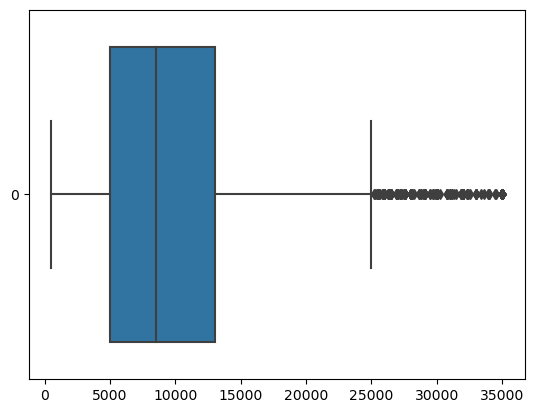

In [200]:
quantile_info = loan_df.total_rec_int.quantile([0.5, 0.25, 0.50, 0.75, 0.80, 0.95, 0.97, 0.99])
print(quantile_info)
print(len(loan_df[loan_df.total_rec_int > quantile_info[0.95]]))
sns.boxplot(loan_df.loan_amnt, orient='h')

## Univariate analysis of categorical variables

In [201]:
for i in categorical:
    print(len(loan_df[i].unique()), '\t', i)

2 	 term
24565 	 emp_title
806 	 zip_code
50 	 addr_state
3 	 verification_status
55 	 issue_d
105 	 last_credit_pull_d
2 	 loan_status
14 	 purpose
7 	 grade
35 	 sub_grade
5 	 home_ownership
500 	 earliest_cr_line


#### As the total numer of unique values for emp_title, zip_code, earliest_cr_line are too large to fit on the countplot, picking top 50 for analysis

In [202]:
def PlotFirst50Categorical(column):
    result = []
    df_temp = loan_df.groupby(column) # Group by column name 
    
    for key,item in df_temp:
        temp = {}
        temp[column] = key 
        temp['Count'] = item[column].count() # Find length of column
        result.append(temp)
    
    df_result = pd.DataFrame(result) # Create data frame

    df_plot = df_result.nlargest(50,['Count']) # Finding top 50 counts in the dataframe 

    plt.figure(figsize=(20, 15))
    plt.title(column)

    sns.barplot(x=column, y='Count', data=df_plot) # Plot

    plt.xticks(rotation=90)
    plt.show()

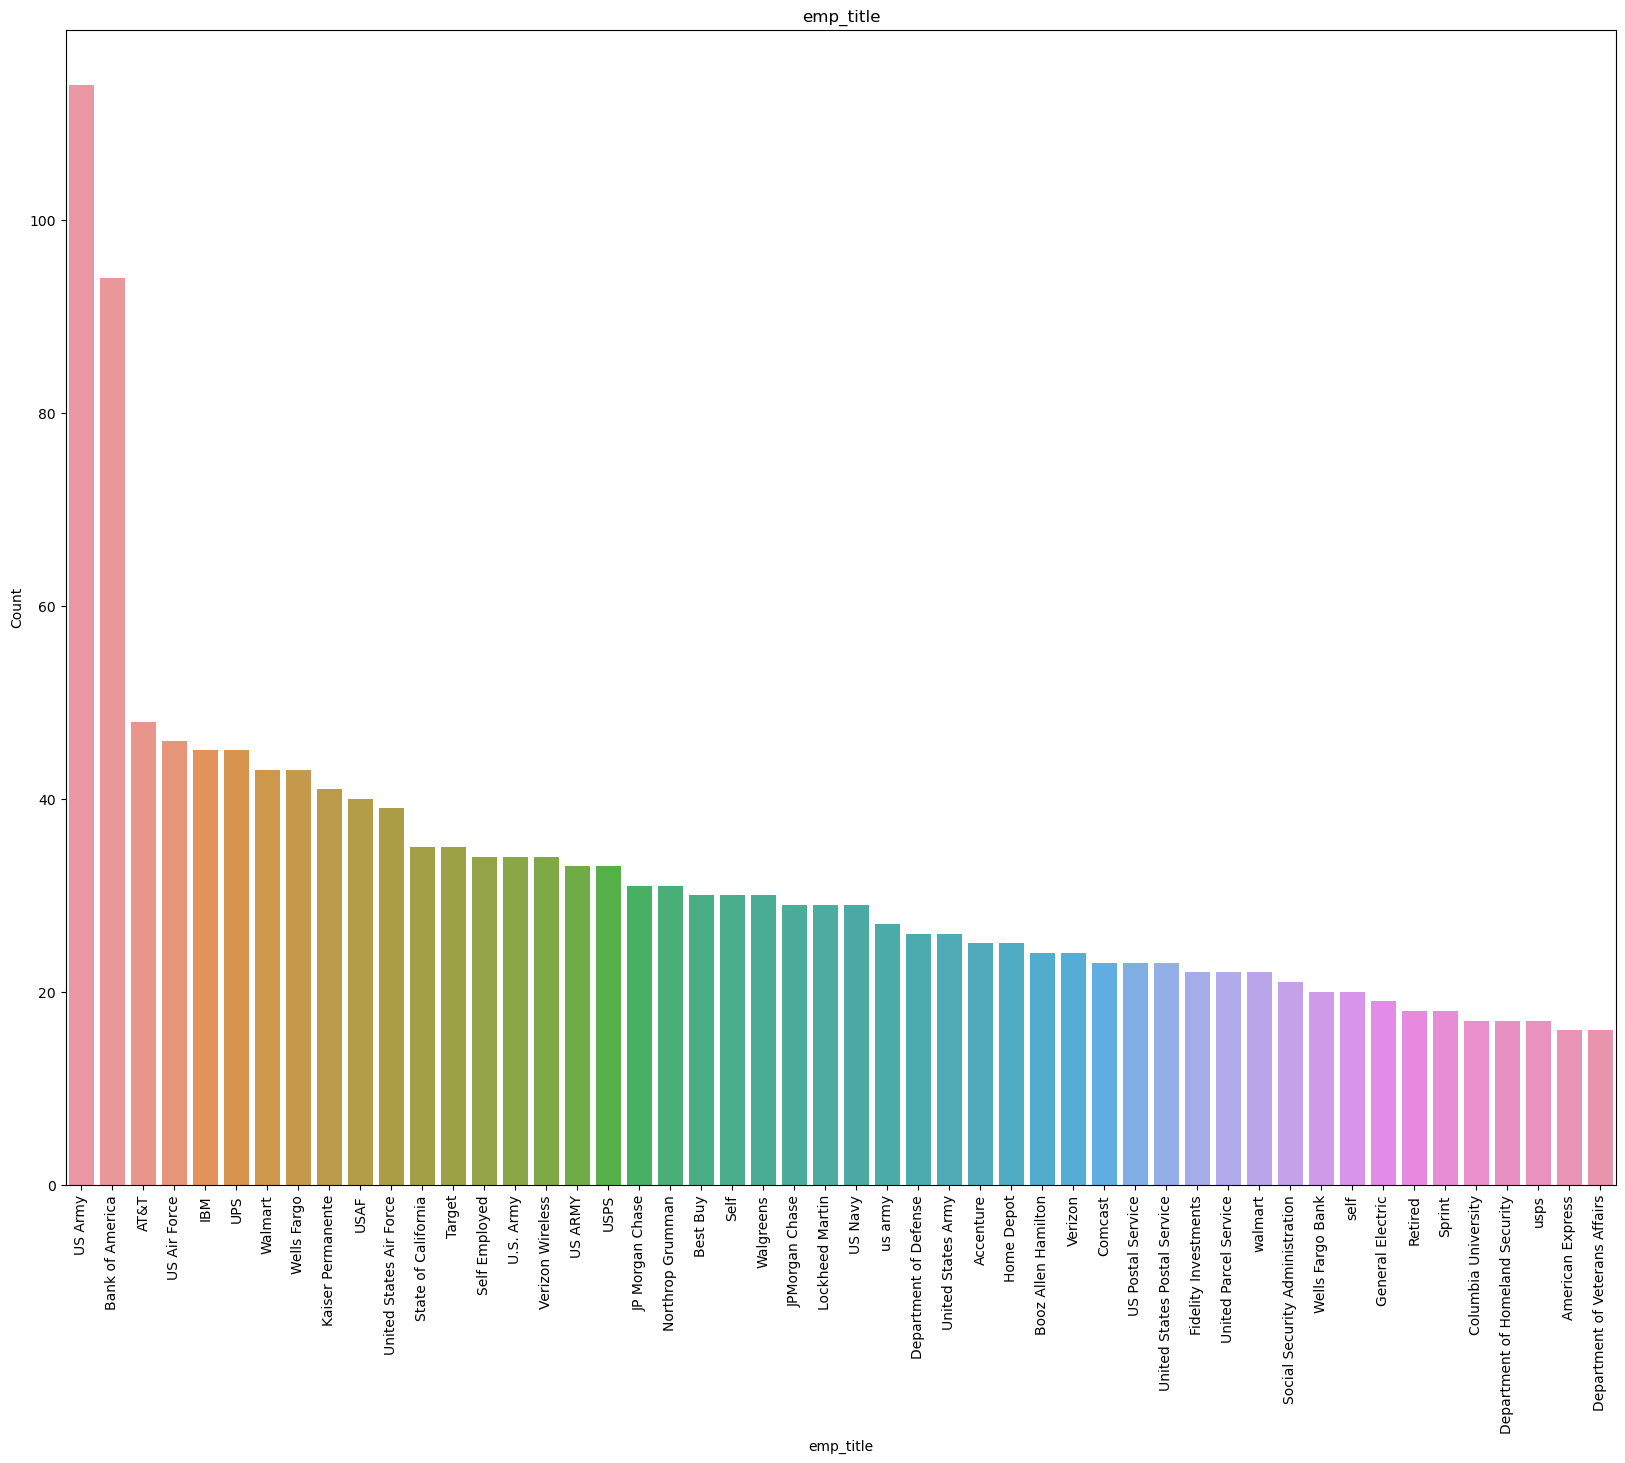

In [203]:
PlotFirst50Categorical('emp_title')

In [204]:
categorical.remove('emp_title')

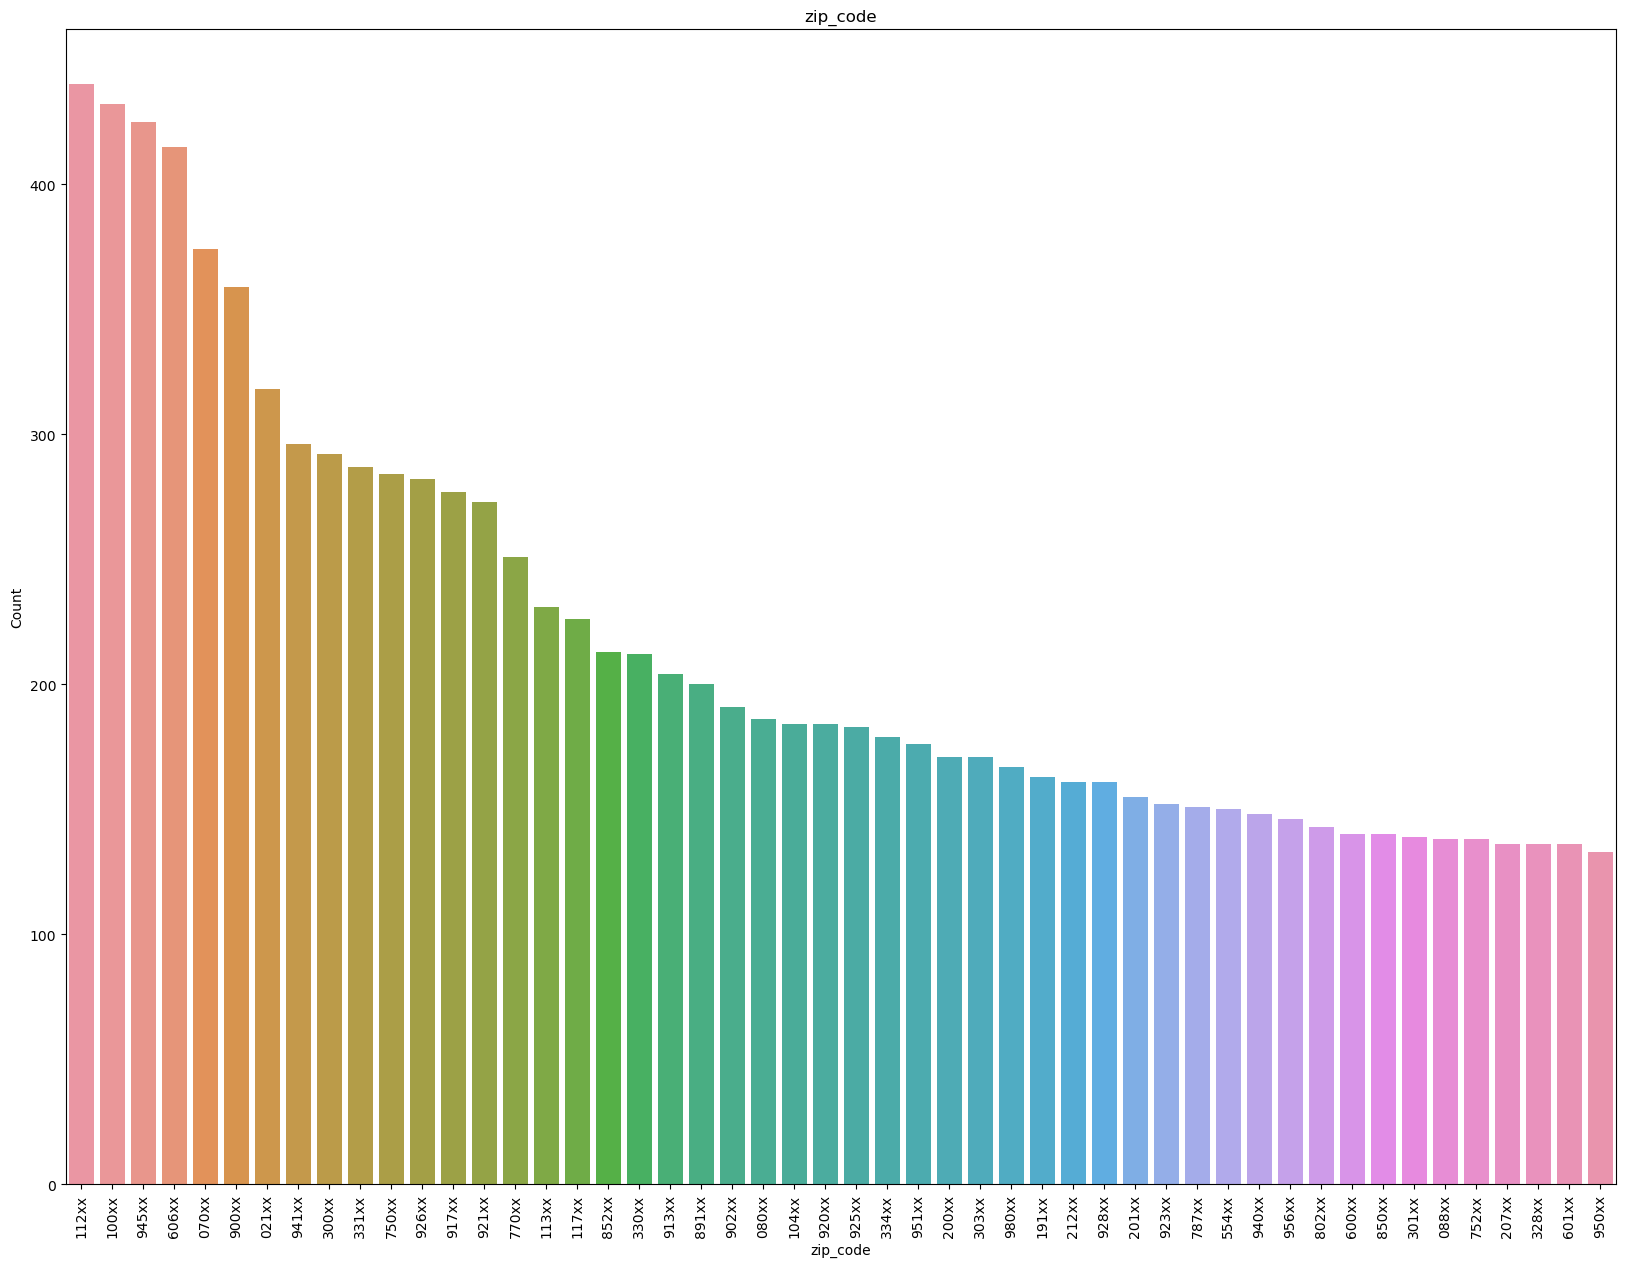

In [205]:
PlotFirst50Categorical('zip_code')

In [206]:
categorical.remove('zip_code')

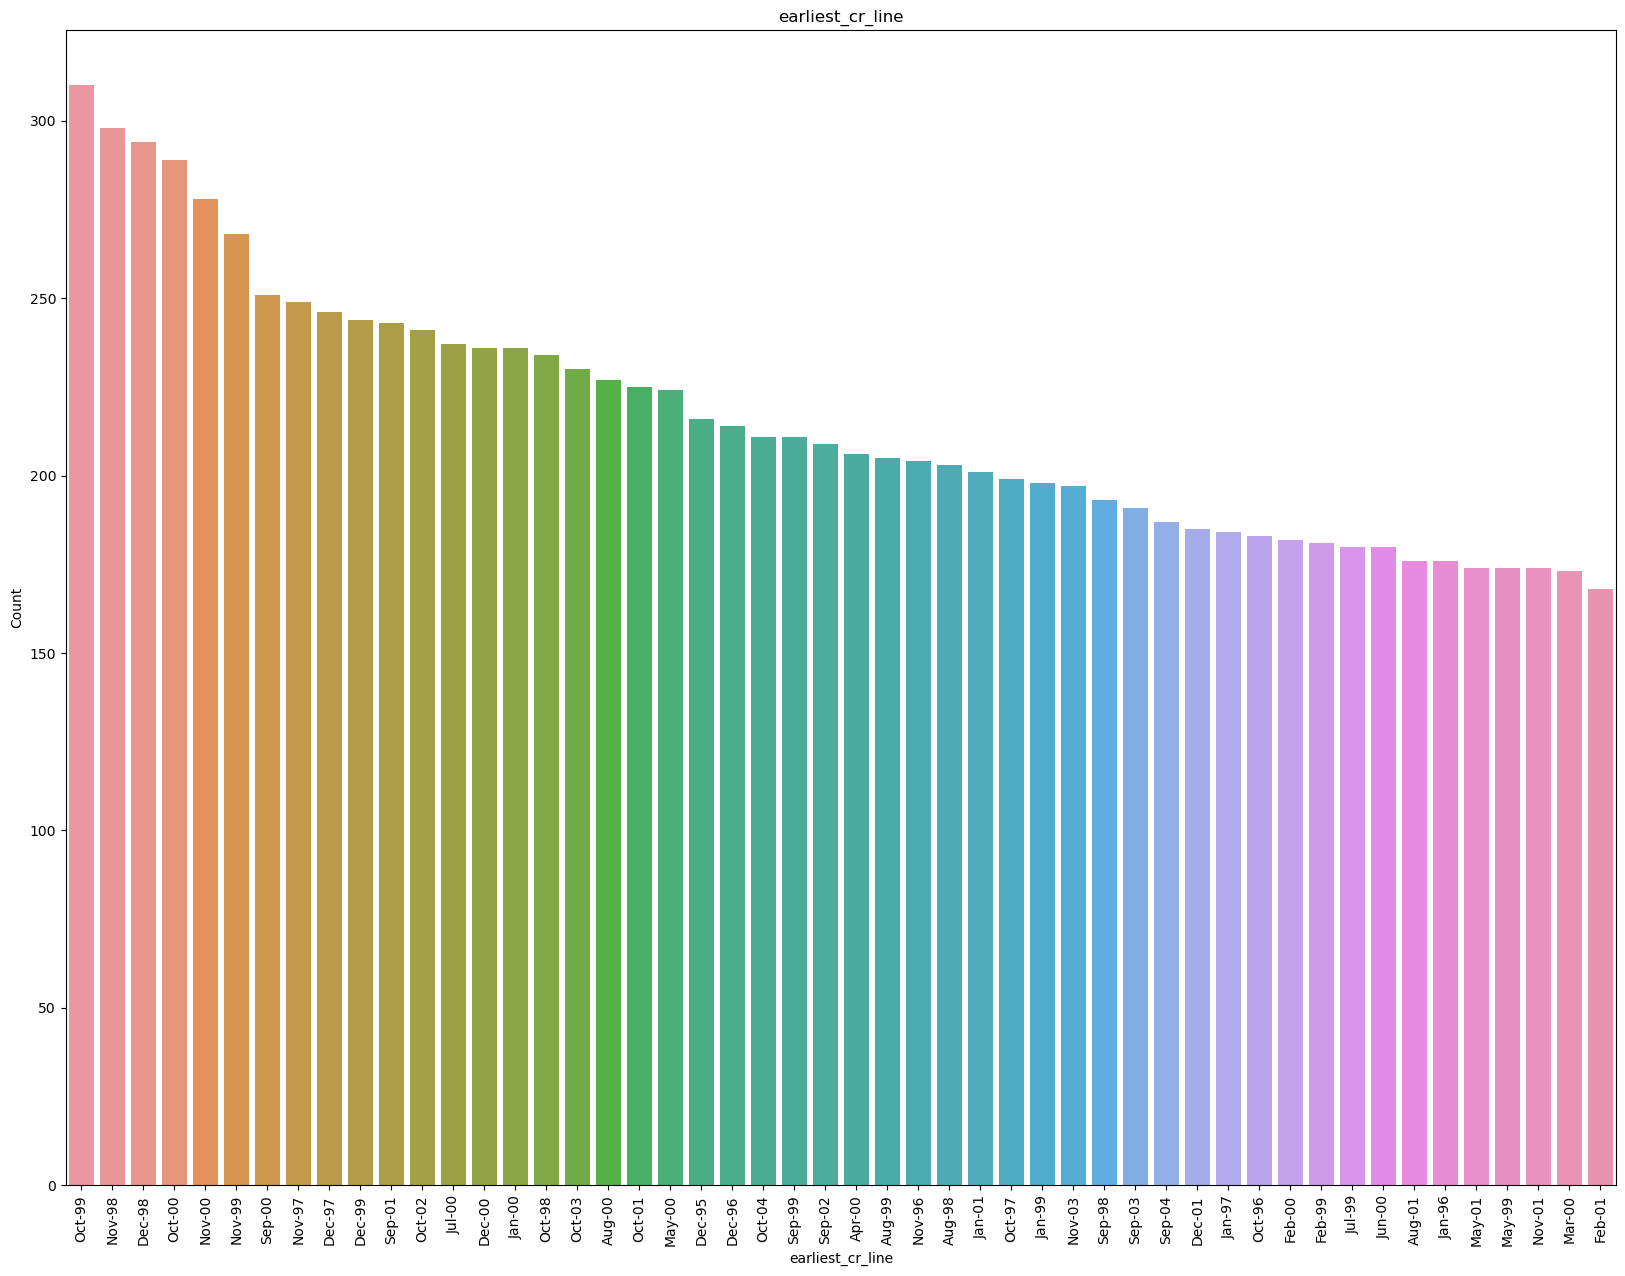

In [207]:
PlotFirst50Categorical('earliest_cr_line')

In [208]:
categorical.remove('earliest_cr_line')

#### Rendering count plots for rest of the columns

In [209]:
def plot_univariate_analysis_categorical(column_name):    
    plt.figure(figsize=(20, 15))
    plt.title(column_name)
    
    sns.countplot(x = column_name, data = loan_df)
            
    plt.xticks(rotation=90)
    plt.show()    


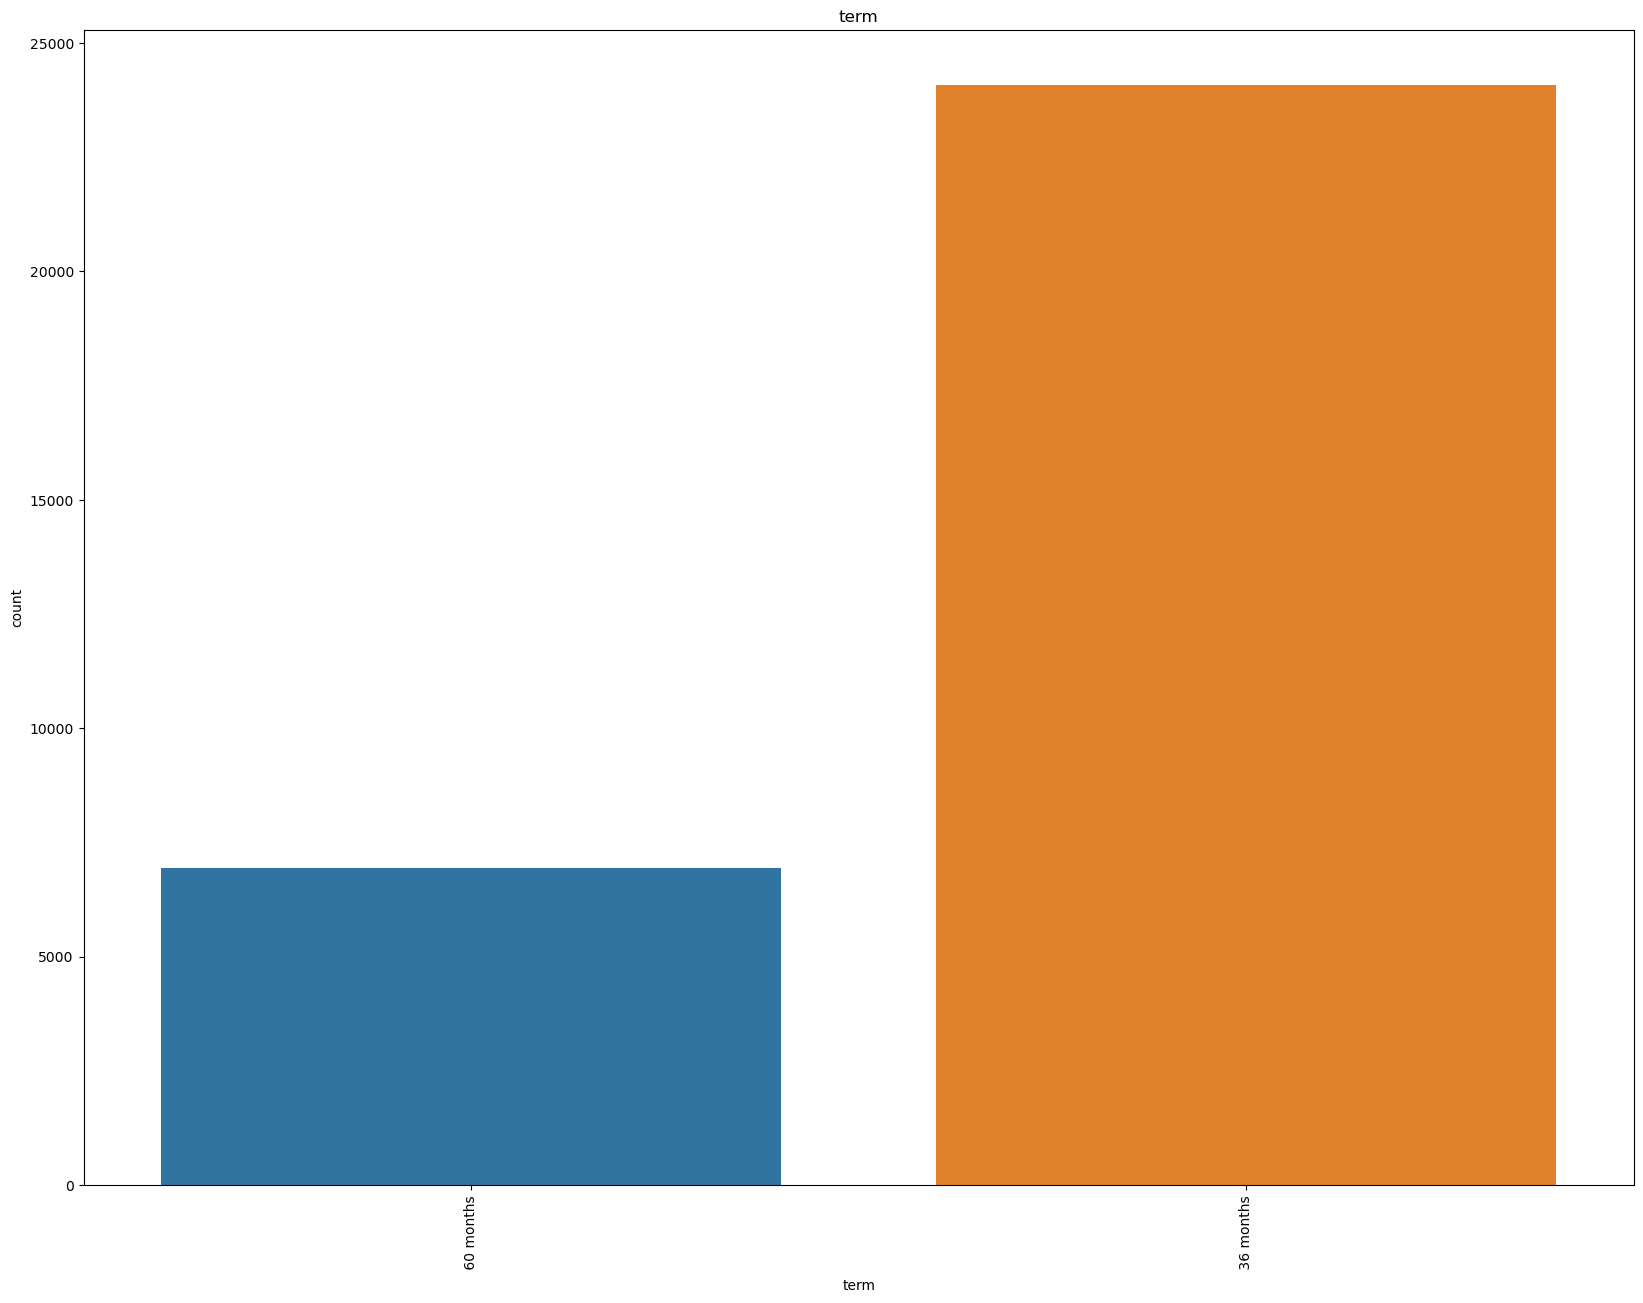

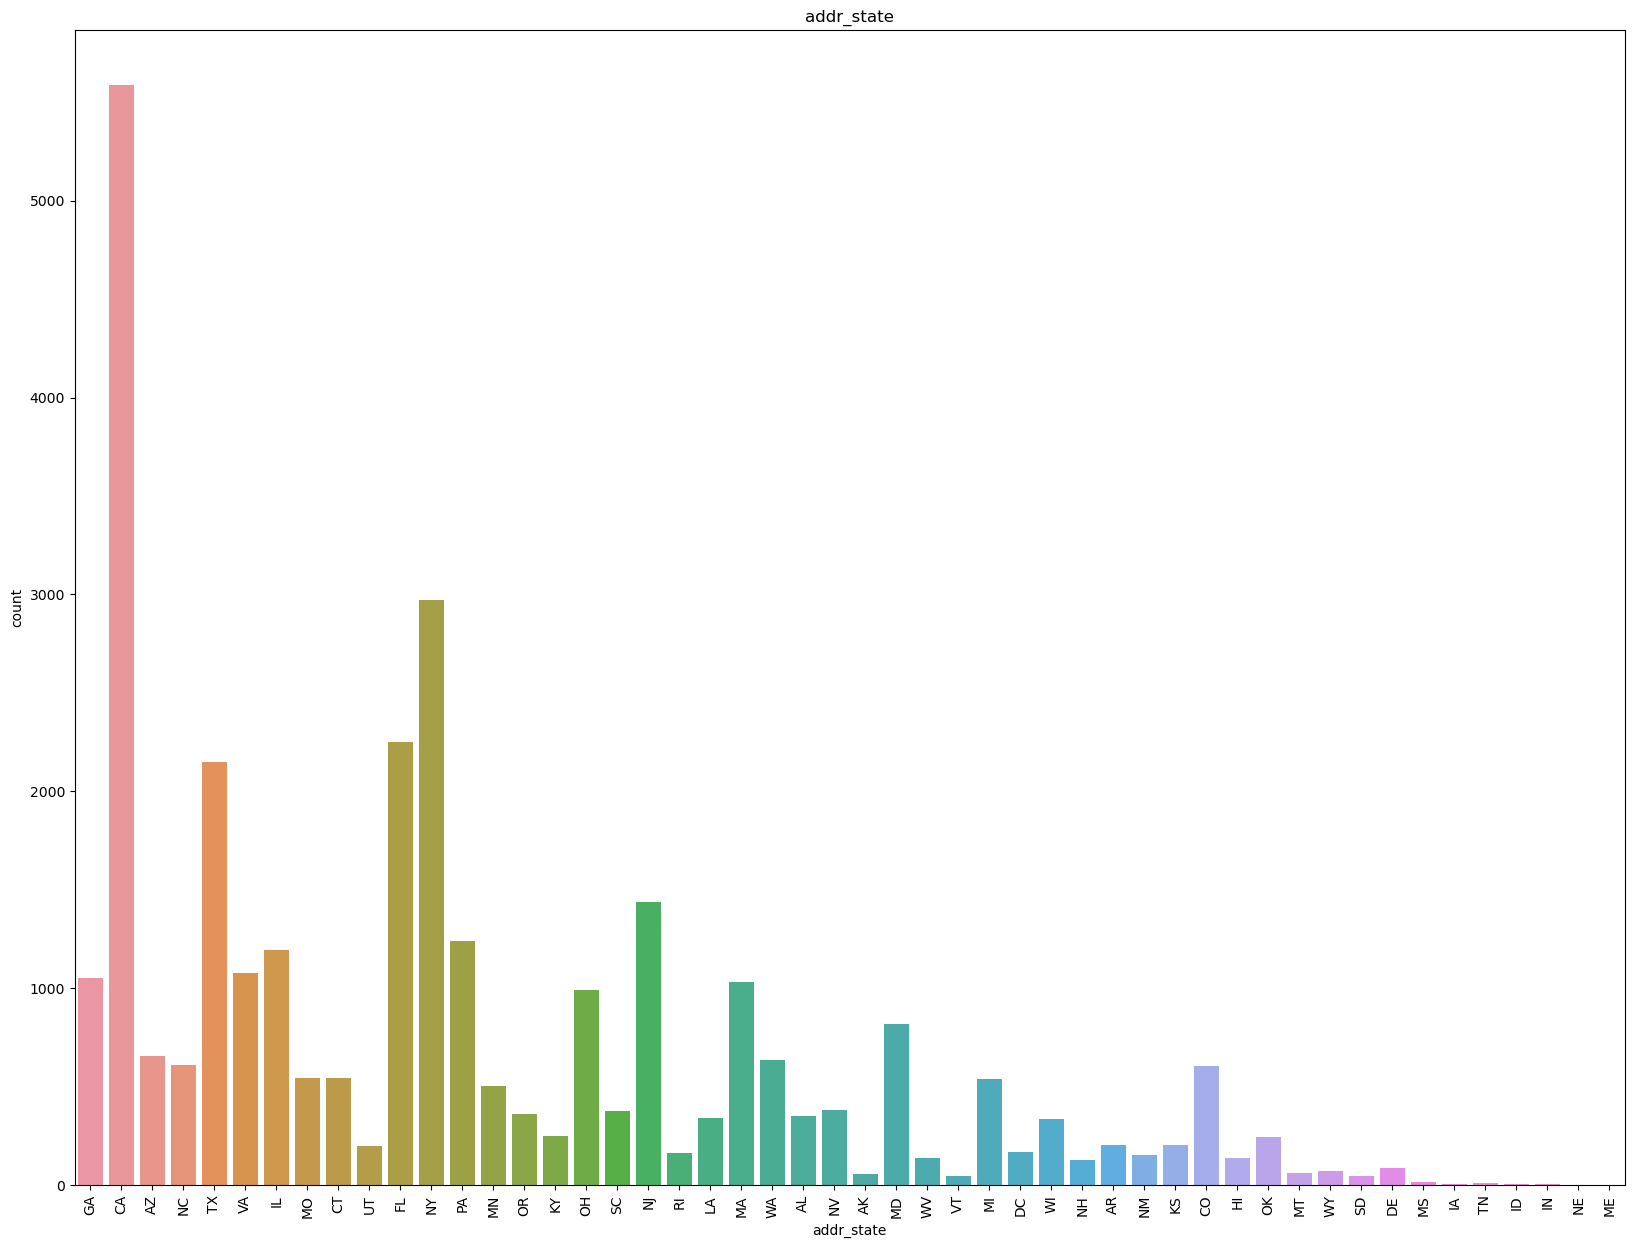

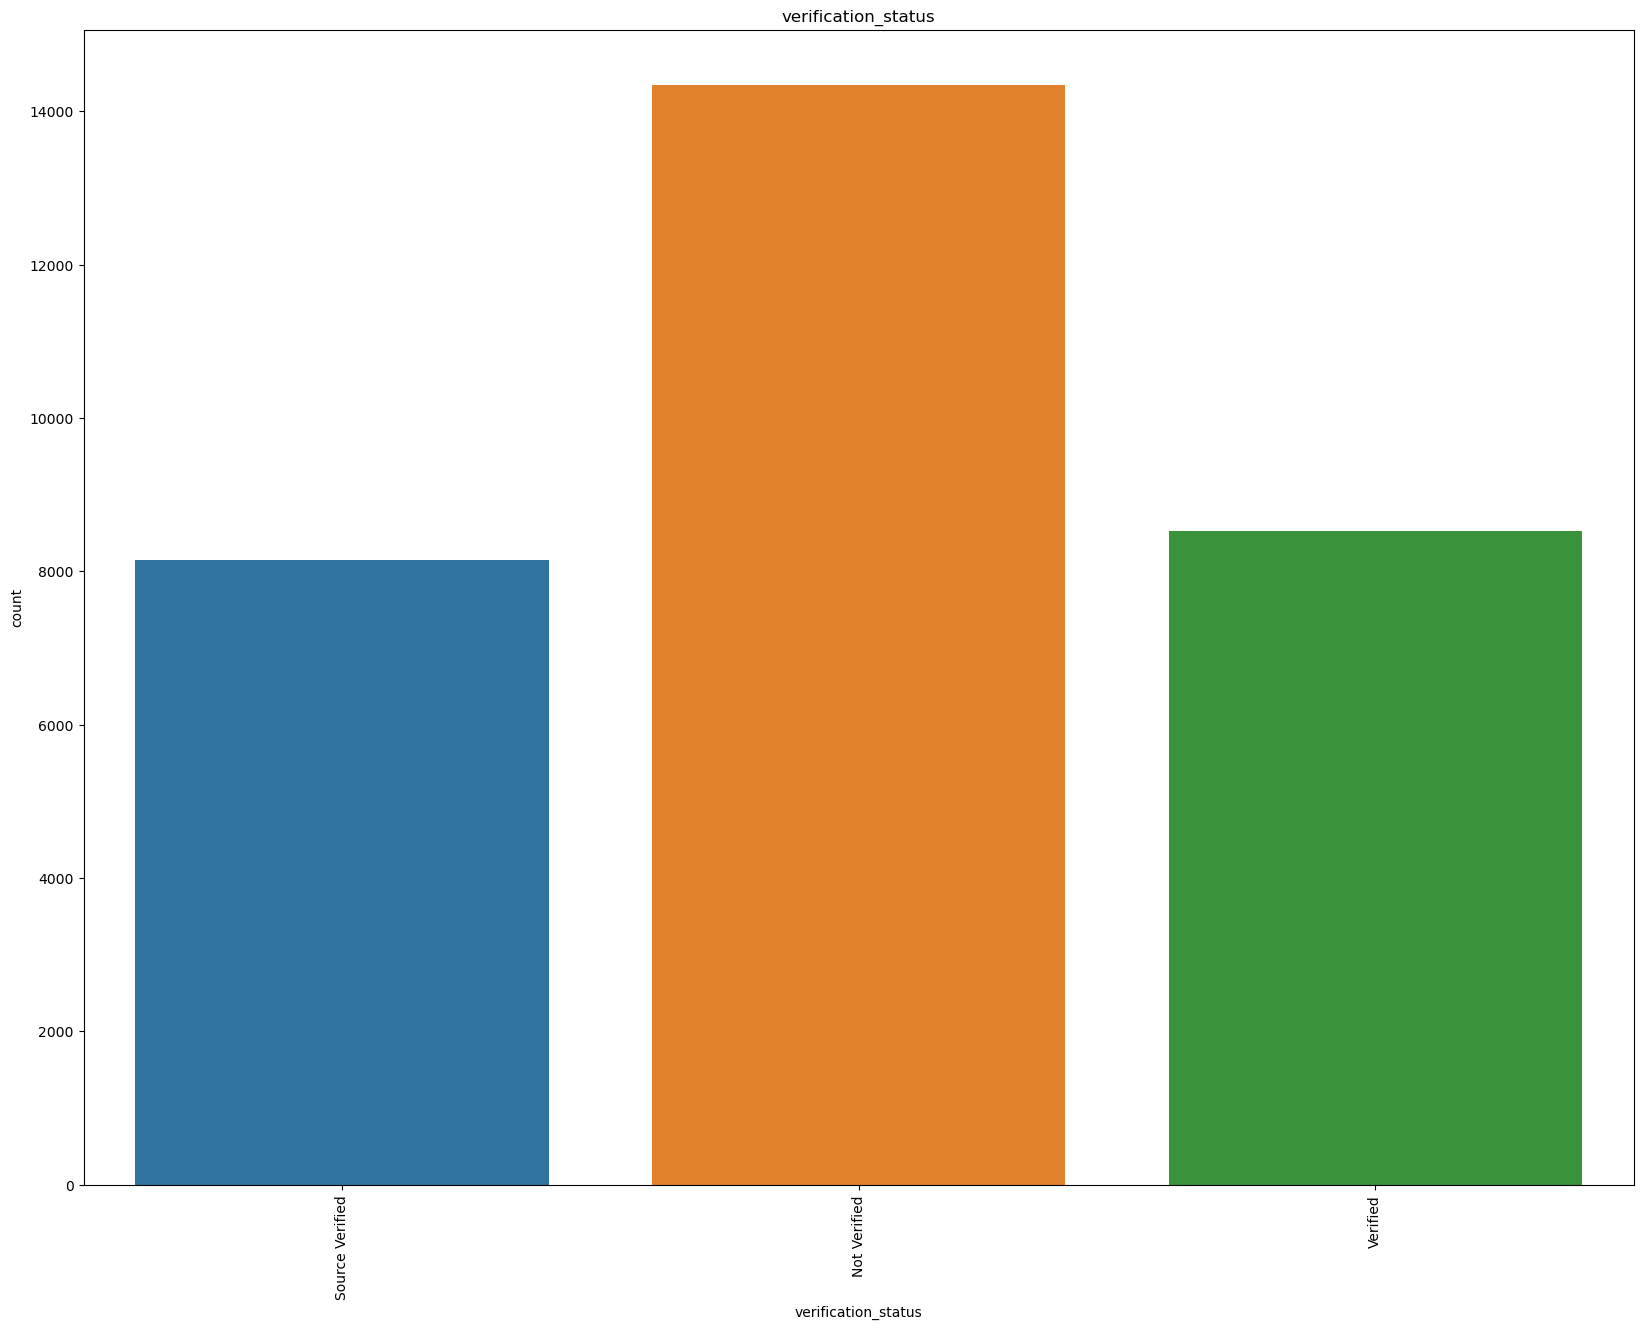

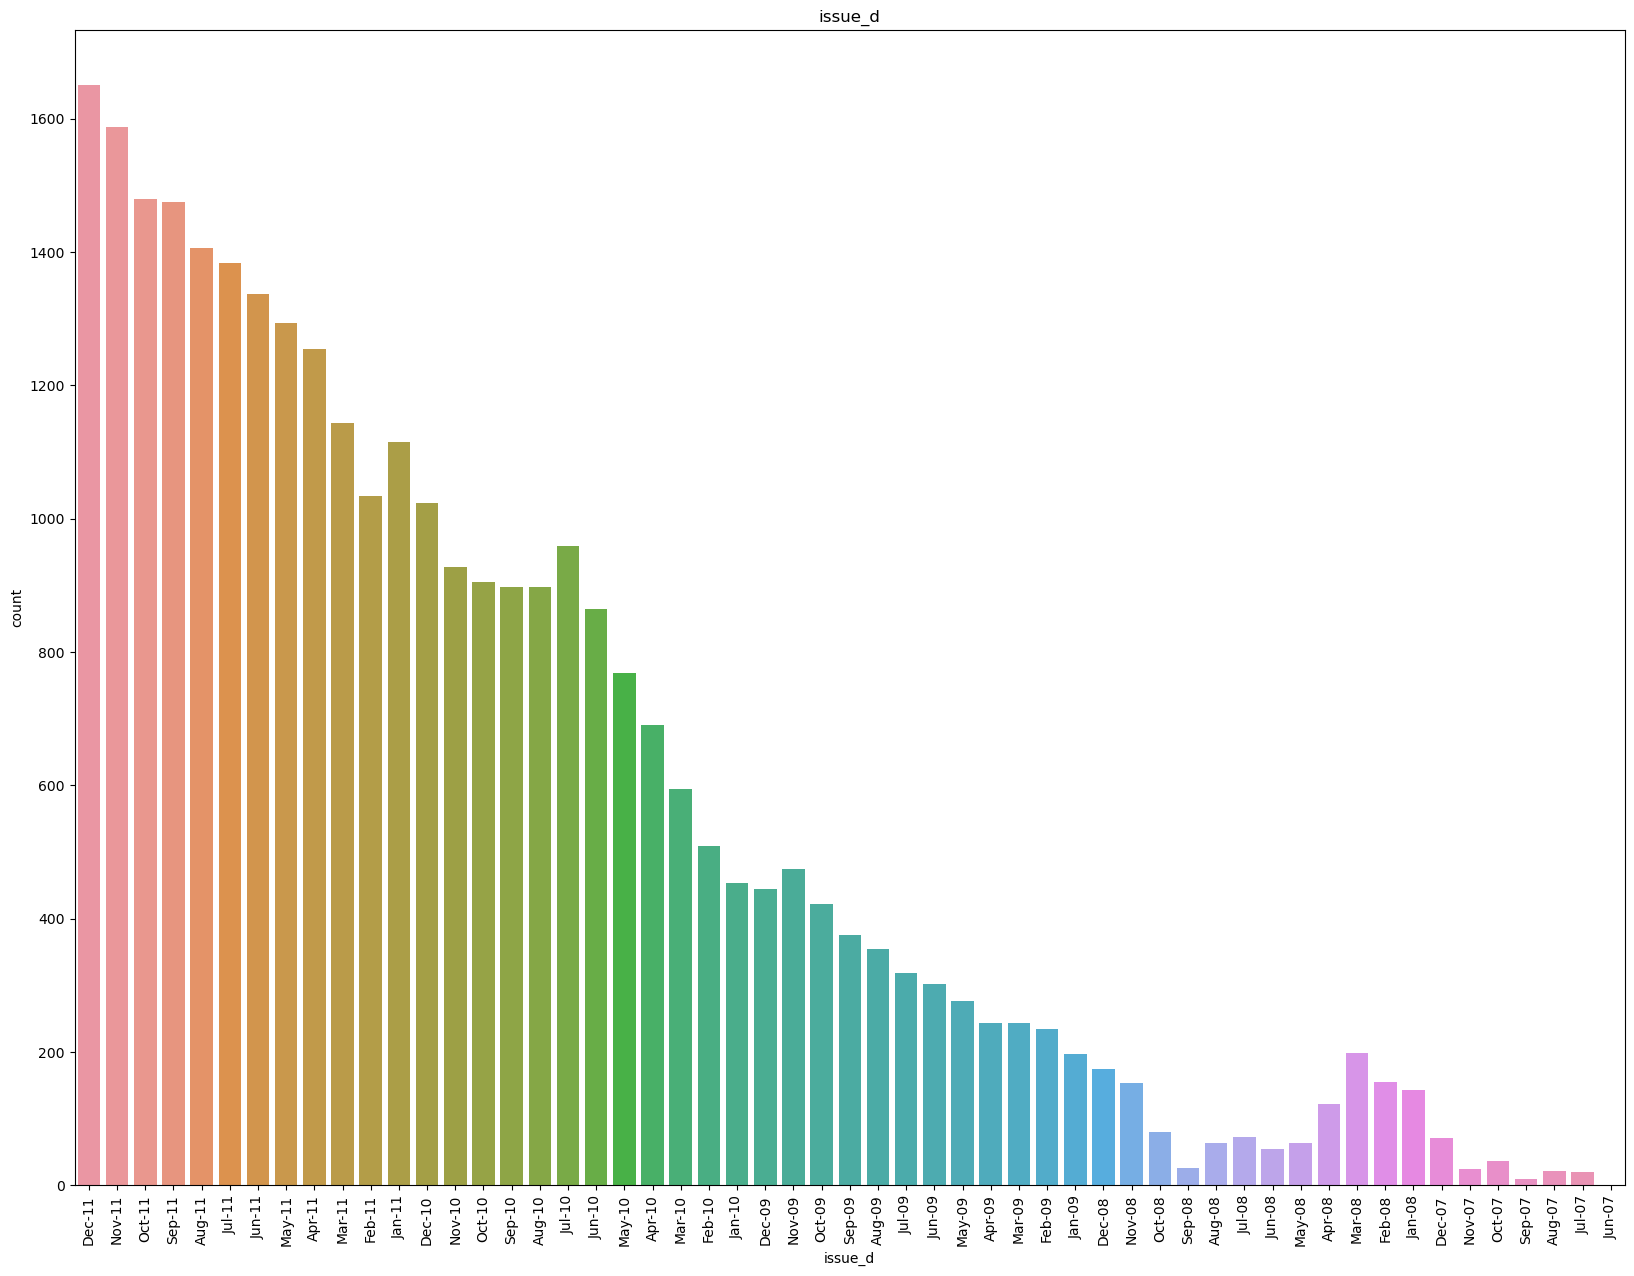

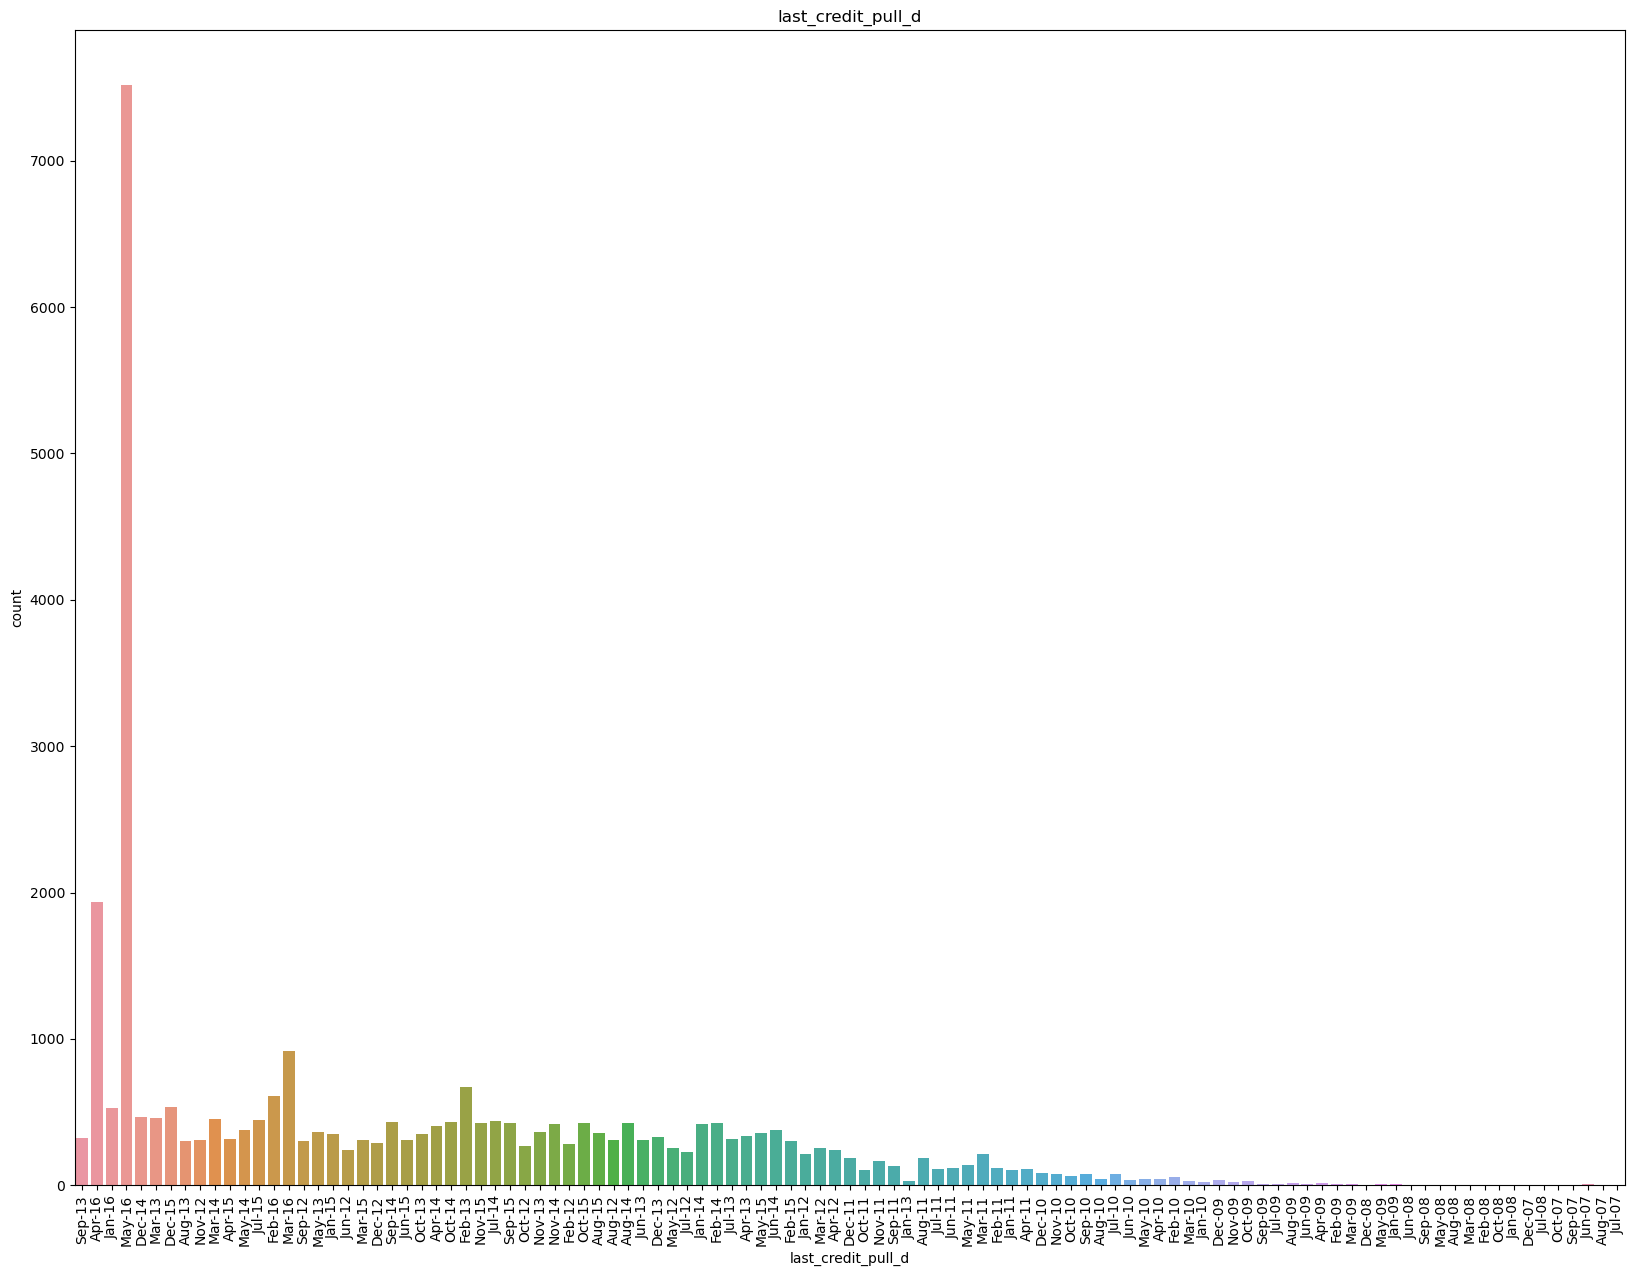

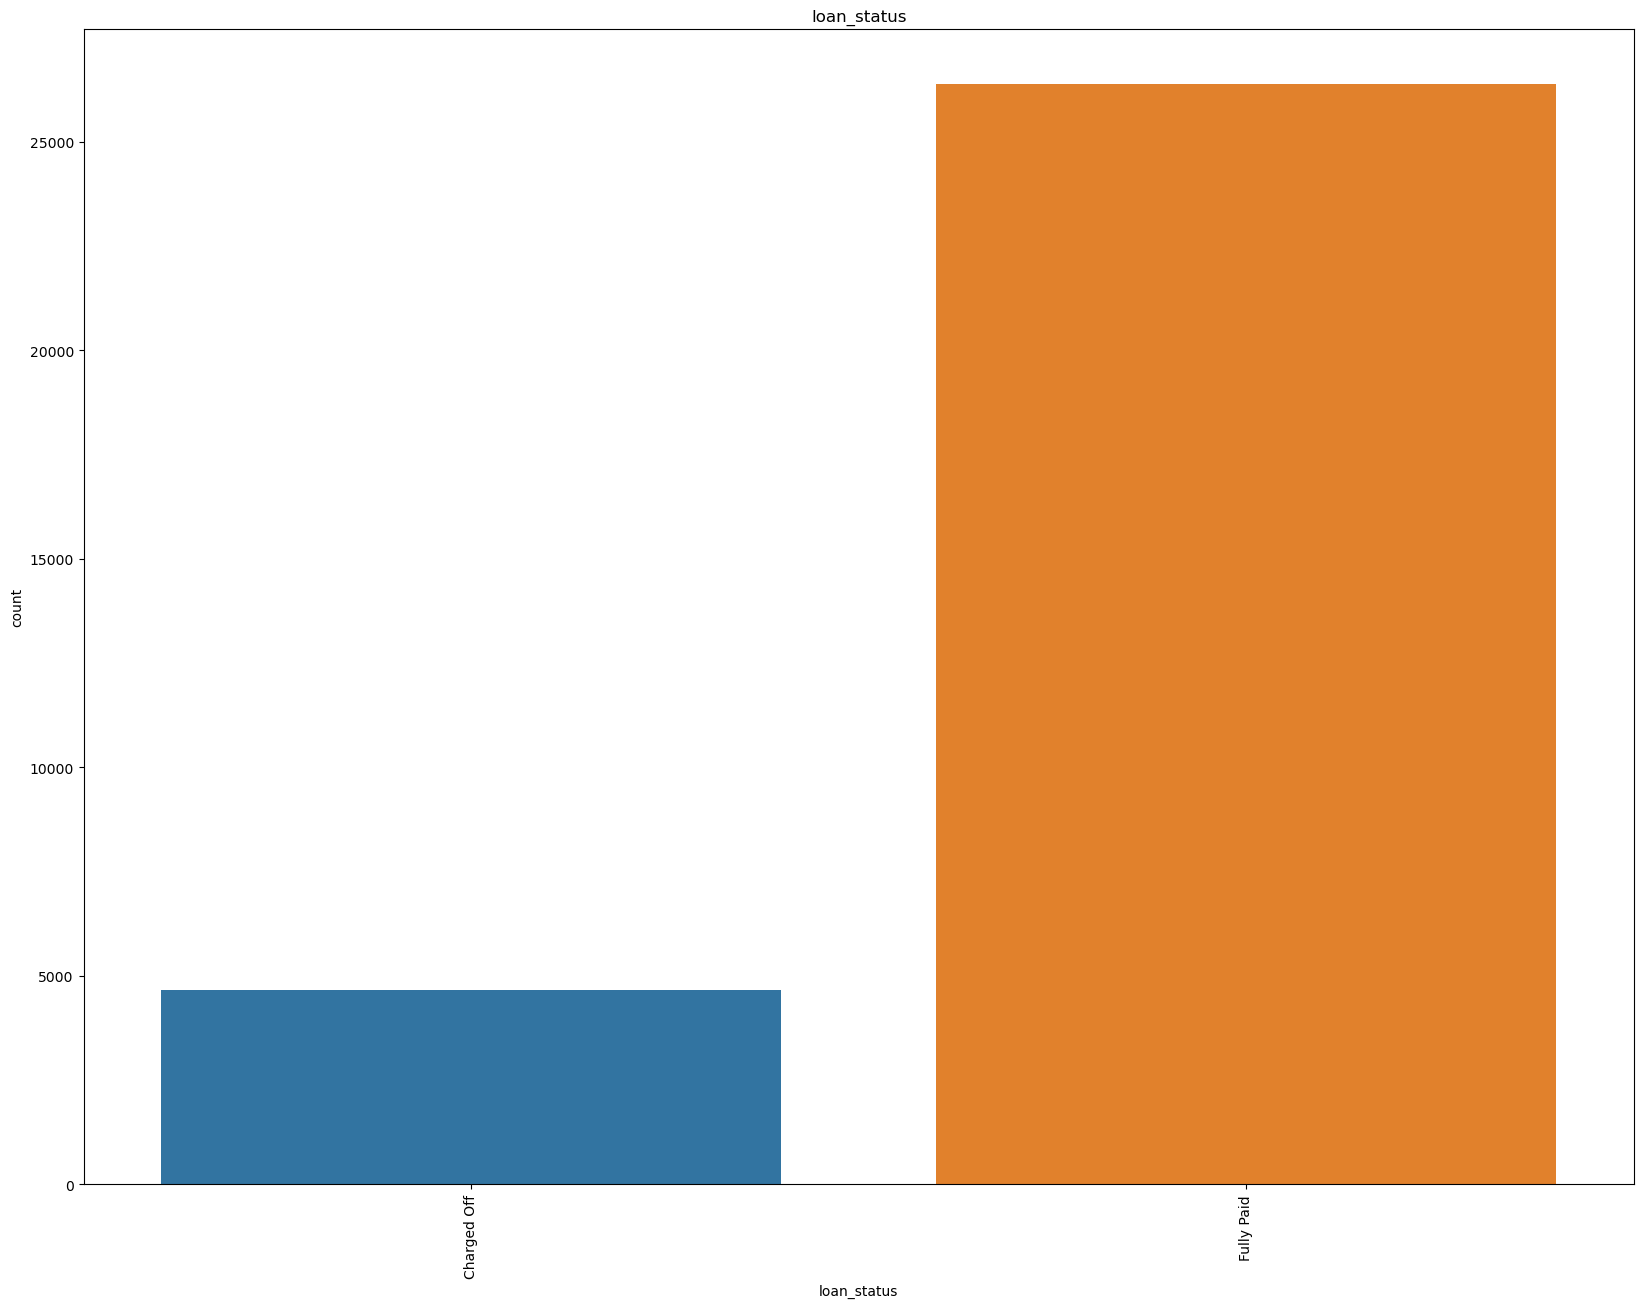

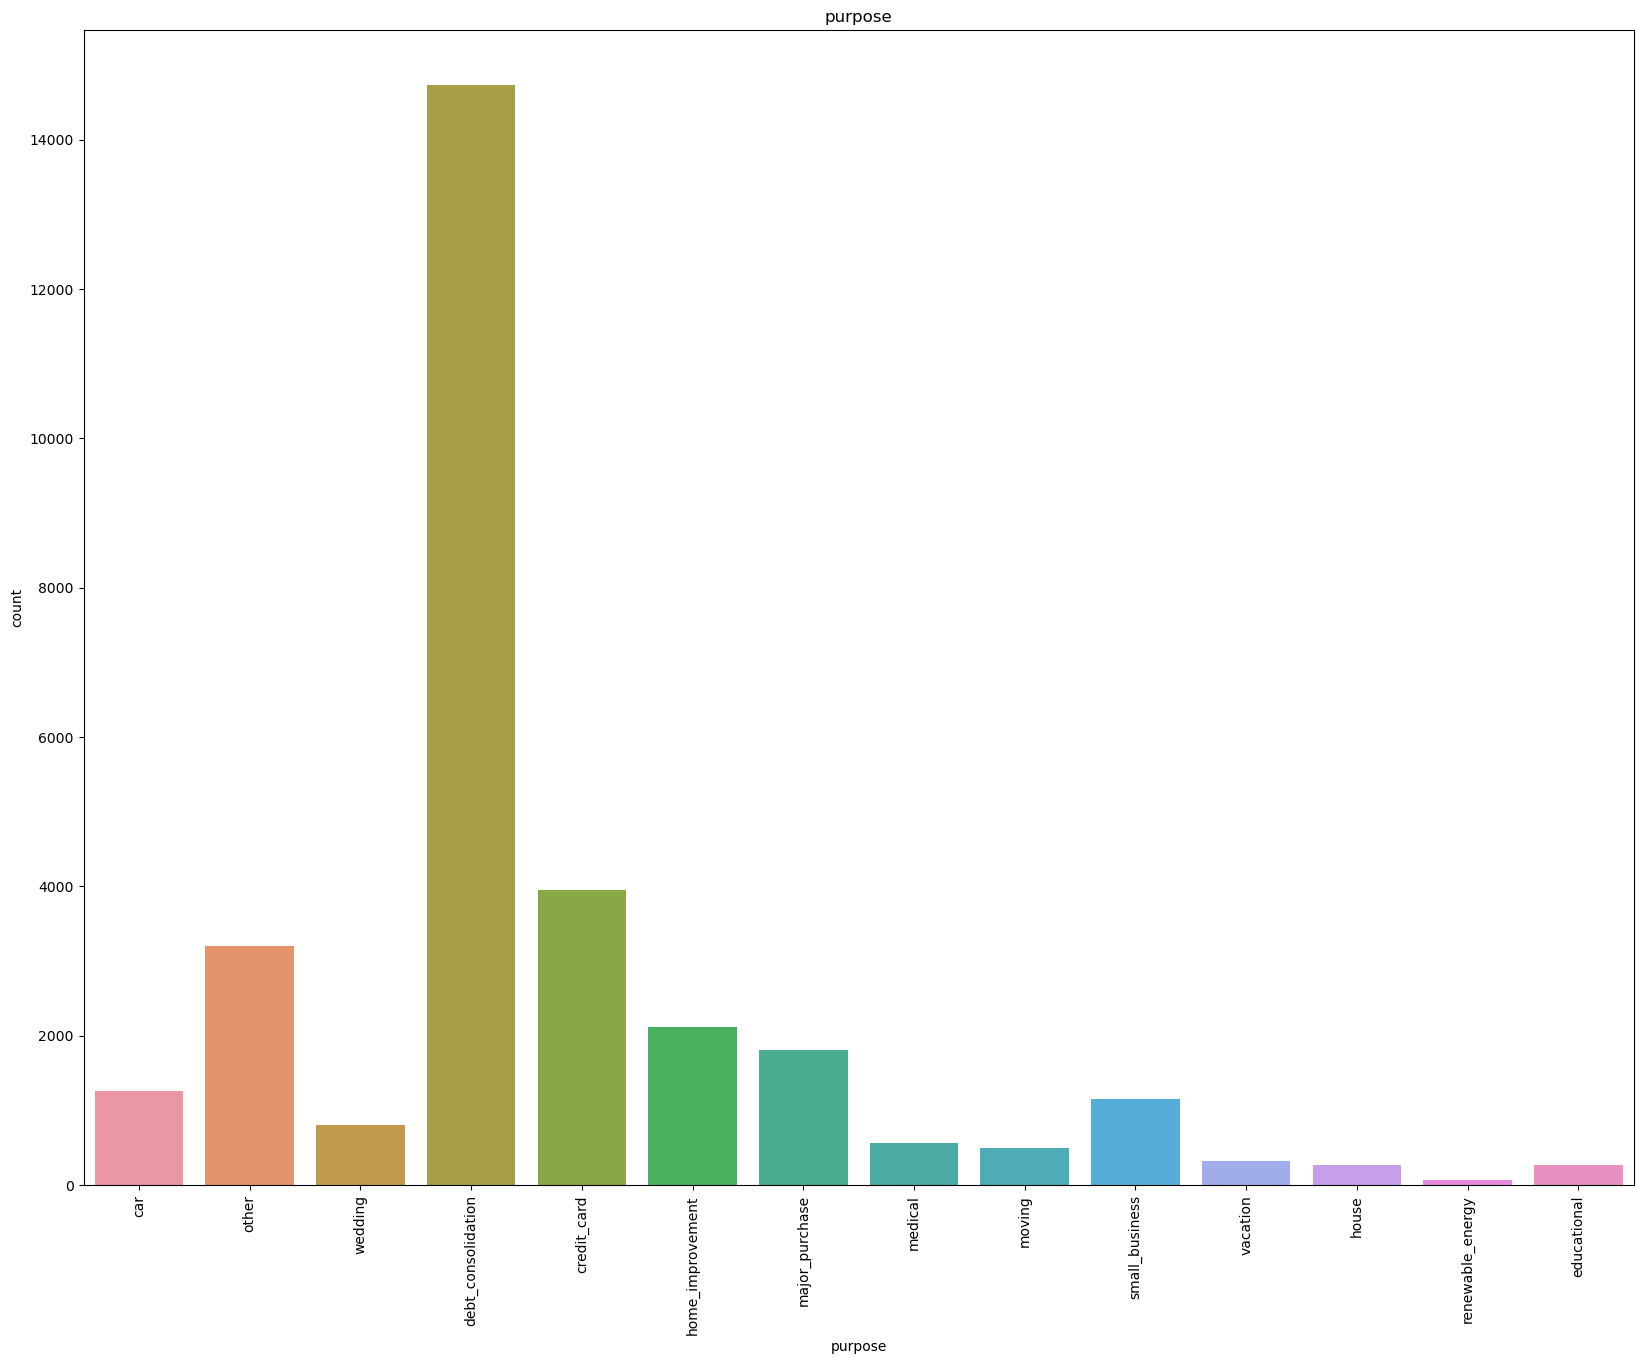

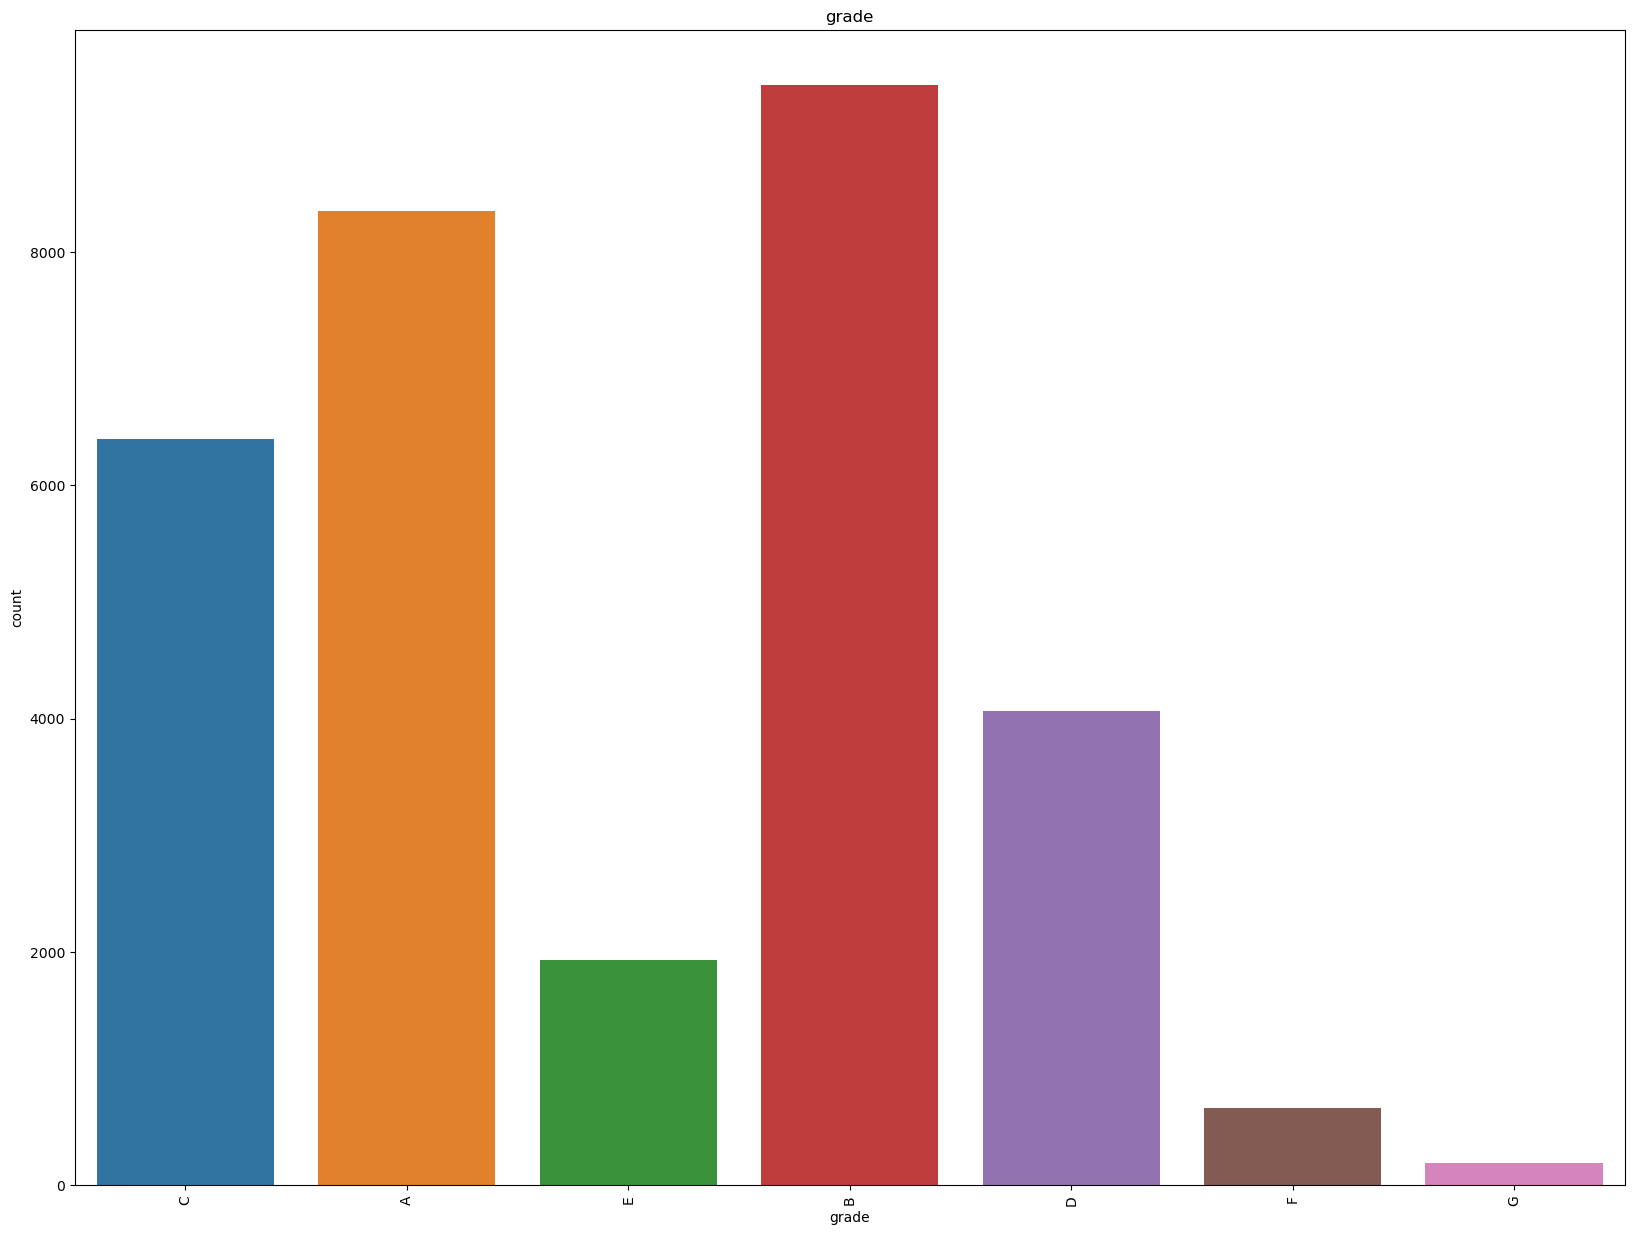

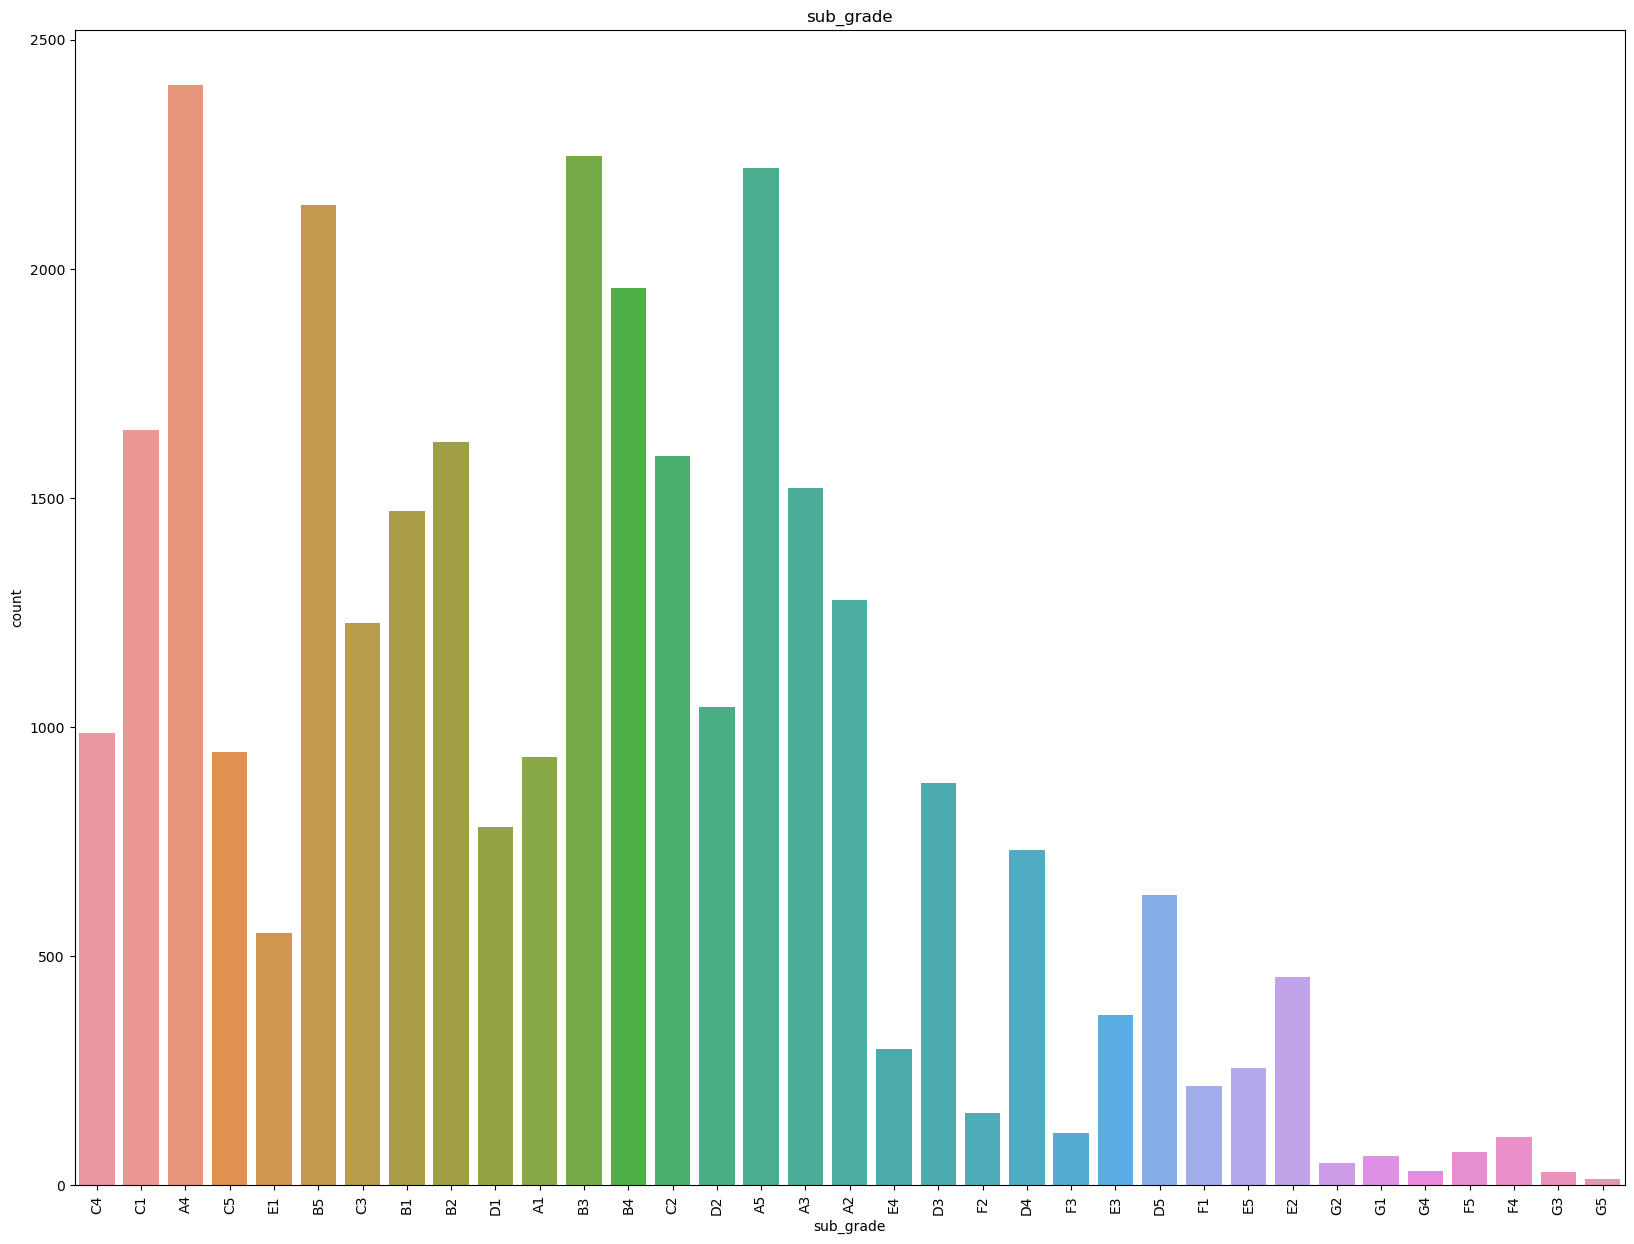

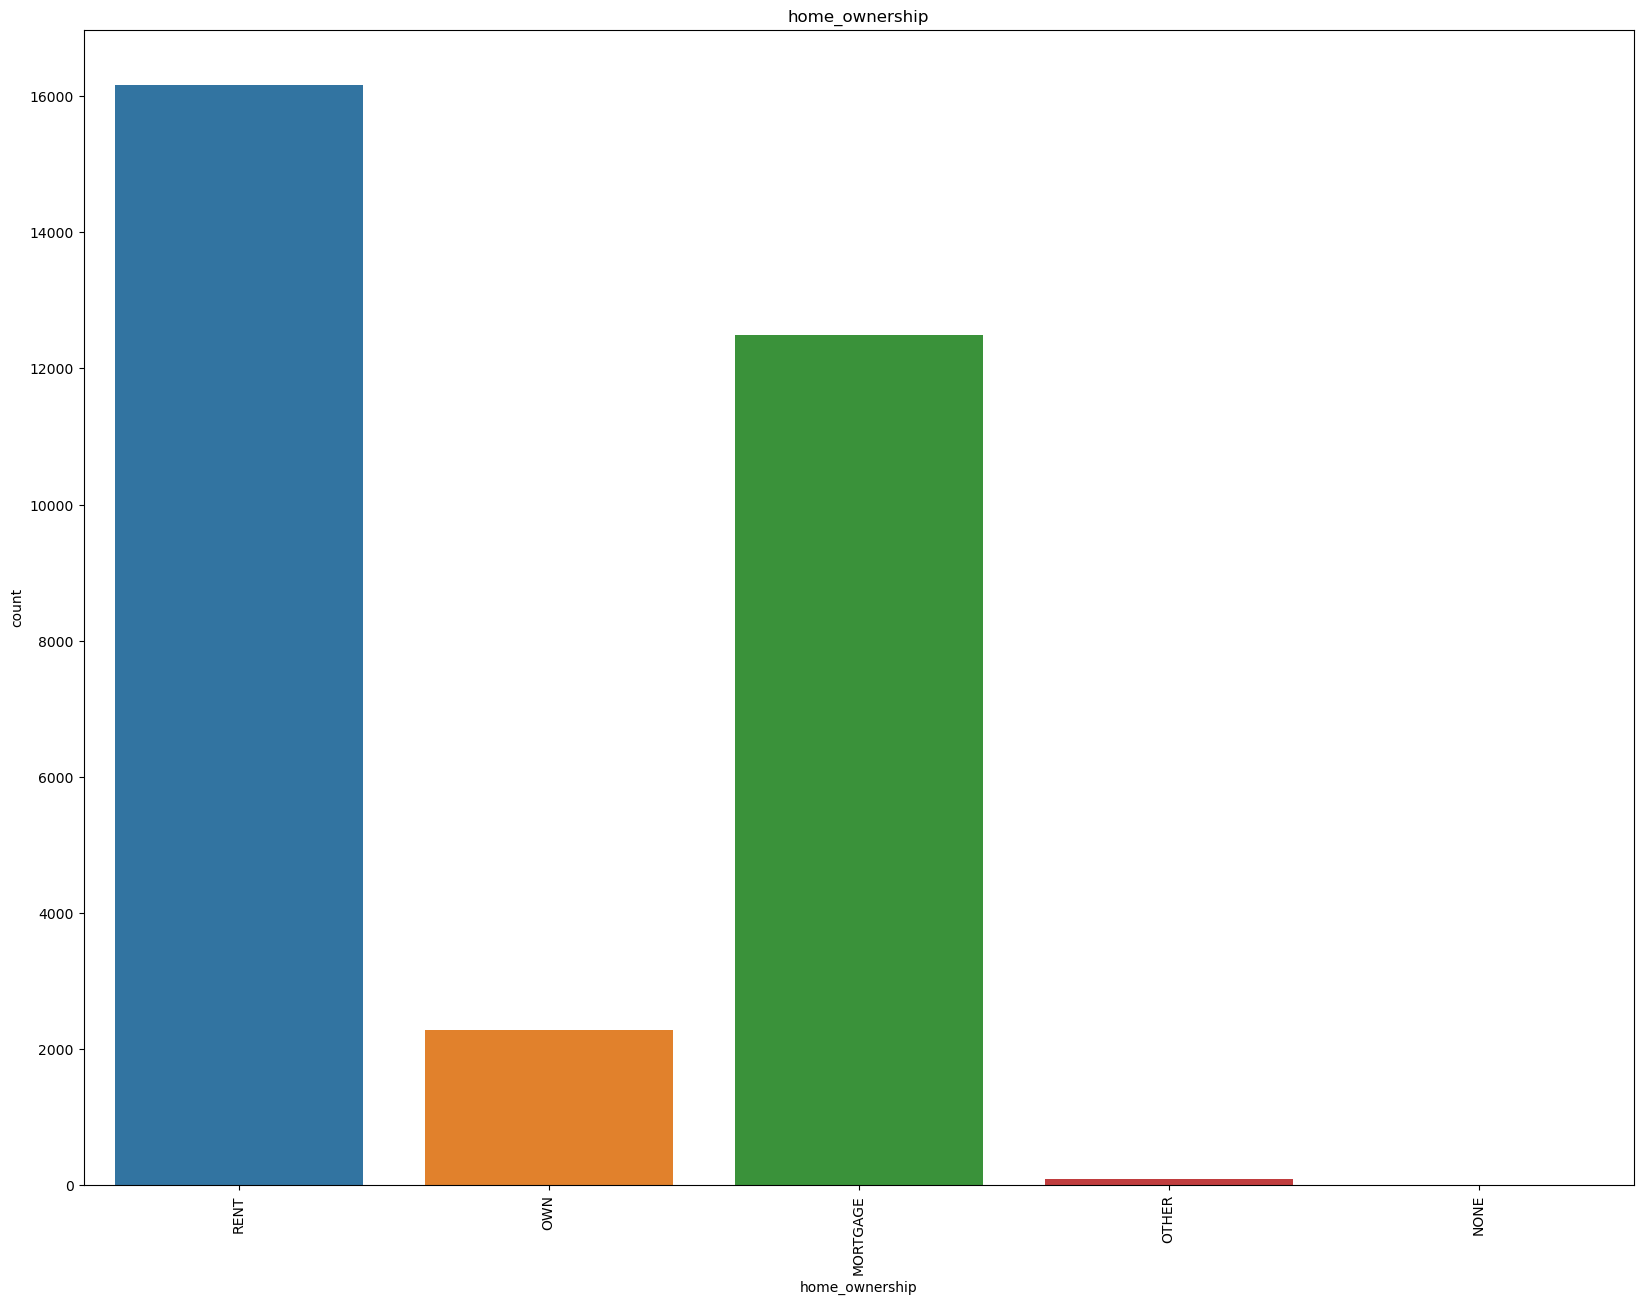

In [210]:
for i in categorical:
    plot_univariate_analysis_categorical(i)

## Insights from continouous univariate analysis

  
- loan amount spread is 5300–15000 and majority people stands at 10000
- Funded amount range is 5200–15000 and majority people stands at  
- Funded amount investment range is 5000–14000 and majority people stands at
- Interest rate spread is between 8.94–14.38 percent and majority people stands at
- dti ratio lies between 8.13–18.56 and majority people stands at
- Employment length of the loan seekers is between 2–9 years where most of the people seeking loans have 4 years of employment length and majority people stands at
- For most of the people, the number of delinquency incidents, derogatory public record, bankrupcies and enquieries in last 6 months are 0 and majority people stands at
- Only approx 30% of the people have healty revoling credit utilization and majority people stands at


## Insights from categorical univariate analysis

- The job title for which the maximum loan is taken by the borrower is US Army.
- The zip code from which the maximum loan is taken by the borrower is 112xx
- The month the borrower’s earliest reported credit line was opened is October-99.
- Term for 36 months has more loan compared to 60 months
- Address of the state where most of the loans are taken is CA and NY
- There are more than 14000 loans that are not verified
- Loan issue date for maximum loans is Dec-11
- The most recent month LC pulled credit for this loan is May-16.
- Loan status: Fully paid loan count is more than 25000, charged-off loans count is less than 5000
- Most of the loans are taken for debt_consolidation purpose
- For grade B, A4 subgrade has max loan count
- People who are staying on rent have more loans

#### Deriving Year and Month attributes for loan issue date

In [211]:
loan_df['loan_issue_year'] = loan_df.issue_d.apply(lambda d : '20'+ d.split('-')[1])
loan_df['loan_issue_year'].value_counts()

2011    16161
2010     9491
2009     3888
2008     1305
2007      185
Name: loan_issue_year, dtype: int64

In [212]:
loan_df['loan_issue_month'] = loan_df.issue_d.apply(lambda d : d.split('-')[0])
loan_df['loan_issue_month'].value_counts()

Dec    3365
Nov    3168
Oct    2923
Sep    2783
Jul    2754
Aug    2744
Jun    2560
May    2400
Apr    2312
Mar    2179
Feb    1933
Jan    1909
Name: loan_issue_month, dtype: int64

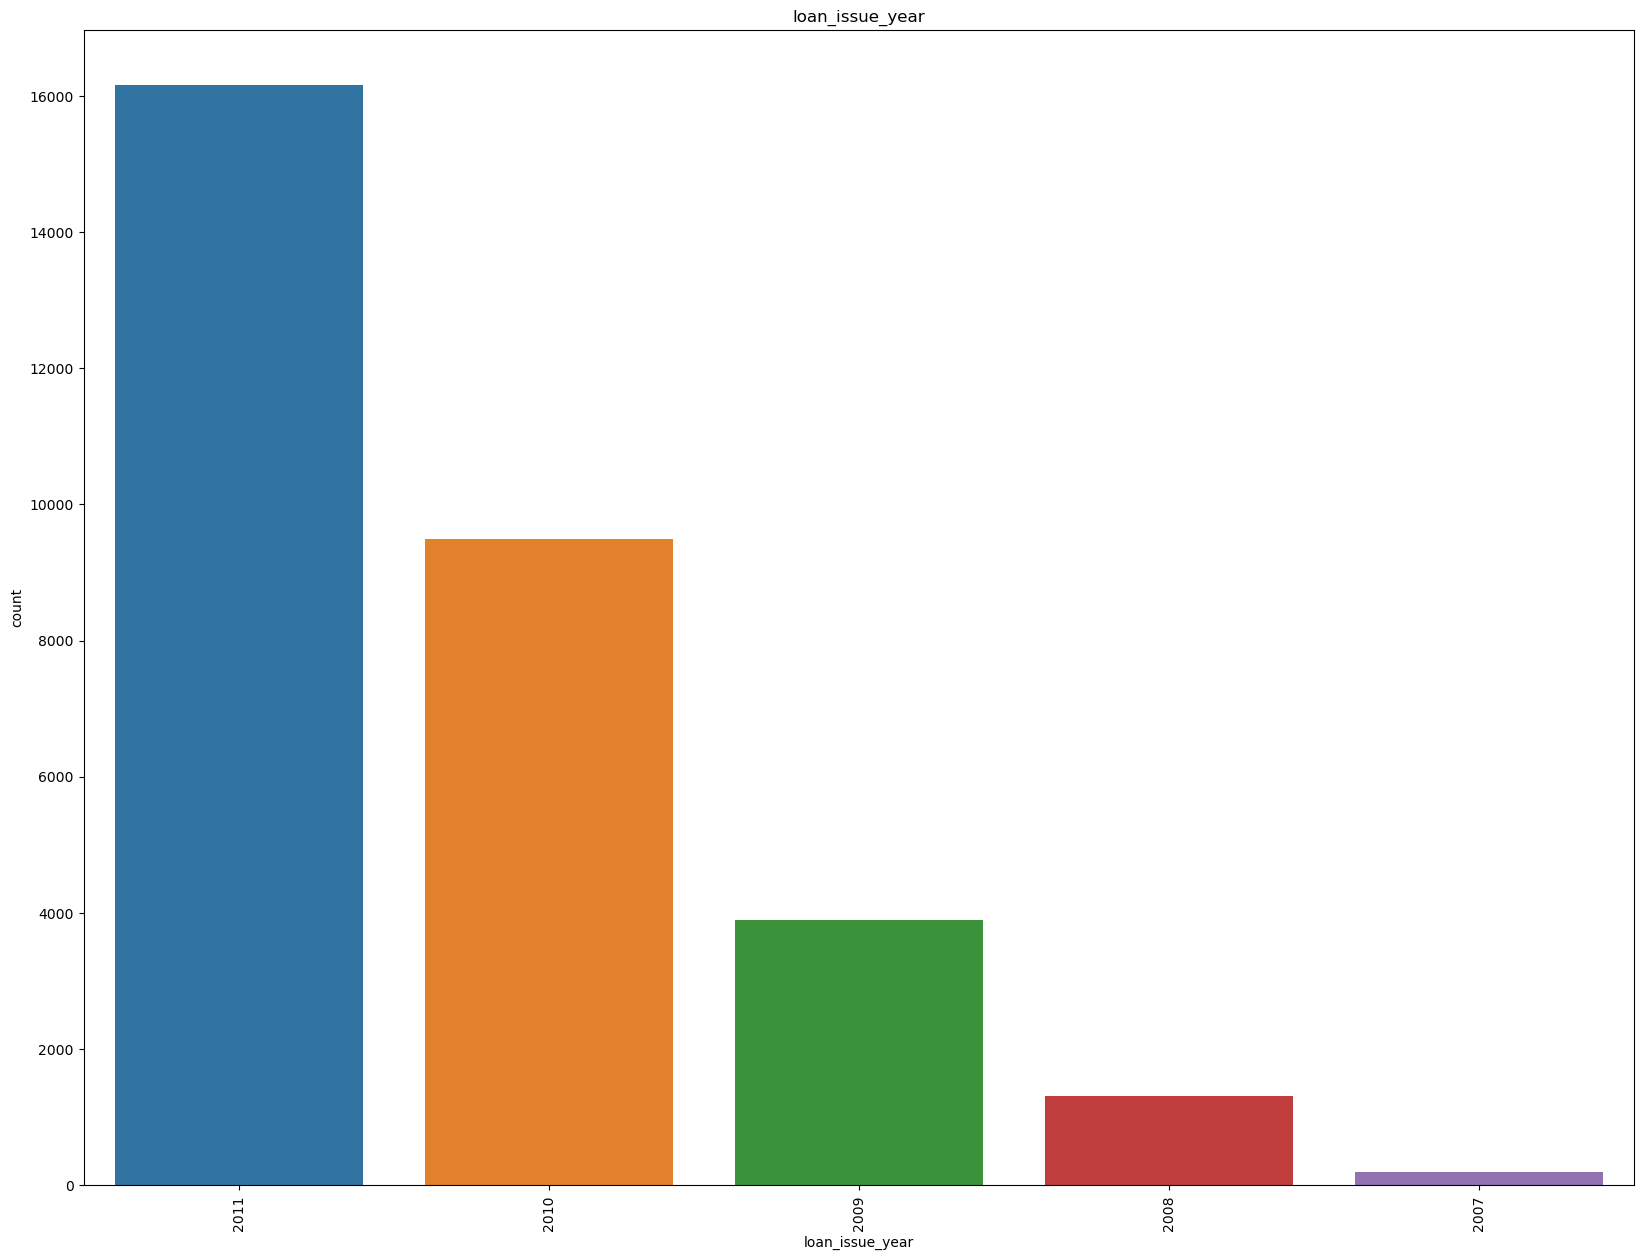

In [213]:
plot_univariate_analysis_categorical('loan_issue_year')

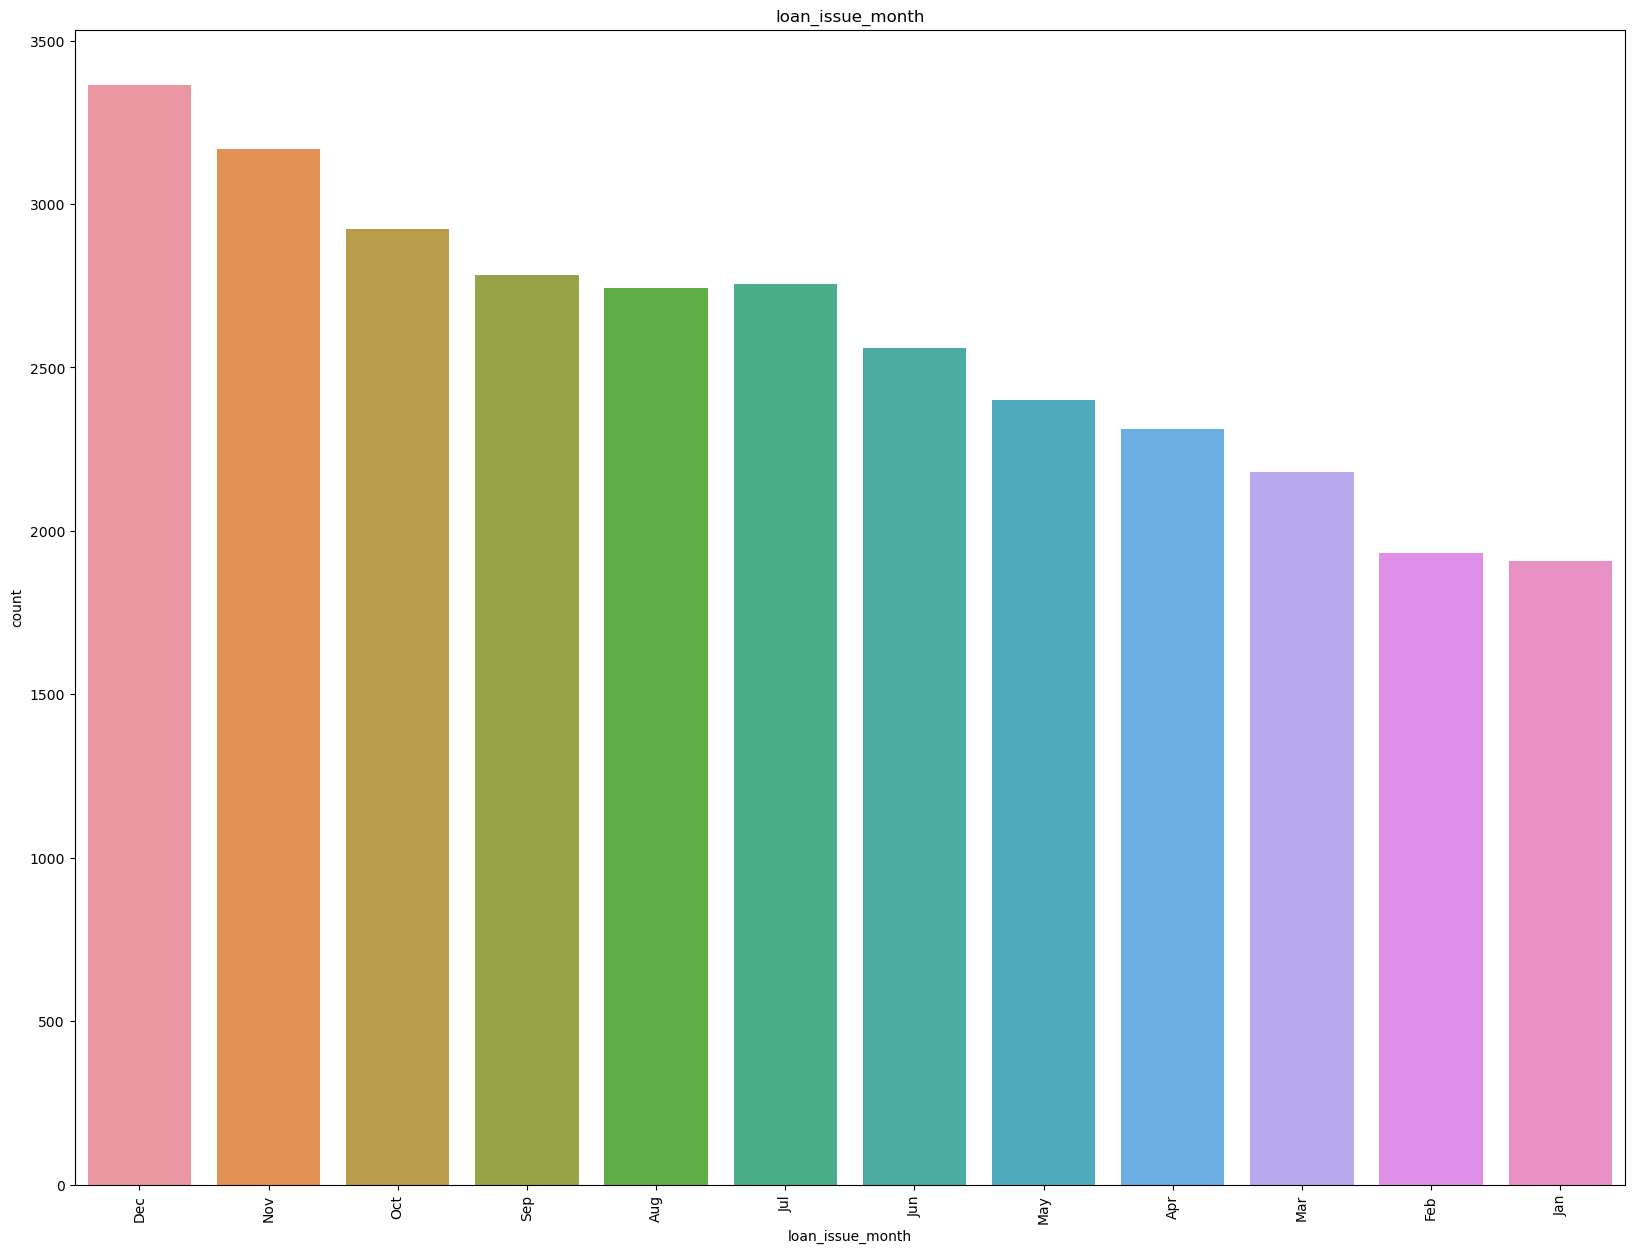

In [214]:
plot_univariate_analysis_categorical('loan_issue_month')

## Insights from derived categorical analysis

- Maximum loans are issued in December month
- Maximum loans are issued in 2011 year

## Segmented univariate analysis

#### Creating bins for segmented analysis

In [215]:
for i in continuous:
    minV = loan_df[i].min()
    maxV = loan_df[i].max()
    print(minV, "\t", maxV, "\t\t", i)

500 	 35000 		 loan_amnt
500 	 35000 		 funded_amnt
0.0 	 35000.0 		 funded_amnt_inv
5.42 	 24.4 		 int_rate
0.0 	 29.99 		 dti
0 	 10 		 emp_length
4000.0 	 140000.0 		 annual_inc
0 	 11 		 delinq_2yrs
0.0 	 120.0 		 mths_since_last_delinq
0 	 8 		 inq_last_6mths
0 	 4 		 pub_rec
0.0 	 2.0 		 pub_rec_bankruptcies
2 	 42 		 open_acc
2 	 90 		 total_acc
0 	 35954 		 revol_bal
0.0 	 99.9 		 revol_util
0.0 	 58563.67993 		 total_pymnt
0.0 	 58563.68 		 total_pymnt_inv
0.0 	 11873.37 		 last_pymnt_amnt
0.0 	 35000.02 		 total_rec_prncp
0.0 	 23563.68 		 total_rec_int
0.0 	 180.2 		 total_rec_late_fee


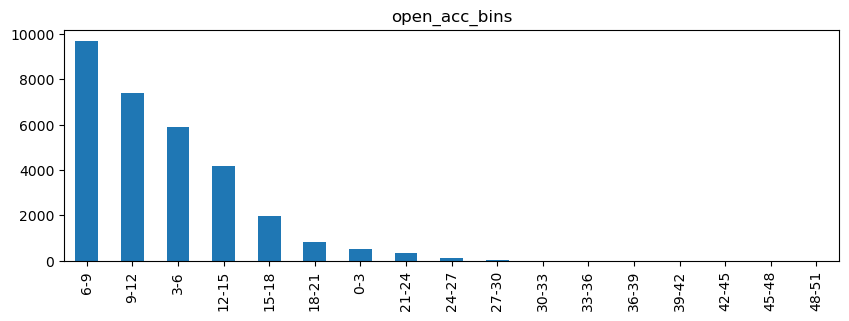

In [216]:
range_label = []
for i in range(0,50,3): 
    range_label.append(str(str(i)+'-'+str(i+3)))

bins = np.linspace(0, 50, 18)
    
loan_df['open_acc_bins'] = pd.cut(loan_df['open_acc'], bins, labels=range_label)

plt.figure(figsize = (10,3))
plt.title("open_acc_bins")
loan_df.open_acc_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()  

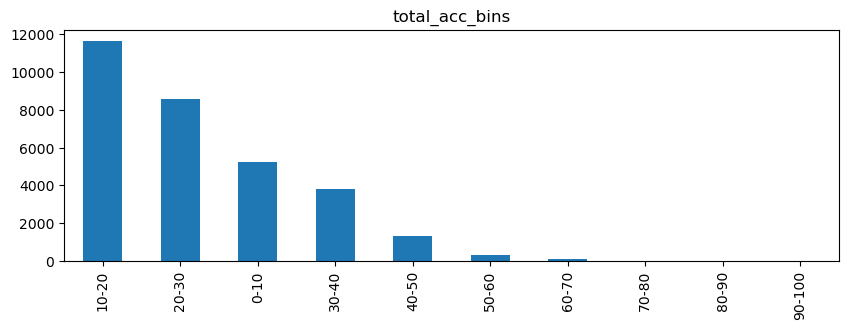

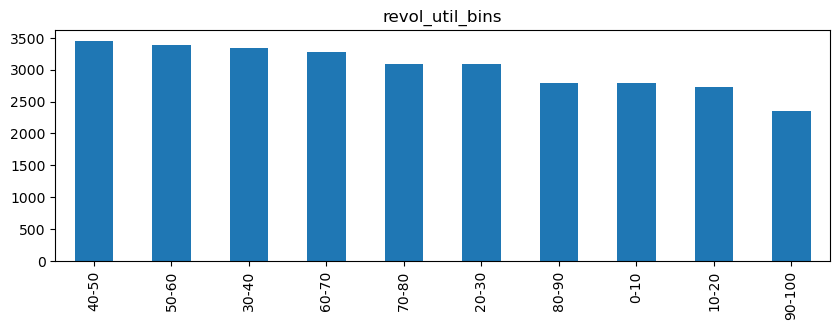

In [217]:
range_label = []
for i in range(0,100,10): 
    range_label.append(str(str(i)+'-'+str(i+10)))

bins = np.linspace(0, 100, 11)
    
loan_df['total_acc_bins'] = pd.cut(loan_df['total_acc'], bins, labels=range_label)
loan_df['revol_util_bins'] = pd.cut(loan_df['revol_util'], bins, labels=range_label)

plt.figure(figsize = (10,3))
plt.title("total_acc_bins")
loan_df.total_acc_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()  

plt.figure(figsize = (10,3))
plt.title("revol_util_bins")
loan_df.revol_util_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()   

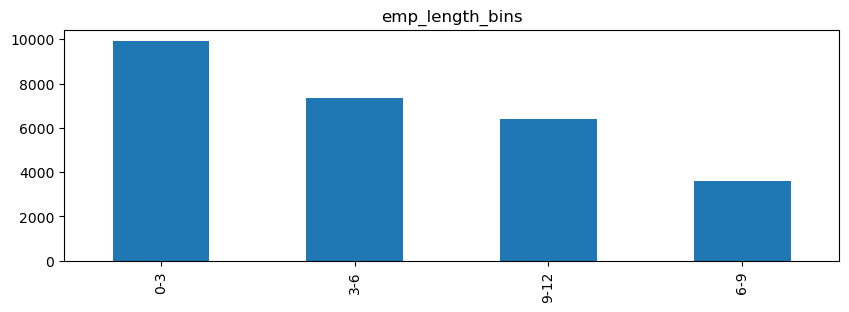

In [218]:
range_label = []
for i in range(0,12,3): 
    range_label.append(str(str(i)+'-'+str(i+3)))

bins = np.linspace(0, 12, 5)
    
loan_df['emp_length_bins'] = pd.cut(loan_df['emp_length'], bins, labels=range_label)

plt.figure(figsize = (10,3))
plt.title("emp_length_bins")
loan_df.emp_length_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()         


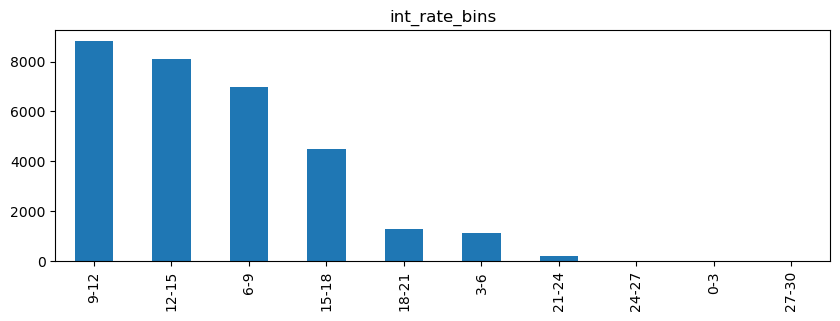

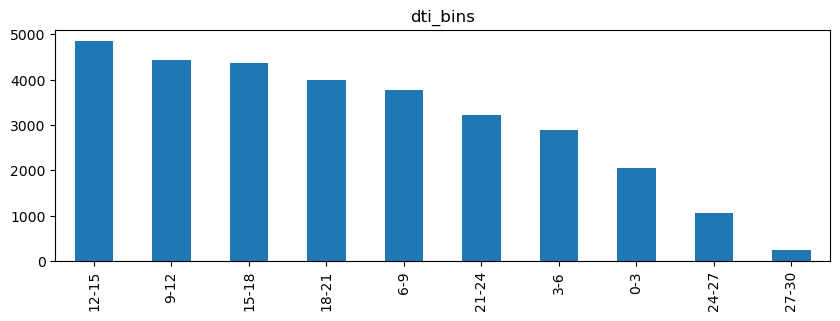

In [219]:
range_label = []
for i in range(0,30,3): 
    range_label.append(str(str(i)+'-'+str(i+3)))

bins = np.linspace(0, 30, 11)
    
loan_df['int_rate_bins'] = pd.cut(loan_df['int_rate'], bins, labels=range_label)
loan_df['dti_bins'] = pd.cut(loan_df['dti'], bins, labels=range_label)

plt.figure(figsize = (10,3))
plt.title("int_rate_bins")
loan_df.int_rate_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()         


plt.figure(figsize = (10,3))
plt.title("dti_bins")
loan_df.dti_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()   

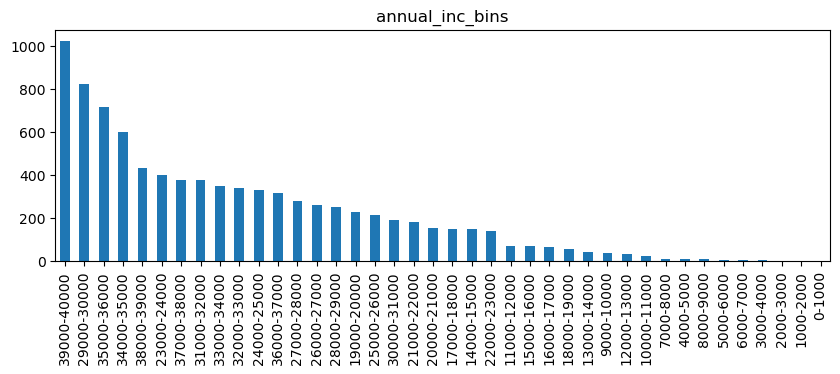

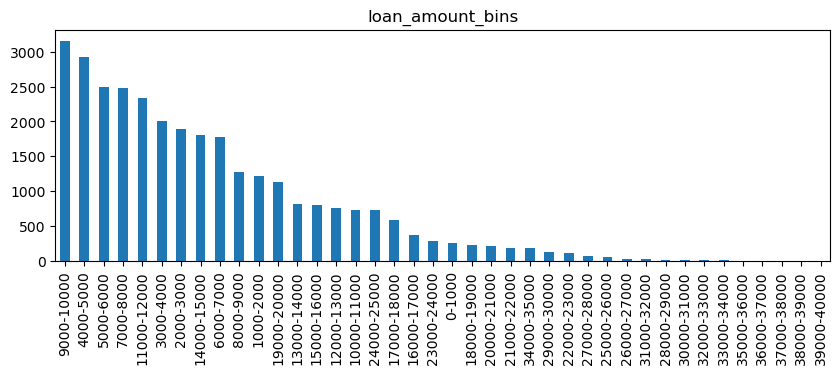

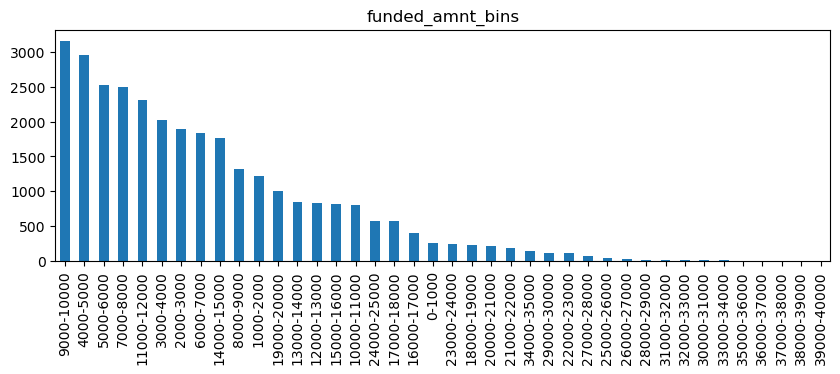

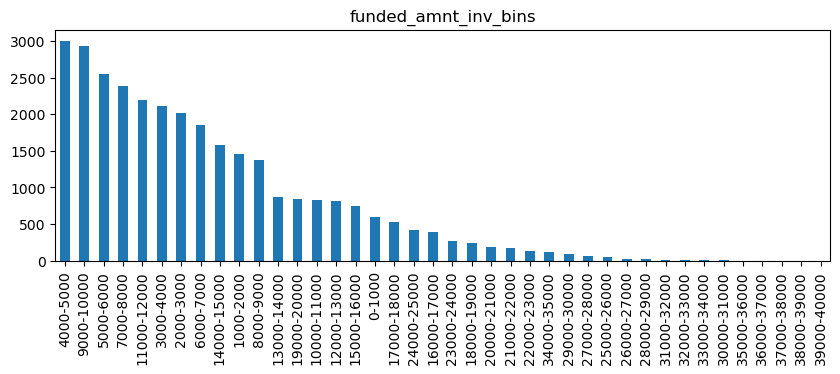

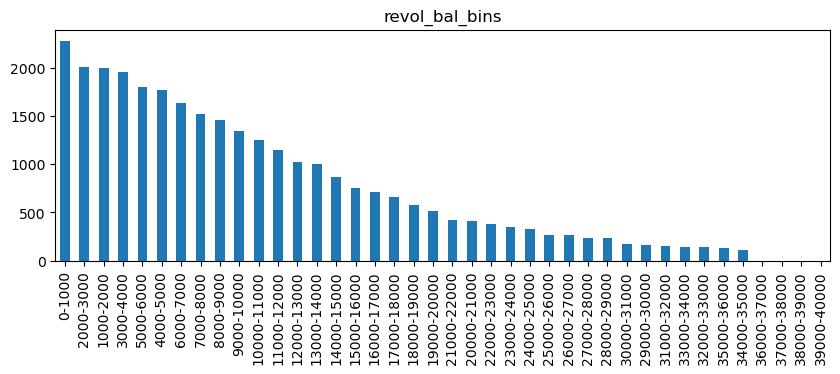

In [220]:
range_label = []
for i in range(0,40000,1000): 
    range_label.append(str(str(i)+'-'+str(i+1000)))

bins = np.linspace(0, 40000, 41)
loan_df['loan_amount_bins'] = pd.cut(loan_df['loan_amnt'], bins, labels=range_label)
loan_df['funded_amnt_bins'] = pd.cut(loan_df['funded_amnt'], bins, labels=range_label)
loan_df['funded_amnt_inv_bins'] = pd.cut(loan_df['funded_amnt_inv'], bins, labels=range_label)
loan_df['annual_inc_bins'] = pd.cut(loan_df['annual_inc'], bins, labels=range_label)
loan_df['revol_bal_bins'] = pd.cut(loan_df['revol_bal'], bins, labels=range_label)

plt.figure(figsize = (10,3))
plt.title("annual_inc_bins")
loan_df.annual_inc_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()
                                    
plt.figure(figsize = (10,3))
plt.title("loan_amount_bins")
loan_df.loan_amount_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize = (10,3))
plt.title("funded_amnt_bins")
loan_df.funded_amnt_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize = (10,3))
plt.title("funded_amnt_inv_bins")
loan_df.funded_amnt_inv_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize = (10,3))
plt.title("revol_bal_bins")
loan_df.revol_bal_bins.value_counts().plot(kind = 'bar') 
plt.xticks(rotation=90)
plt.show()

## Insights from segmented analysis of the continuous data

- The loan amount range for maximum loan count is 9000–10000.
- Maximum count of funded amount range by LC is 9000–10000.
- Maximum count of the amount approved by the investor is 4000–5000
- Borrowers with annual income between 39000–40000 applies for the maximum loan.
- Max count of interest rate range applied on Loans is 12-15
- dti ratio for maximum loans is 12-15
- revol_bal for most of the loans lies between 0-1000
- Maximum loan applicants have 6-9 open accounts
- Maximum loan applicants have 10-20 total accounts

## Heatmap to analyze correlation between continuous data

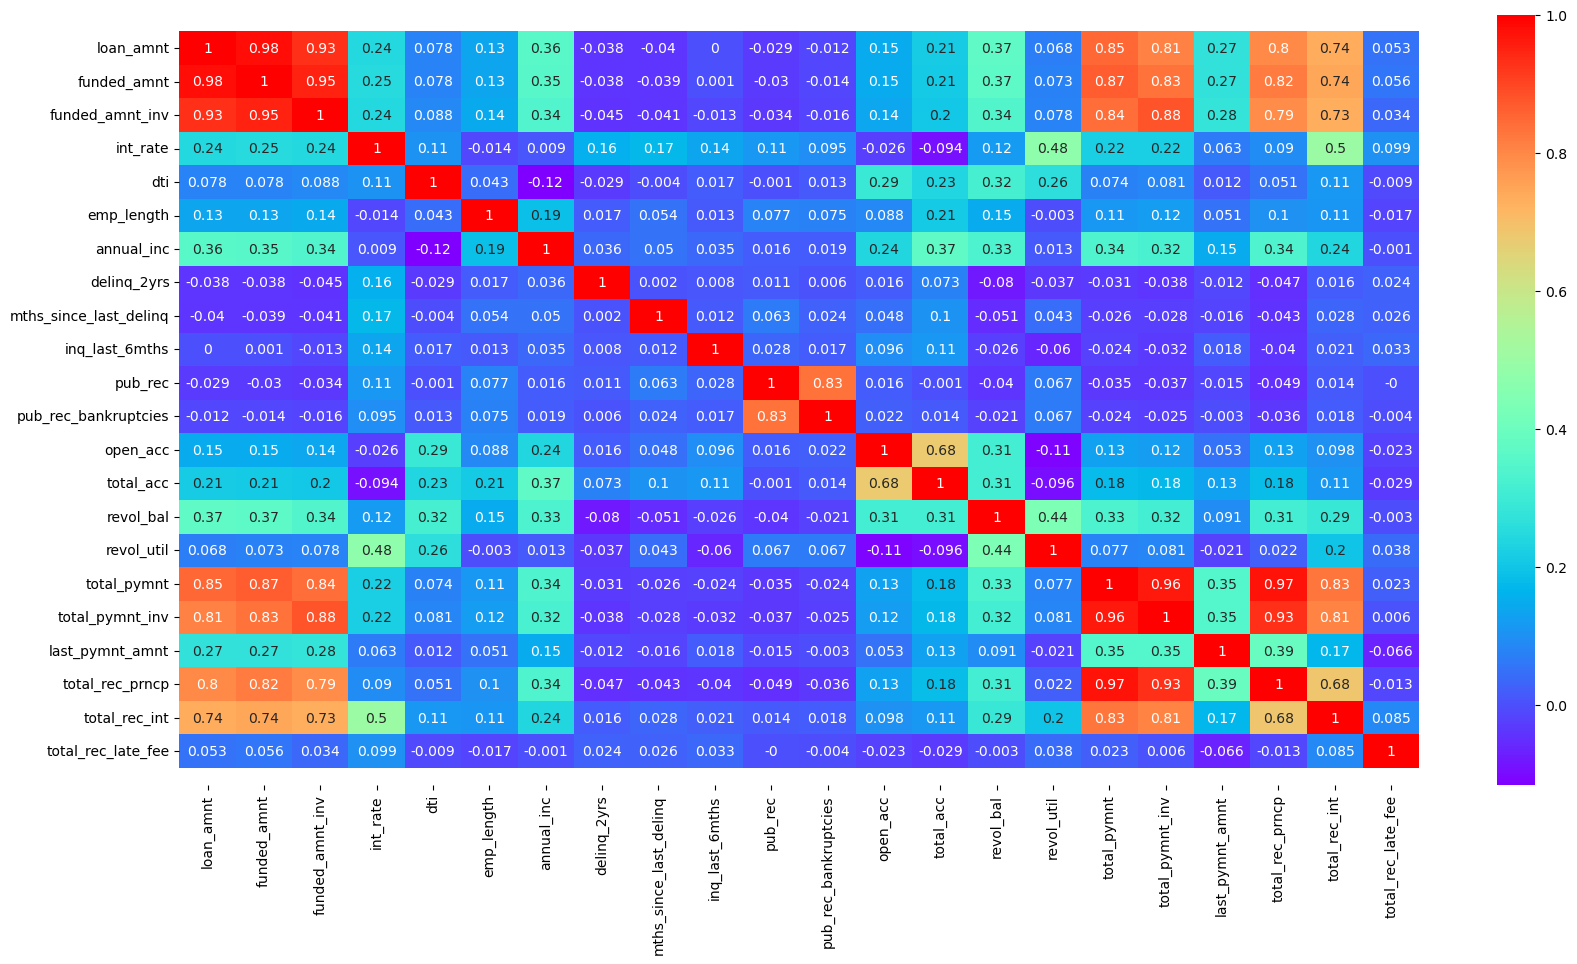

In [226]:
cor = round(loan_df[continuous].corr(),3)
# figure size
plt.figure(figsize=(20,10))
# heatmap
ax = sns.heatmap(cor, cmap = "rainbow", annot=True)
top, bottom = ax.get_ylim()
ax.set_ylim(top+0.5, bottom-0.5)
plt.show()

#### Above heat map shows that loan_amt,funded_amt,funded_amt_inv are highly correlated. It implies that investors lend approx 95 percent of the loan amount claimed by the borrower.
#### Also total_pymnt, total_pymnt_inv, total_rec_prncp are highly correlated. It implies that borrower has paid approx 96 percent of the money investors lended.

## Analyze Charged Off data

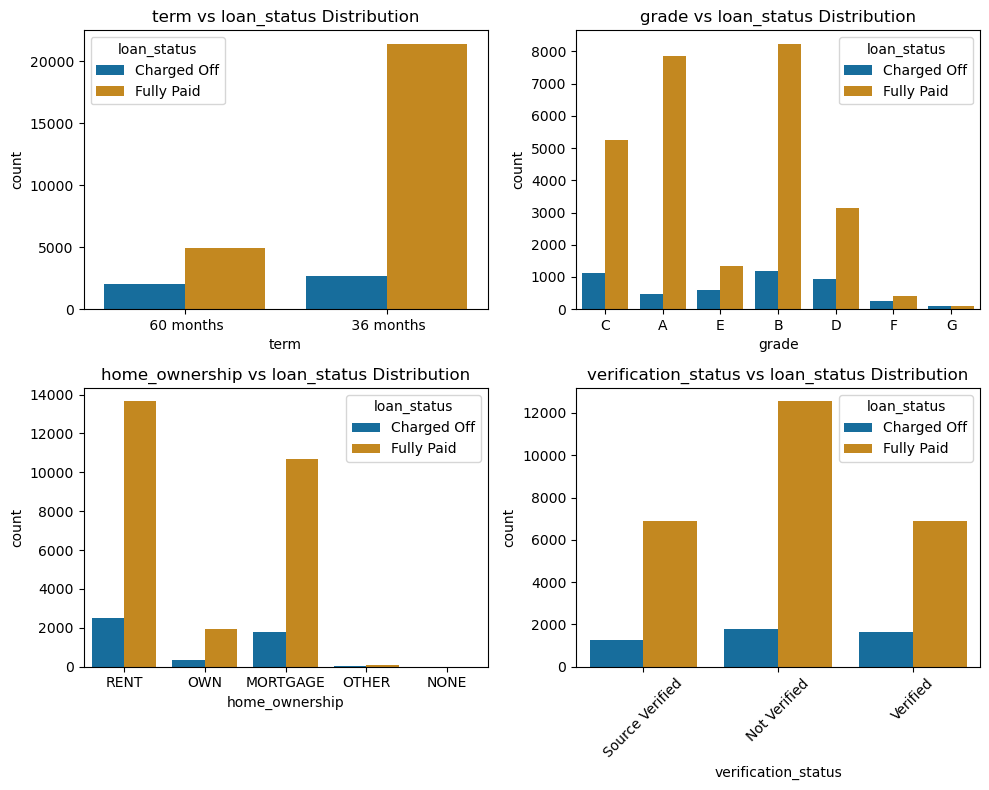

In [294]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Columns to plot
columns_to_plot = ["term", "grade", "home_ownership", "verification_status"]

# Loop through columns and create categorical plots
for i, column in enumerate(columns_to_plot):
    row = i // 2  # Calculate the row position (0 or 1)
    col = i % 2   # Calculate the column position (0 or 1)
    ax = axes[row, col]  # Get the current subplot
    
    ax.set_title(f"{column} vs loan_status Distribution")
    sns.countplot(x=column, hue='loan_status', ax=ax, data=loan_df)
    plt.xticks(rotation=45)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [320]:
def plotAttributeVsLoanStatus(column_name):    
    plt.figure(figsize=(20, 15))
    plt.title(column_name)
    
    sns.countplot(x=column_name, hue='loan_status', data=loan_df)
                
    plt.xticks(rotation=90)
    plt.show()    

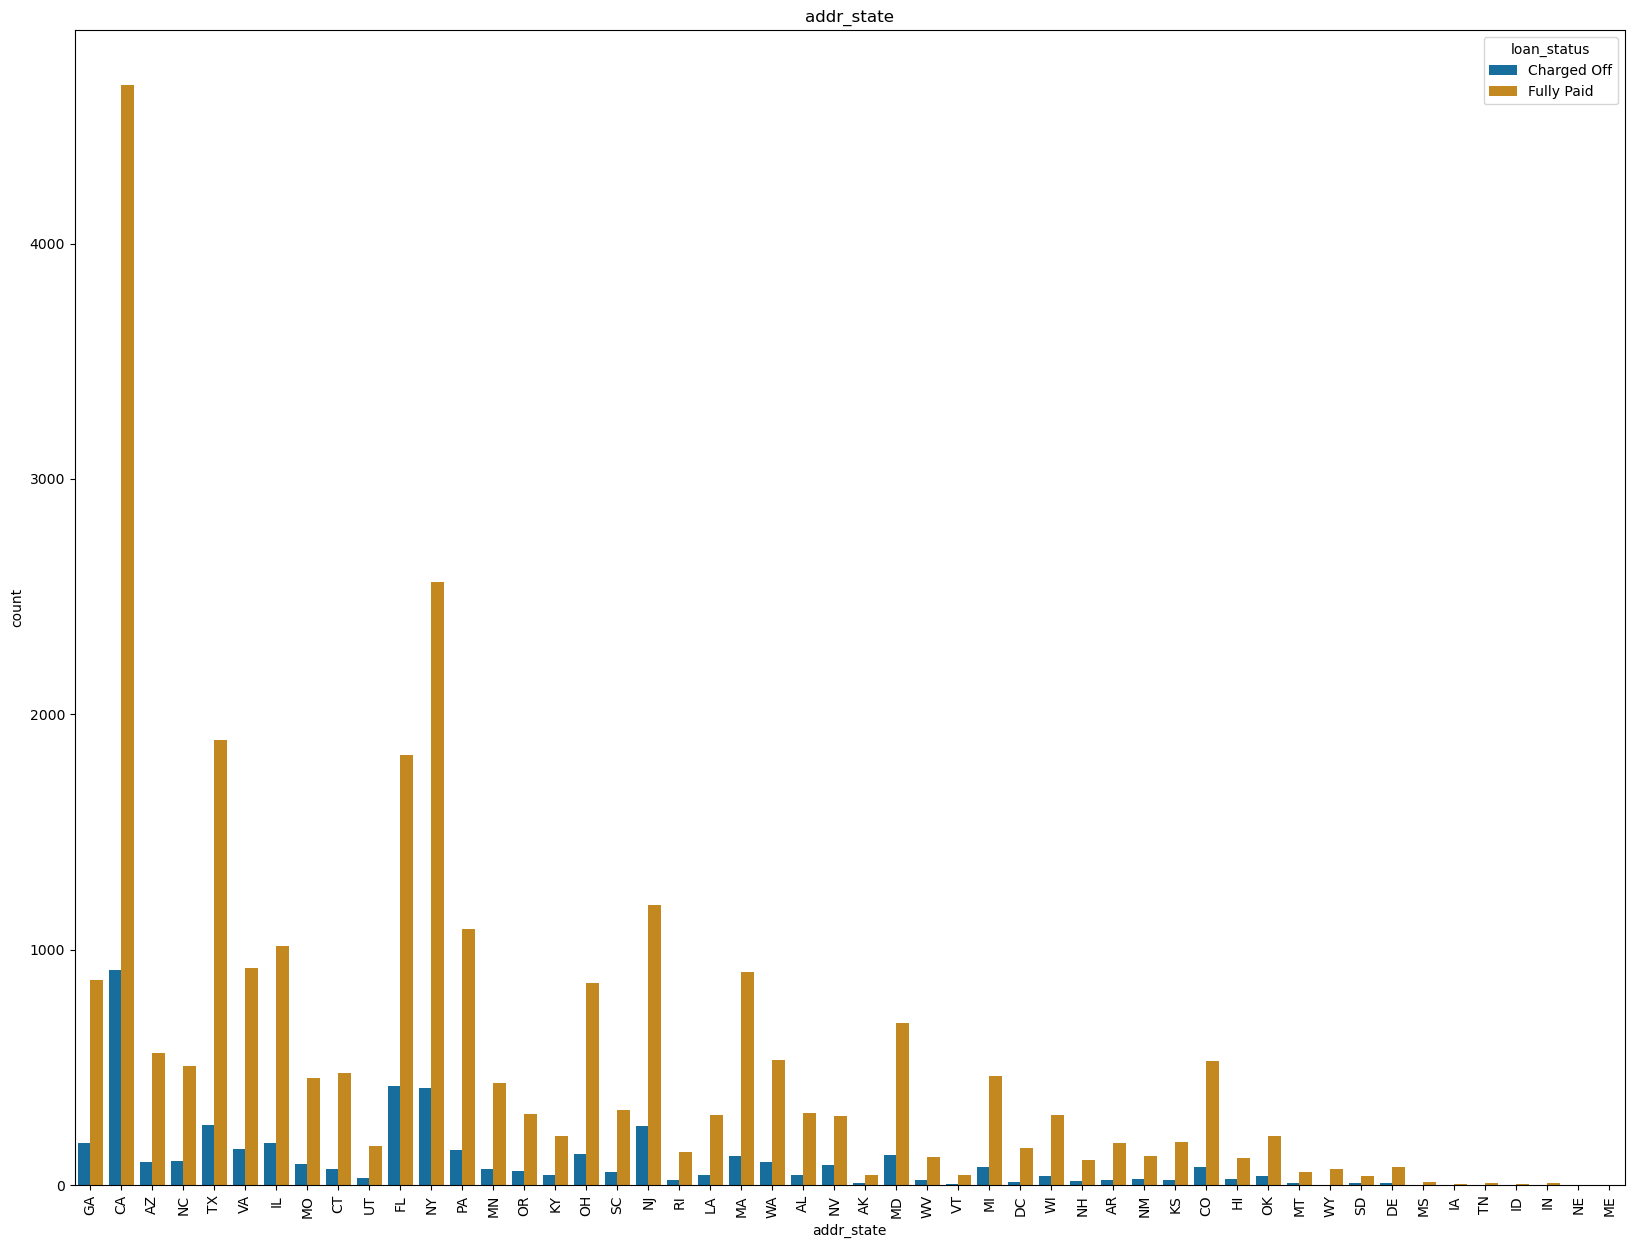

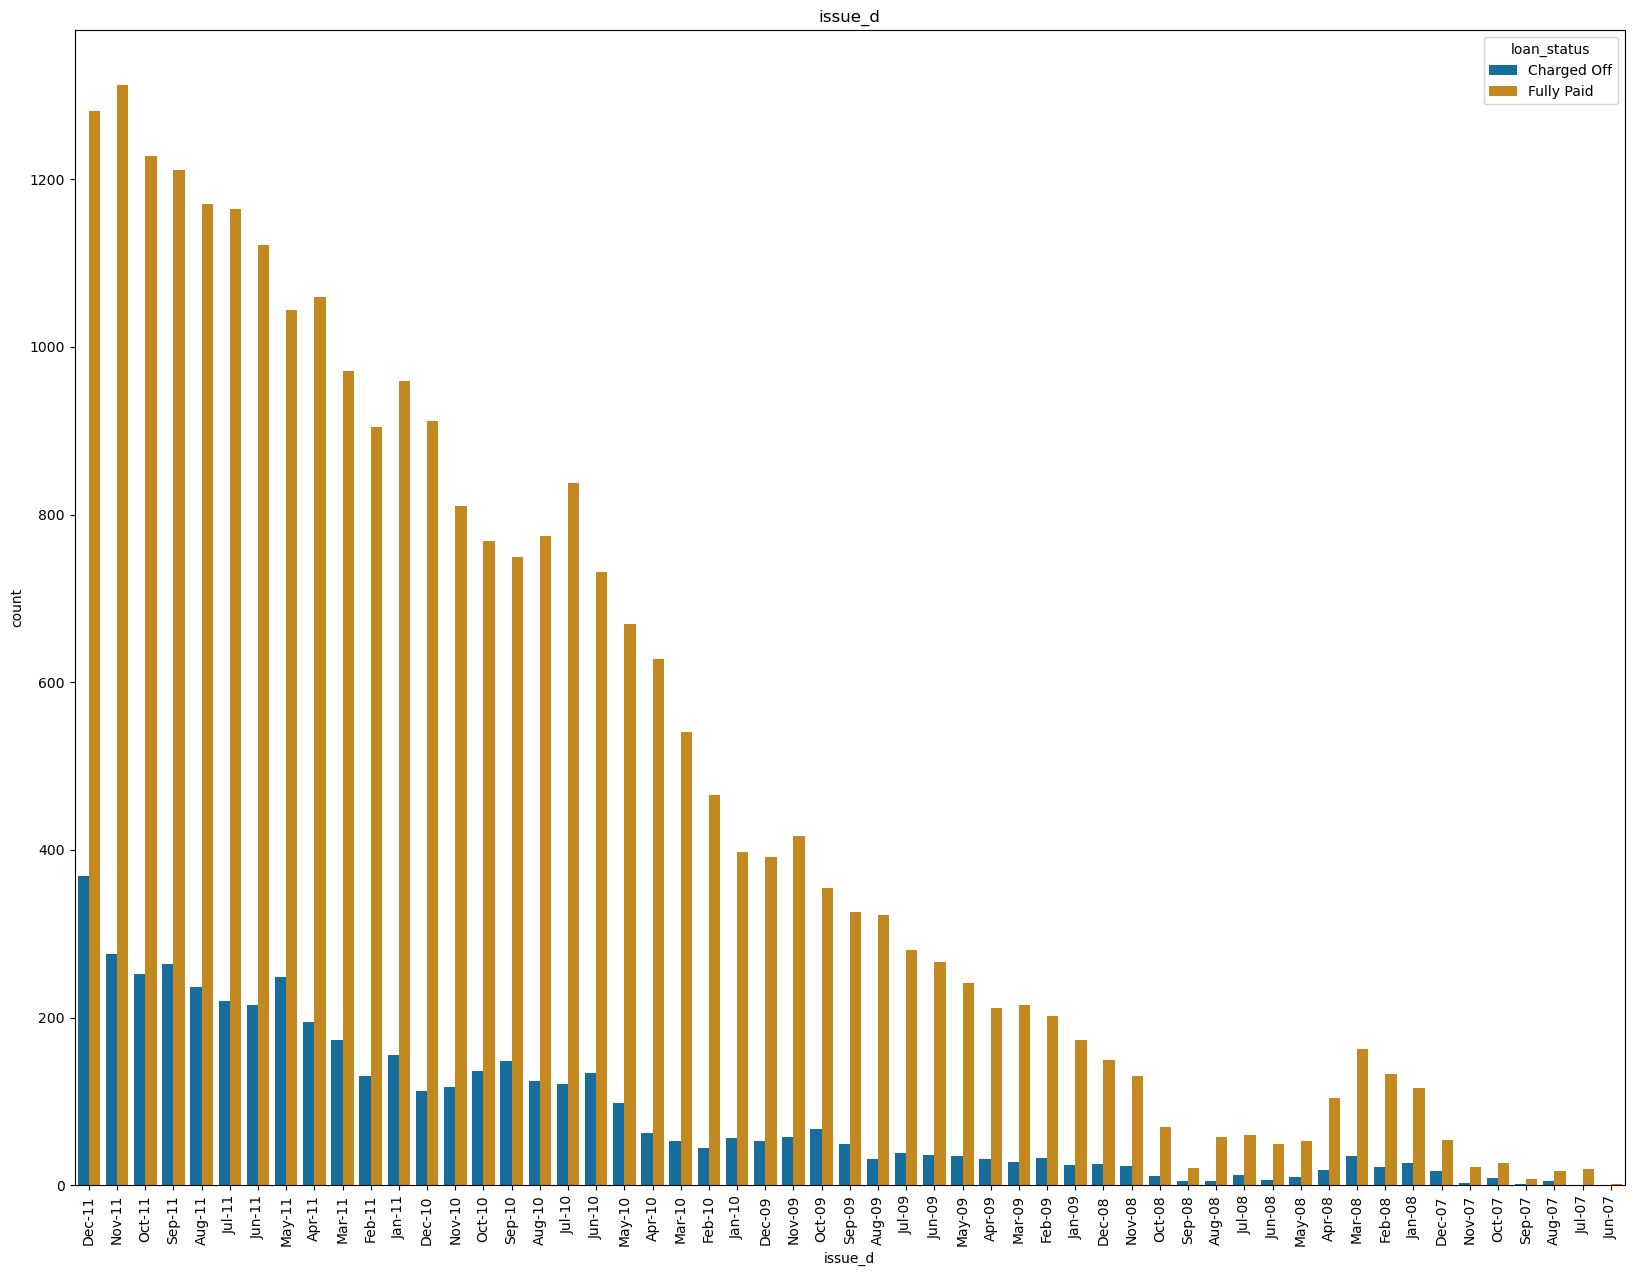

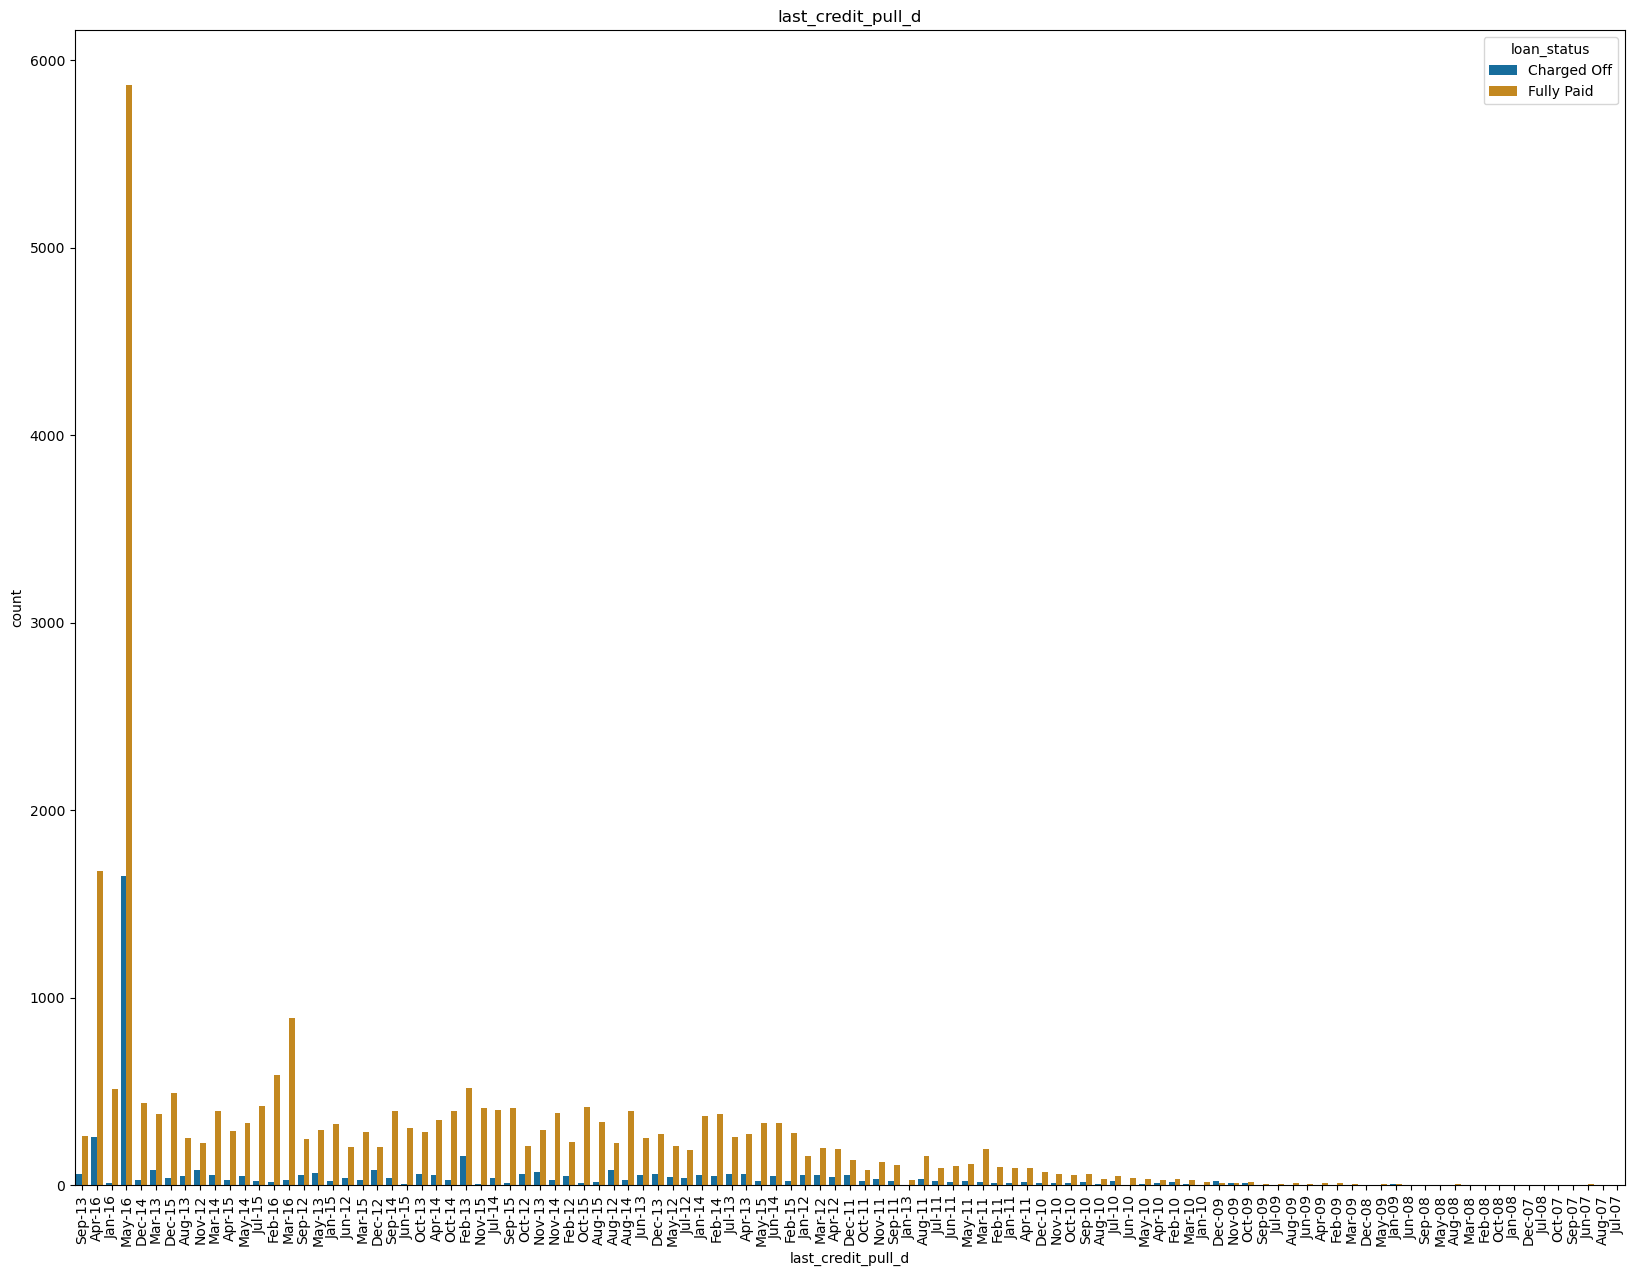

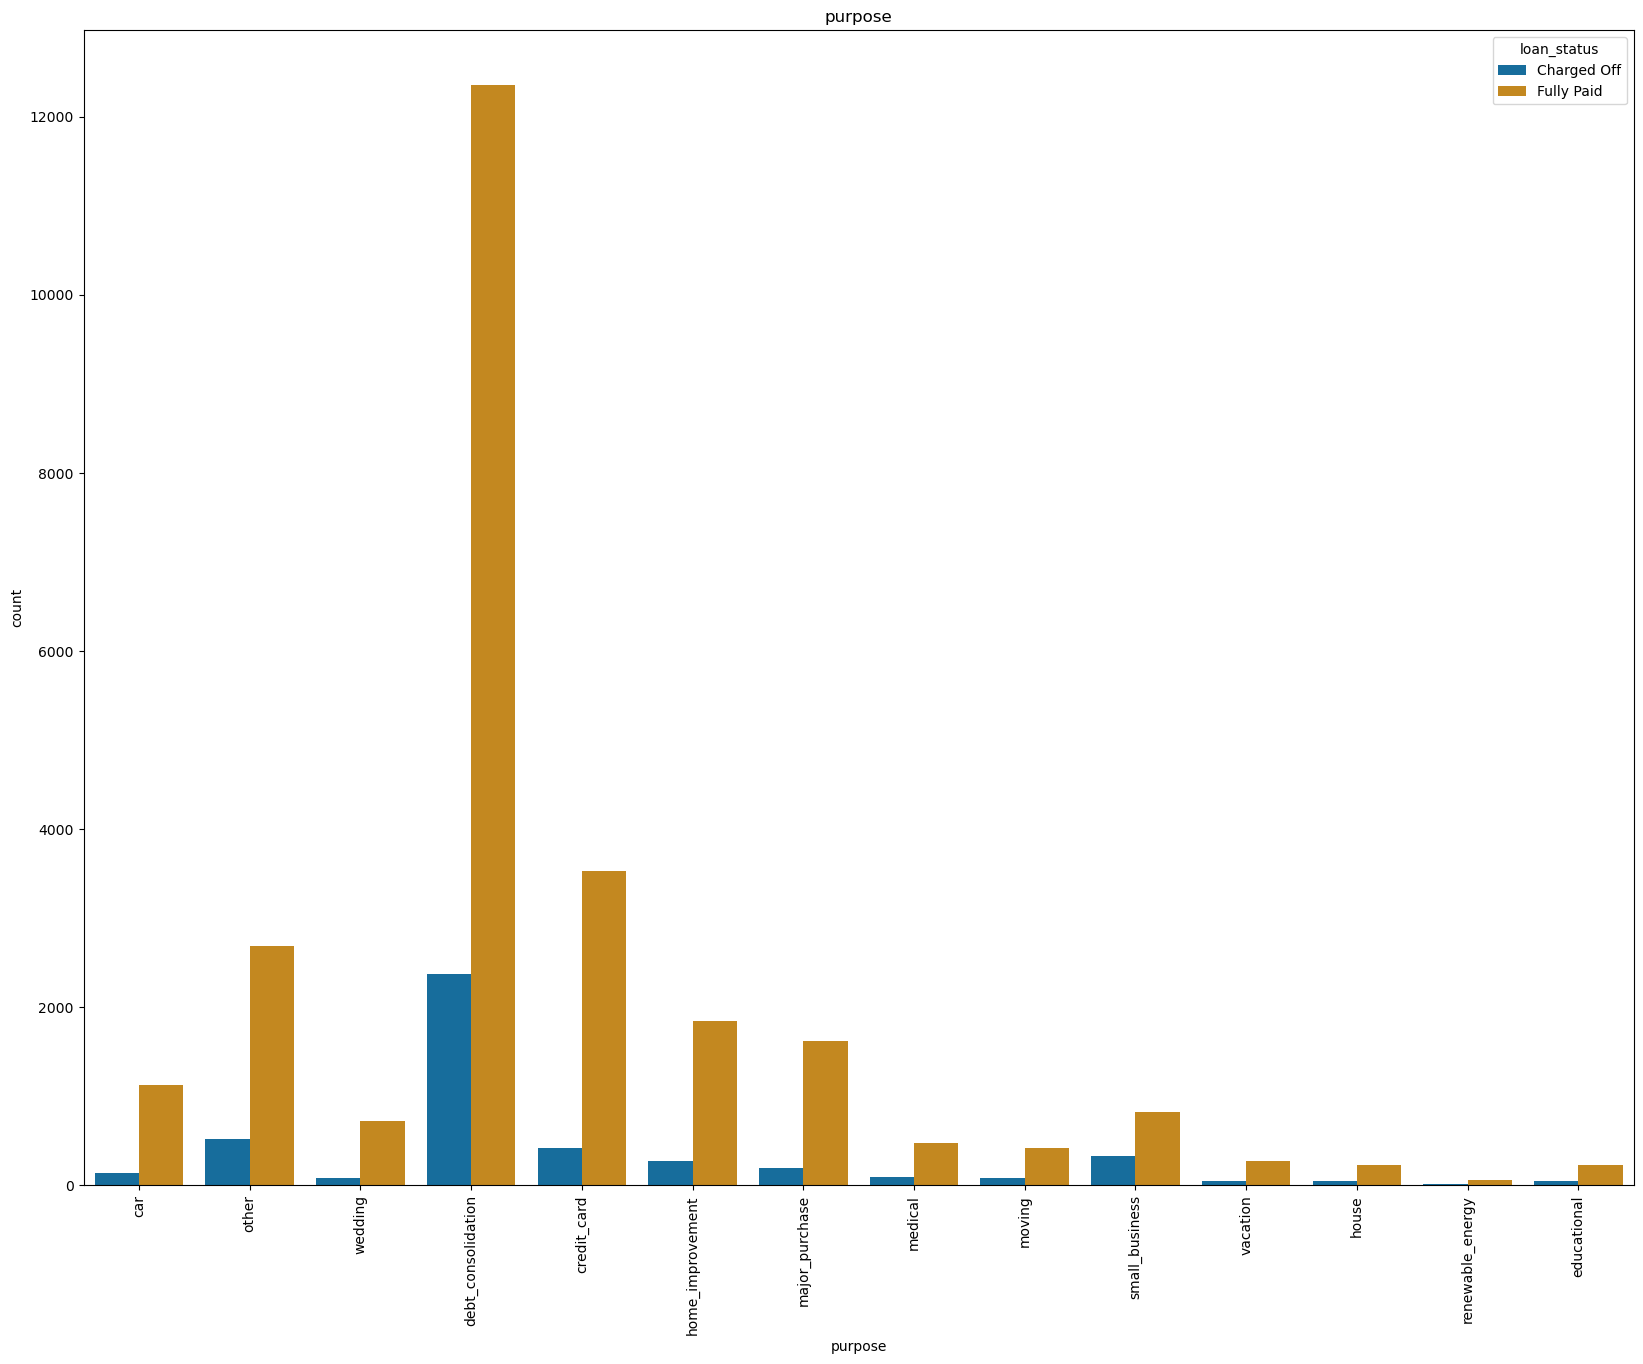

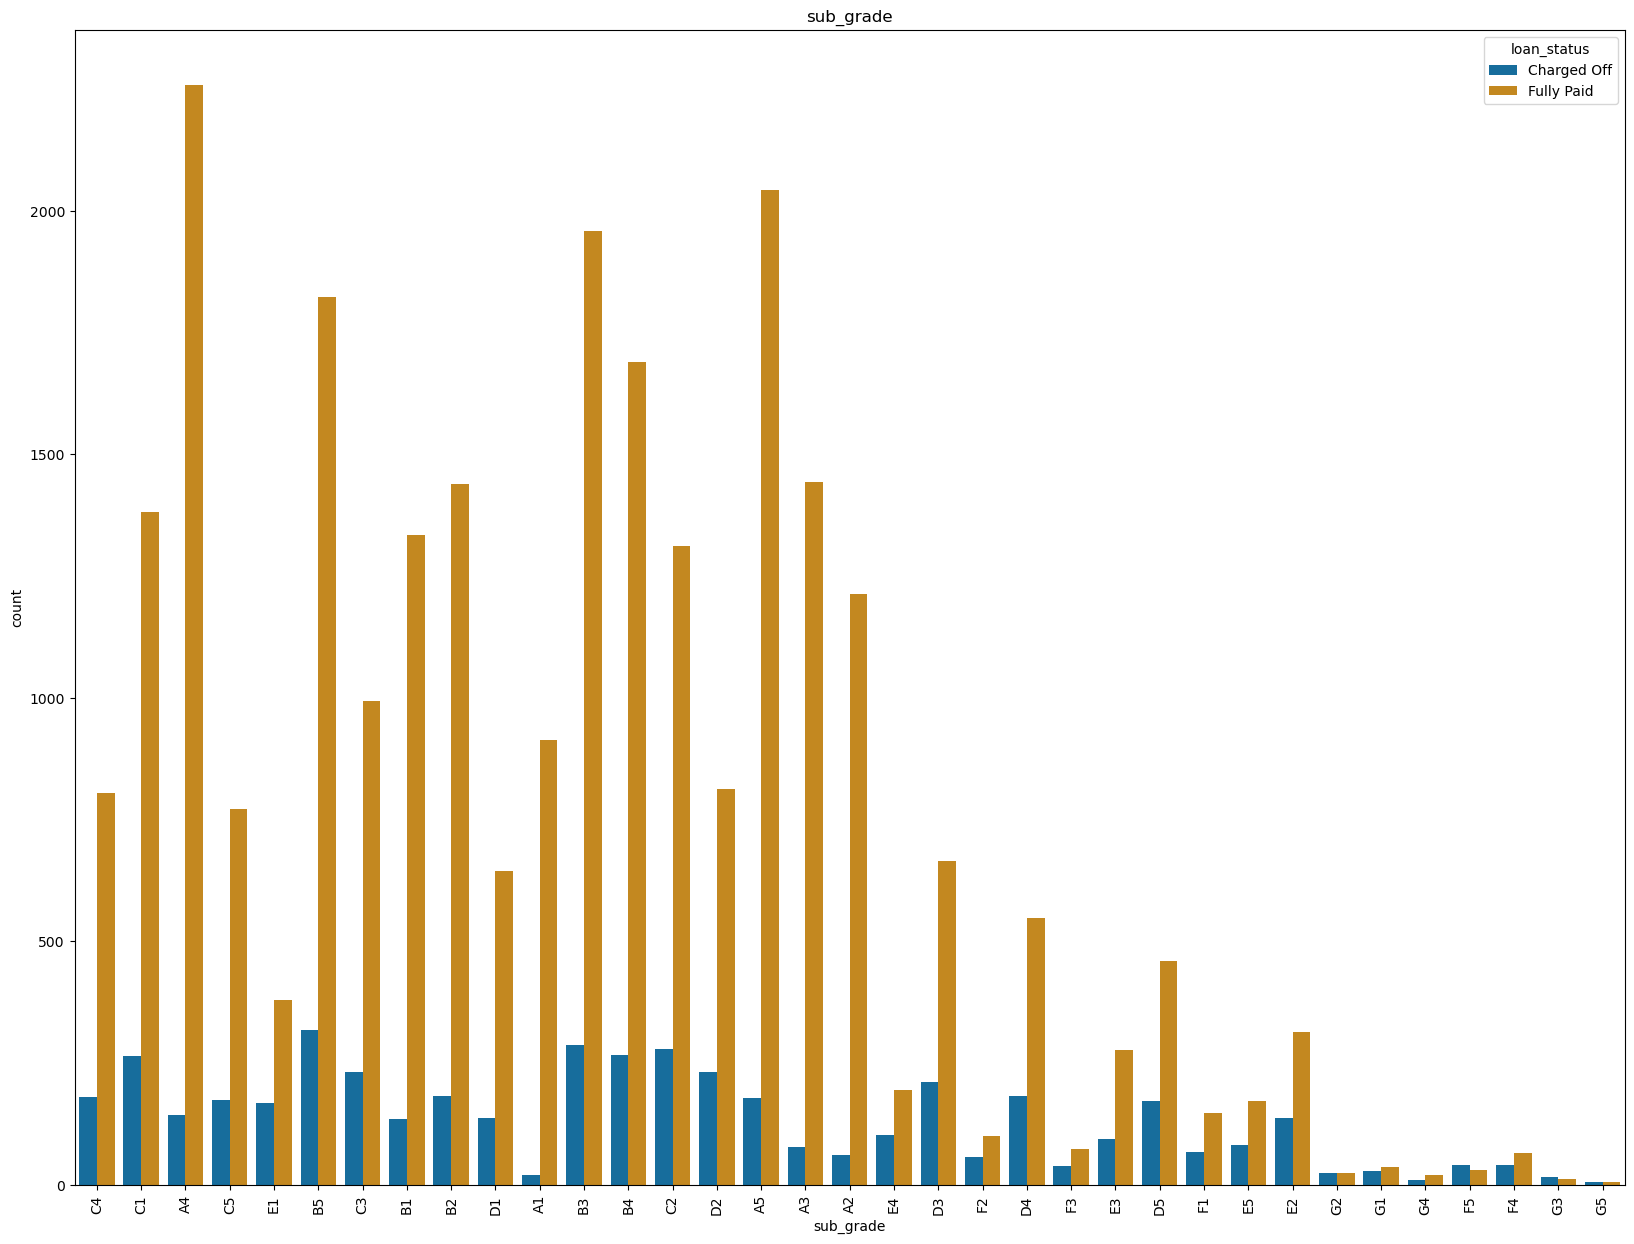

In [321]:
plotCols = ['addr_state','issue_d','last_credit_pull_d','purpose','sub_grade']

for i in plotCols:
    plotAttributeVsLoanStatus(i)

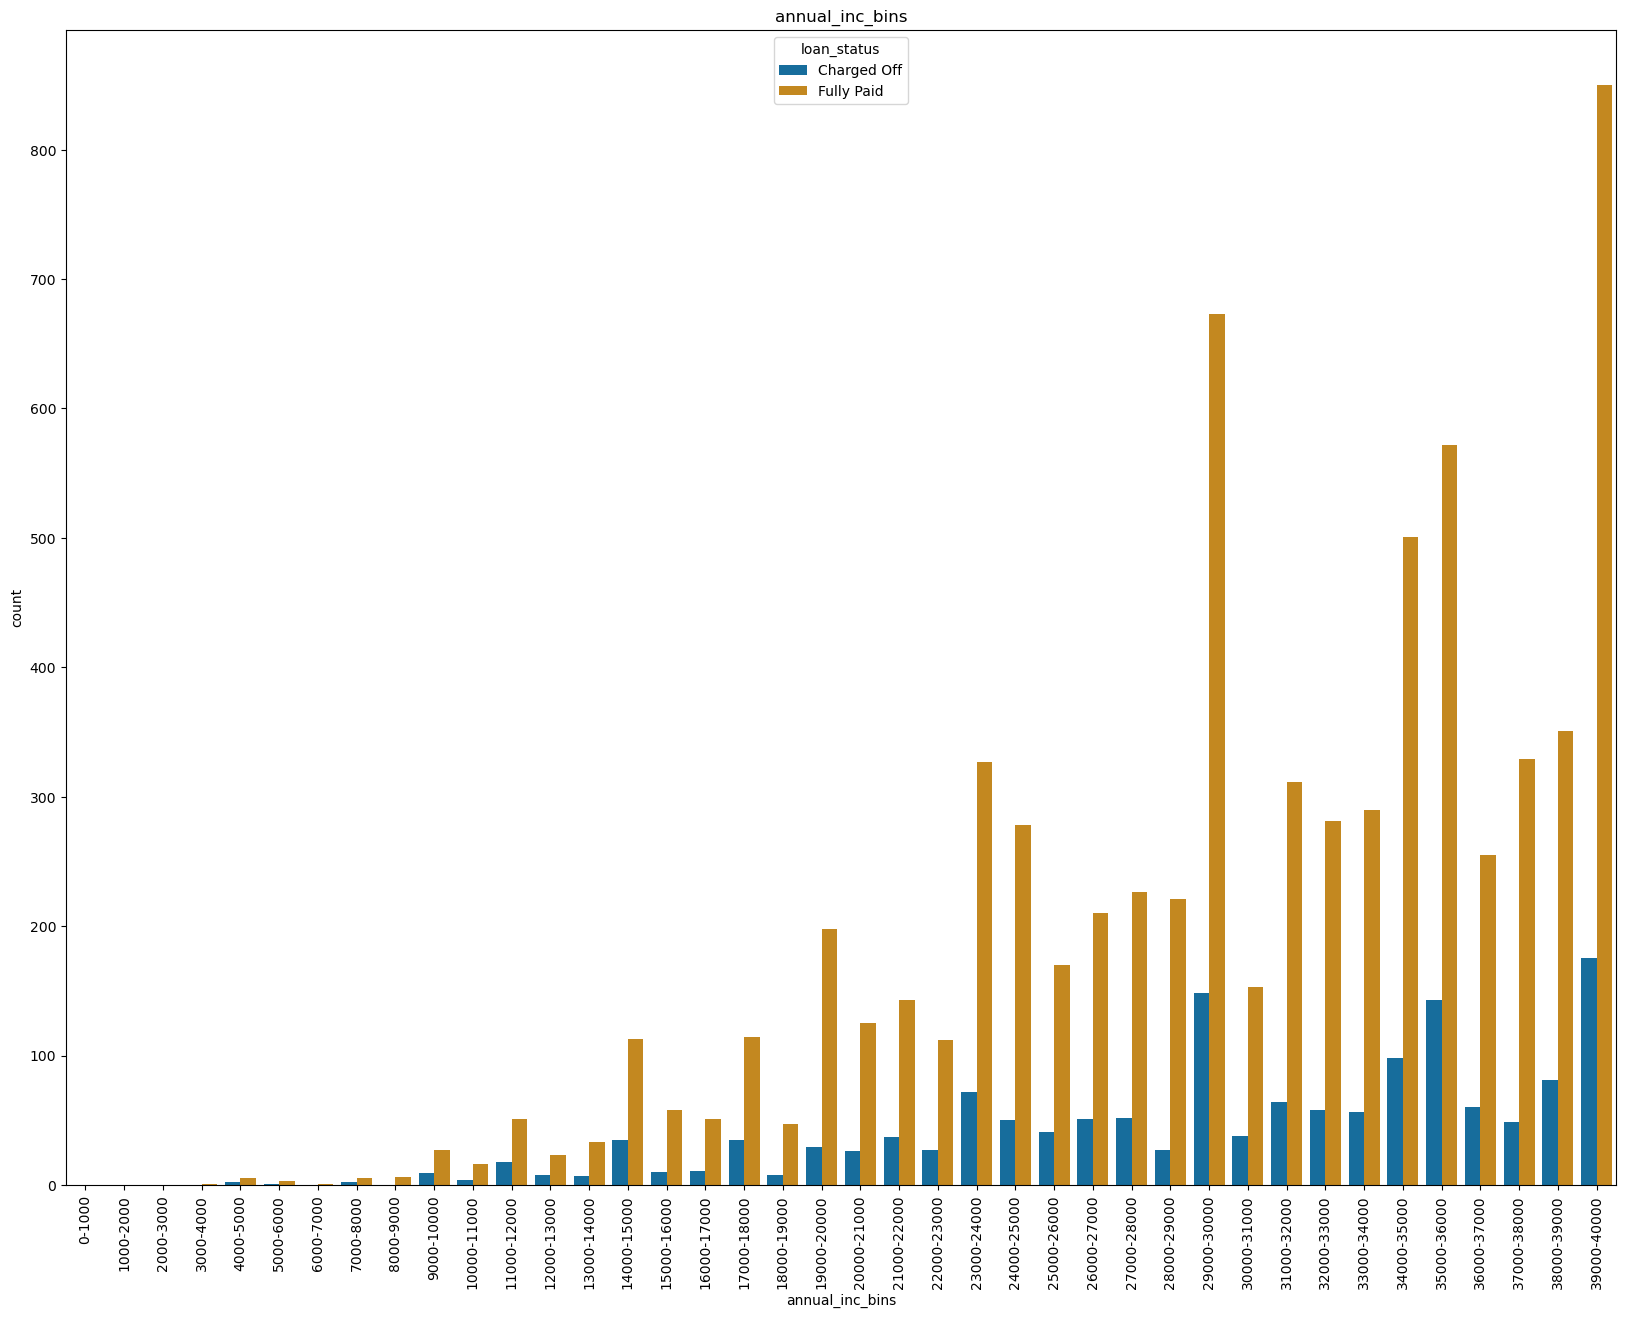

In [330]:
plotAttributeVsLoanStatus('annual_inc_bins')

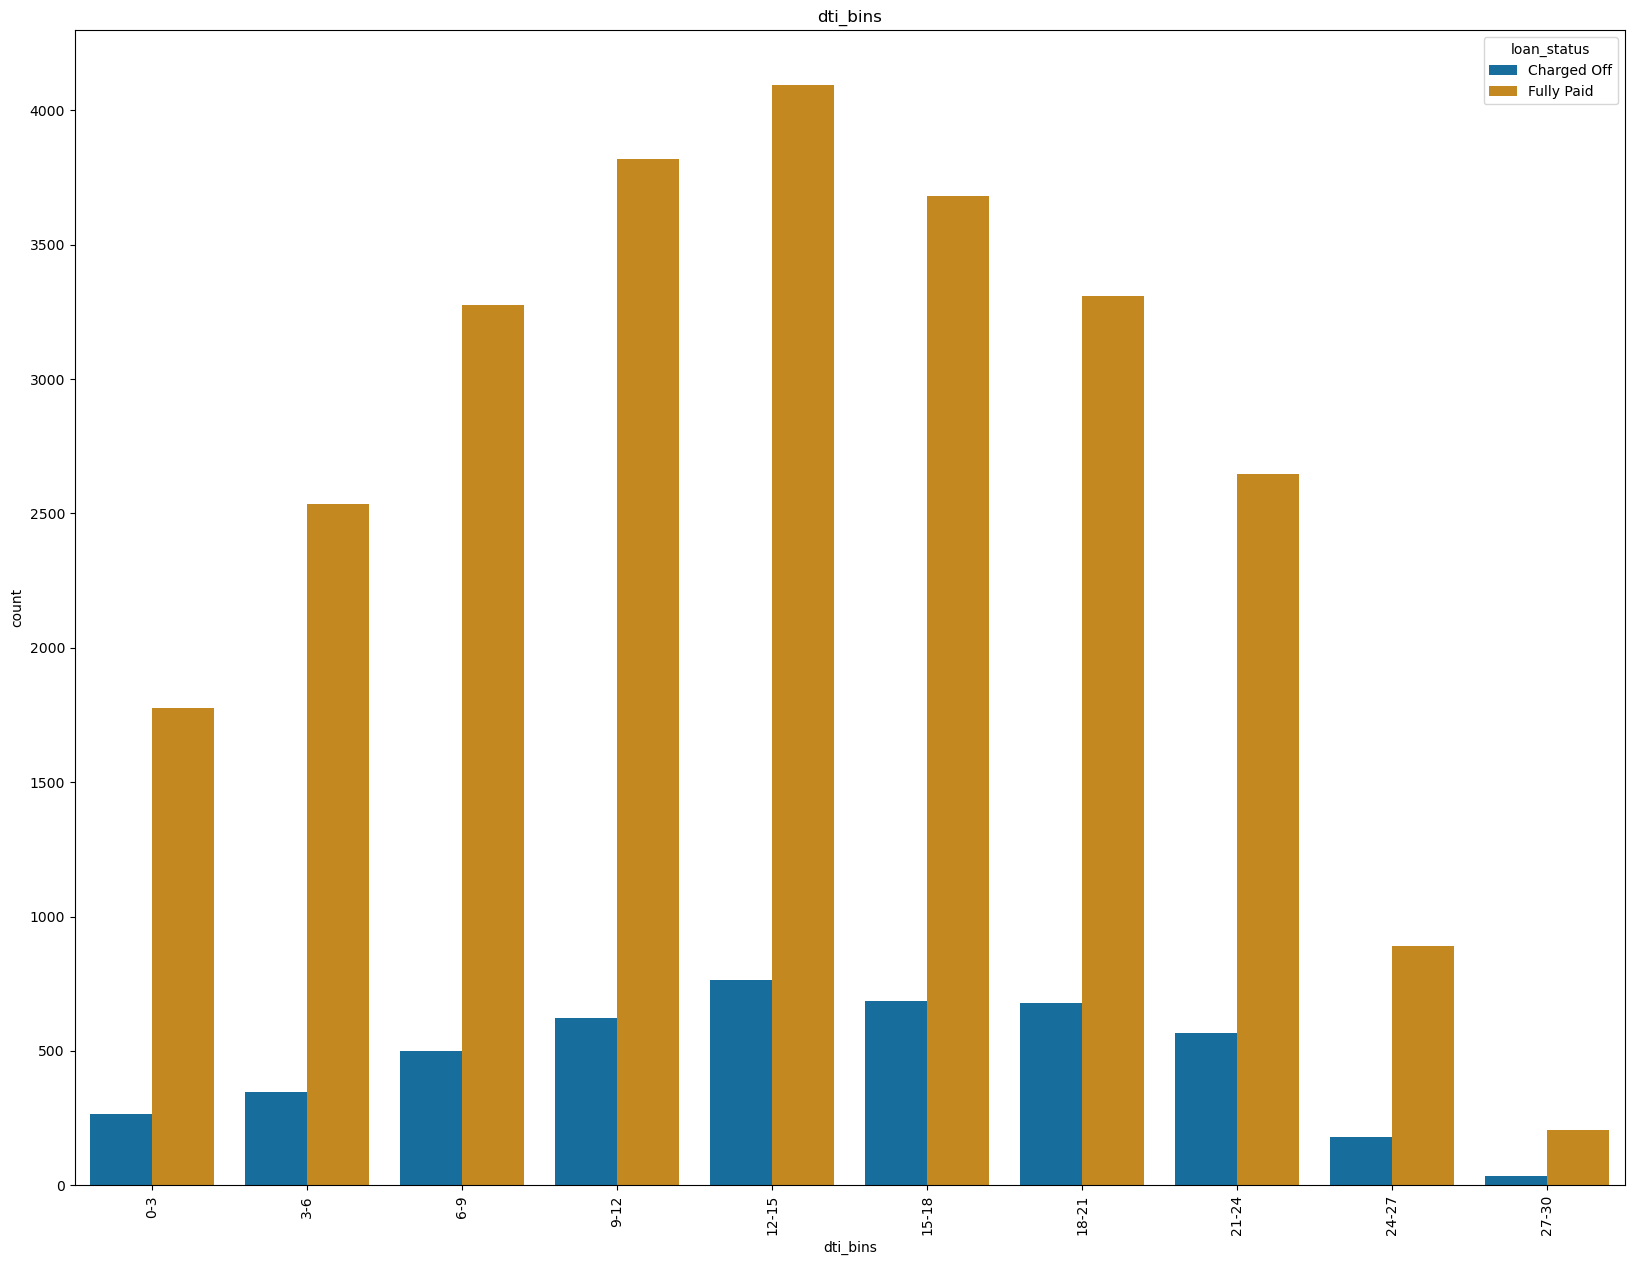

In [328]:
plotAttributeVsLoanStatus('dti_bins')

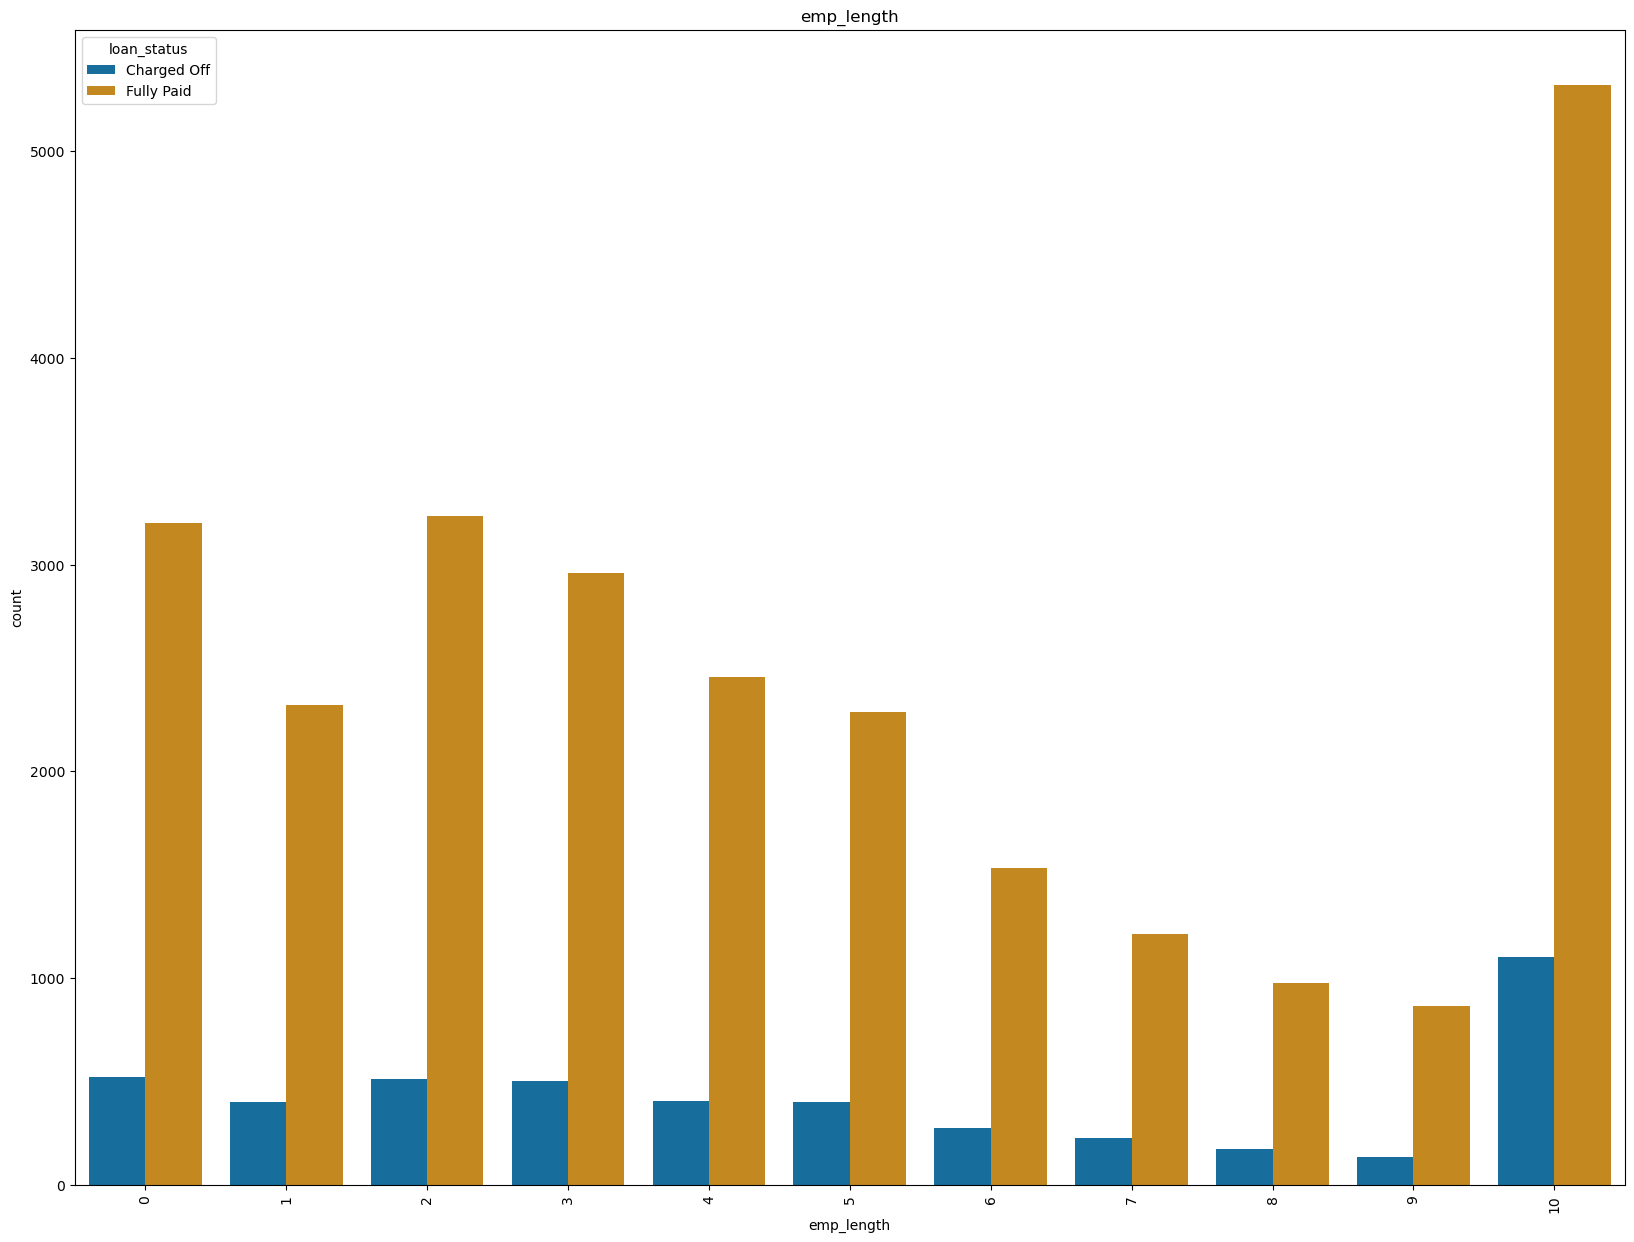

In [331]:
plotAttributeVsLoanStatus('emp_length')

## Bivariate analysis for categorical variables

In [322]:
continuous

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'dti',
 'emp_length',
 'annual_inc',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'inq_last_6mths',
 'pub_rec',
 'pub_rec_bankruptcies',
 'open_acc',
 'total_acc',
 'revol_bal',
 'revol_util',
 'total_pymnt',
 'total_pymnt_inv',
 'last_pymnt_amnt',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee']

### Term Vs Loan Status

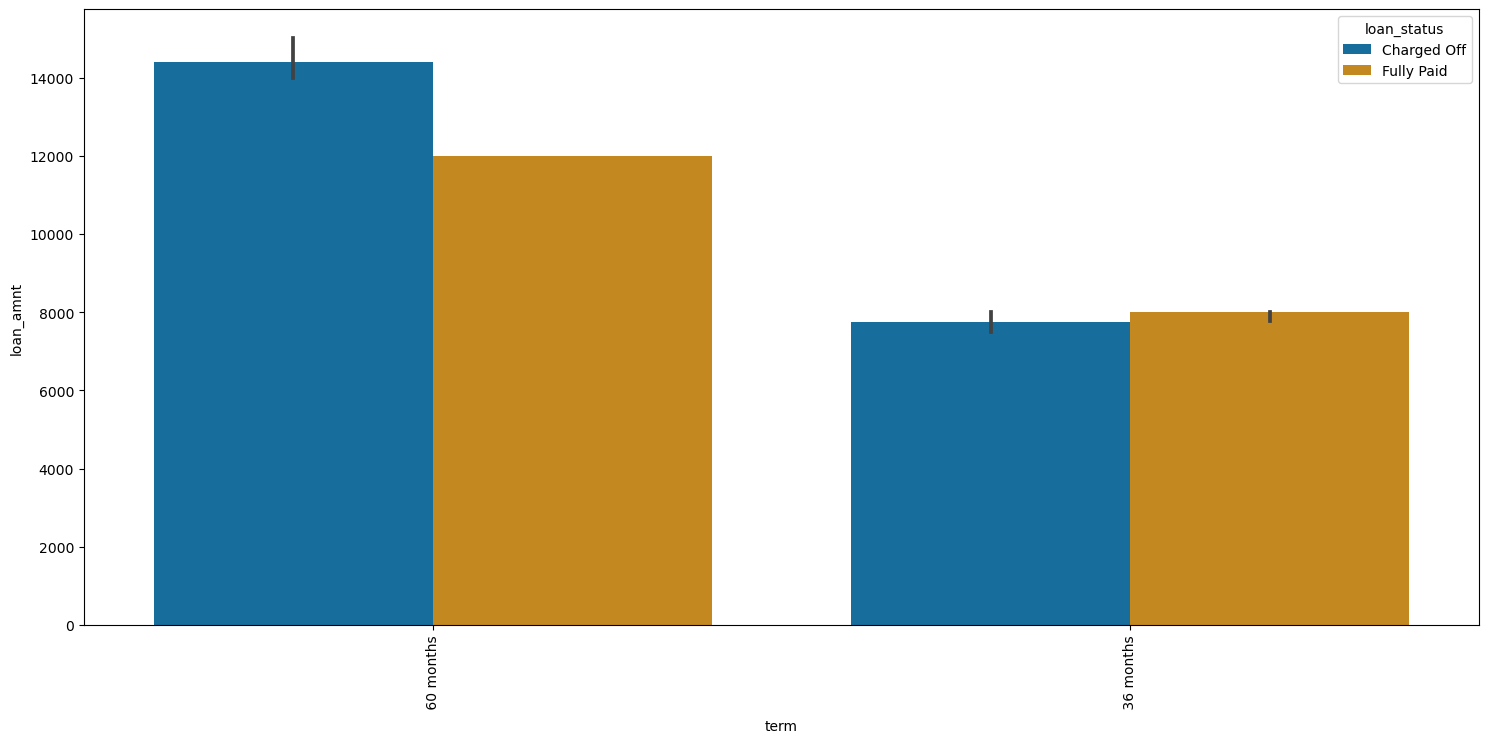

In [364]:
plt.figure(figsize=(18,8))
sns.barplot(x='term', y='loan_amnt', hue='loan_status', data=loan_df, estimator=np.median)
plt.xticks(rotation=90)
plt.show()

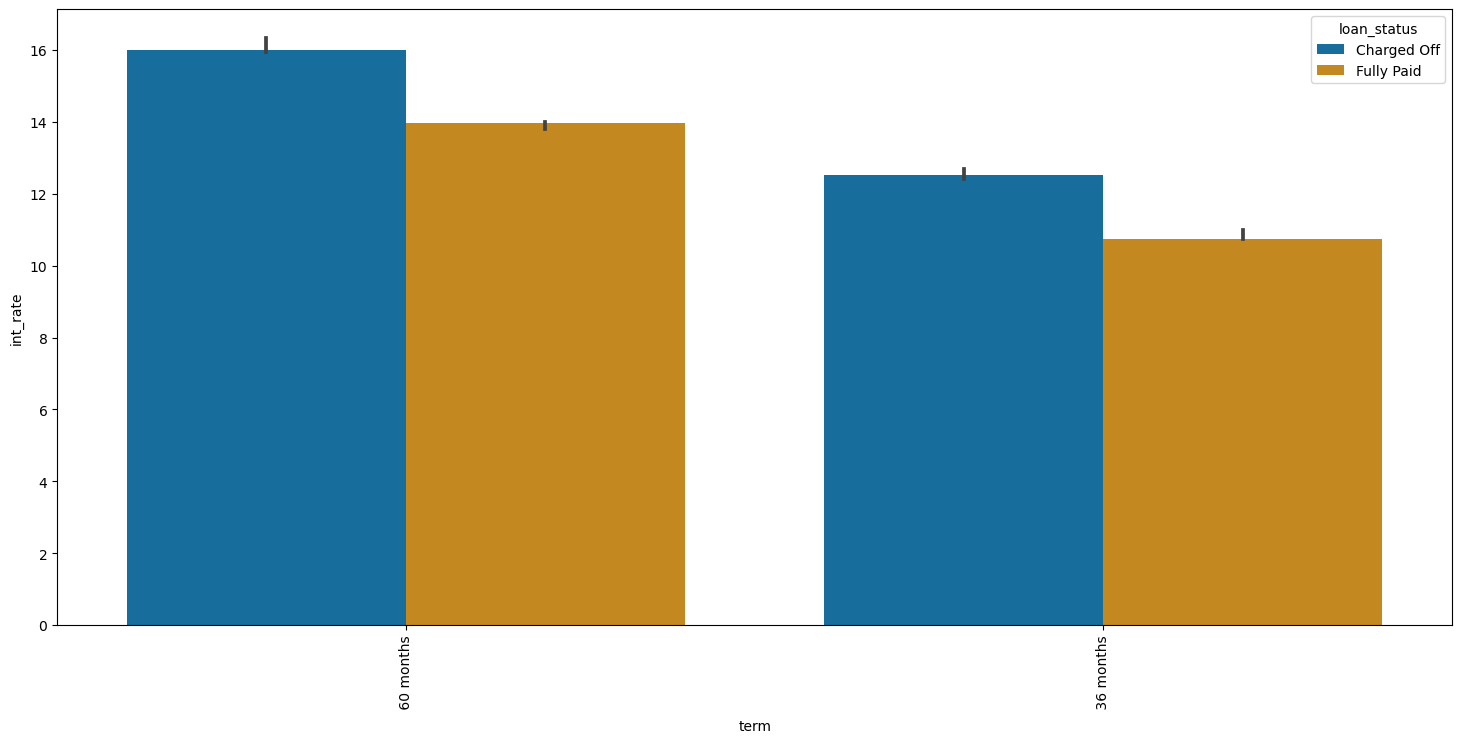

In [366]:
plt.figure(figsize=(18,8))
sns.barplot(x='term', y='int_rate', hue='loan_status', data=loan_df, estimator=np.median)
plt.xticks(rotation=90)
plt.show()

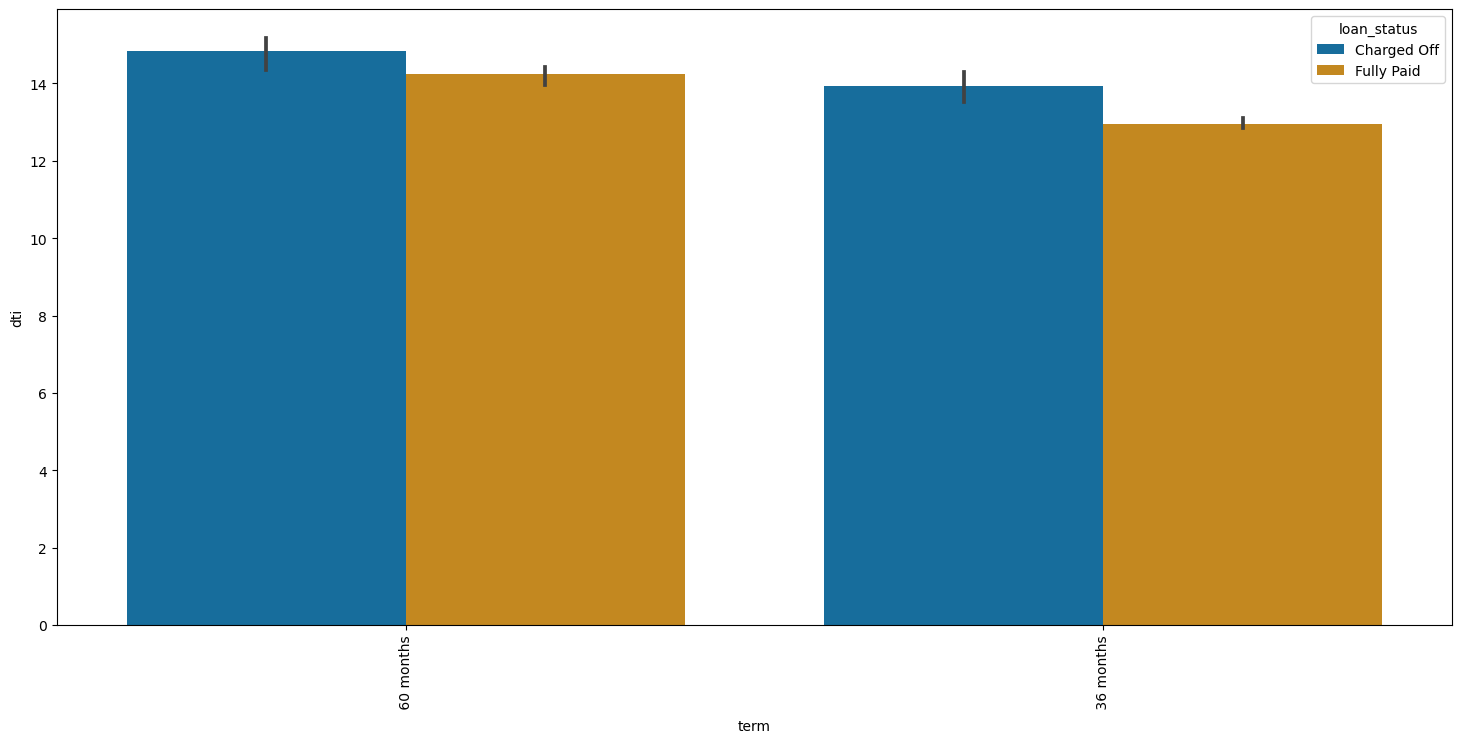

In [373]:
plt.figure(figsize=(18,8))
sns.barplot(x='term', y='dti', hue='loan_status', data=loan_df, estimator=np.median)
plt.xticks(rotation=90)
plt.show()